In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import math
import copy
from itertools import combinations
import numba
from numba import prange

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_precision_recall_curve

from sklearn.metrics import plot_precision_recall_curve

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier 
from xgboost import XGBClassifier
import umap
import umap.plot

from imblearn import FunctionSampler
from imblearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline 
import smote_variants as sv 

from category_encoders import CatBoostEncoder
from category_encoders import GLMMEncoder
from category_encoders import OrdinalEncoder

import pydotplus 
from IPython.display import Image
import graphviz

from dython.nominal import associations
import arfs.allrelevant as arfsgroot
from mlxtend.feature_selection import ColumnSelector
from mlxtend.evaluate import combined_ftest_5x2cv

import missingno as msno
from missingpy import MissForest


from ray import tune
from tune_sklearn import TuneSearchCV
from ray.tune.schedulers.hb_bohb import HyperBandForBOHB

import optuna
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
pd.set_option('max_colwidth', None)
pd.set_option('max_rows', None)

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.


In [2]:
def print_value_counts(dataframe):
    
    for column in dataframe:        
        if dataframe[column].dtype == object:
            print(dataframe[column].value_counts())
            print('')
            
        else:
            print(dataframe[column].value_counts().sort_index()) 
            print('')
            

def print_data_plots(dataframe):
    
    columns_countplot = [column for column in dataframe.columns if dataframe[column].nunique() < 80]
    columns_distplot = [column for column in dataframe.columns if dataframe[column].nunique() > 80]
    fig_dims = (13,4)    
    
    for column in dataframe[columns_countplot].columns:
        plt.figure()
        fig, ax = plt.subplots(figsize=fig_dims) 
        fig.autofmt_xdate()
        sns.countplot(x=column, data=dataframe)
        
    for column in dataframe[columns_distplot].columns:
        plt.figure()
        fig, ax = plt.subplots(figsize=fig_dims) 
        fig.autofmt_xdate()
        sns.histplot(dataframe[column])


# В  из библиотеки category_encoders был баг,
# кроме того, он не был адоптирован для использования в пайплайнах
# я переписпал его

class NestedCVWrapper(BaseEstimator, TransformerMixin):

    """Wrapper для вложенной кросс-валидации для целевых категориальных кодировщиков.
    Позволяет провести Single Validation из 
    https://towardsdatascience.com/benchmarking-categorical-encoders-9c322bd77ee8.       
    """
    
    def __init__(self, feature_encoder, cv=5, shuffle=True, random_state=None):
        self.feature_encoder = feature_encoder
        self.__name__ = feature_encoder.__class__.__name__
        self.model_list = []
        self.trn_idx_list = []
        self.oof_idx_list = []
        self.len_train = 0

        if type(cv) == int:
            self.cv = StratifiedKFold(n_splits=cv, shuffle=shuffle, random_state=random_state)
        else:
            self.cv = cv

    def fit(self, X, y, **kwargs):        
        self.len_train = X.shape[0]        
        for trn_idx, oof_idx in self.cv.split(X, y):
            feature_encoder = copy.deepcopy(self.feature_encoder)
            self.model_list.append(feature_encoder.fit(X.iloc[trn_idx], y.iloc[trn_idx]))
            self.trn_idx_list.append(trn_idx)
            self.oof_idx_list.append(oof_idx)
        
        self.feature_encoder.fit(X, y)       
            
        return self


    def transform(self, X):
        
        if self.len_train == X.shape[0]:
            out_of_fold = np.zeros(X.shape)
            for model, trn_idx, oof_idx in zip (self.model_list, self.trn_idx_list, self.oof_idx_list):
                out_of_fold[oof_idx] = model.transform(X.iloc[oof_idx])
            out_of_fold = pd.DataFrame(out_of_fold, columns=X.columns)   
            
            return out_of_fold
        else:
            
            return self.feature_encoder.transform(X)

        
# функция из imbalanced-learn для использования IsolationForest в пайплайне
def reject_outliers(X, y, contamination=0.01):
    
    model = IsolationForest(contamination=contamination, random_state=SEED, n_jobs=-1)
    model.fit(X)
    y_pred = model.predict(X)
    
    return X[y_pred == 1], y[y_pred == 1]


# модифицировнная функция, в которой выбросы удаляются только из мажоритарного отрицательного класса
def reject_neg_class_outliers(X, y, contamination=0.01, n_estimators=100, max_samples='auto'):
    
    model = IsolationForest(contamination=contamination, n_estimators=n_estimators, 
                            max_samples=max_samples, random_state=SEED, n_jobs=-1)
    model.fit(X) 
    y_pred = model.predict(X)    
    
    return X[np.any([y == 1, y_pred == 1], axis=0)], y[np.any([y == 1, y_pred == 1], axis=0)]


def calculate_vif(features):
    
    # добавляем фиктивную переменную для расчёта правильных значений VIF
    features = features.assign(const=1)    
    vif = pd.DataFrame()
    vif["variables"] = features.columns
    vif["VIF"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]

    return(vif)


# рассчитываем коэффициента eta, который является мерой силы связи 
# между категориальными и количественными признаками
def calculate_eta_corr(dataframe, quant_features, cat_features):
    quant_eta_lists = []
    
    for quant_feature in quant_features:
        eta_list = []
        
        for cat_feature in cat_features:        
            model = ols('{} ~ C({})'.format(quant_feature, cat_feature), data=dataframe).fit()
            anova_table = sm.stats.anova_lm(model, typ=2, robust='hc3') 
            eta = anova_table[:-1]['sum_sq']/sum(anova_table['sum_sq'])             
            eta_list.append(float(eta))            
        quant_eta_lists.append(eta_list)   
        
    return pd.DataFrame(quant_eta_lists, columns=cat_features, index=quant_features)


def get_high_corr_features(corr_matrix, threashold, fill_diagonal_ones = True):
    
    corr_matrix_abs = corr_matrix.abs()
    if fill_diagonal_ones == True:
        np.fill_diagonal(corr_matrix_abs.values, 0)    
    # создаем список признаков с корреляцией больше порога
    high_corr_features = [column for column in corr_matrix_abs.columns
                          if any(corr_matrix_abs[column] > threashold)]
    
    return high_corr_features


def get_indexes_features(dataframe, features):
    indexes = [dataframe.columns.get_loc(feature) for feature in features]
    return indexes


def get_all_combinations(corr_indexes, empty_combination = False):
    tuple_combinations = []
    end_in_range = len(corr_indexes)+1
    
    if empty_combination == True:
        first_in_range = 0
    else:
        first_in_range = 1      
    
    for length_combination in range(first_in_range, end_in_range):
        tuple_combinations += list(combinations(corr_indexes, length_combination))
    list_combinations = [list(element) for element in tuple_combinations]
    
    return list_combinations


# получаем комбинации важных функций с неважными
def get_imp_unimp_combinations(unimp_combinations, imp_combination):    
    imp_unimp_combinations = []  
    
    for unimp_combination in unimp_combinations:    
           imp_unimp_combinations.append(unimp_combination + imp_combination)
            
    return imp_unimp_combinations


def get_grid_result(gridsearch_name):    
    result = (
        pd.DataFrame({
            'mean_average_precision': gridsearch_name.cv_results_['mean_test_average_precision'],
            'mean_roc_auc': gridsearch_name.cv_results_['mean_test_roc_auc']}).join(
        pd.json_normalize(gridsearch_name.cv_results_['params']).add_prefix('param_'))
    ).sort_values(['mean_average_precision'], ascending = False)
         
    return result

In [3]:
SEED = 42

In [4]:
df = pd.read_csv('./bank-additional-full.csv', sep = ';')
# заменяем точки на нижнее подчеркивание в названиях признаков
df = df.rename(columns=dict(zip(df.columns, list(map(lambda x: x.replace('.', '_'), df.columns)))))

In [5]:
df.head(5) 

age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp_var_rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons_price_idx  cons_conf_idx  euribor3m  nr_employed   y  
0          93.994          -36.4      4.857       5191.0  no  
1          93.994          -36.4      4.857       5191.0  no  
2          93.994          -36.4      4.857       5191.0  no  
3          93.994          -36.4      4.857       5191.0  no  
4          93.994          -36.4      4.857       5191.0  no  

[5 rows x 21 columns]

In [6]:
df.shape

(41188, 21)

In [7]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp_var_rate    41188 non-null  float64
 16  cons_price_idx  41188 non-null  float64
 17  cons_conf_idx   41188 non-null 

In [8]:
df.describe()

age      duration      campaign         pdays      previous  \
count  41188.00000  41188.000000  41188.000000  41188.000000  41188.000000   
mean      40.02406    258.285010      2.567593    962.475454      0.172963   
std       10.42125    259.279249      2.770014    186.910907      0.494901   
min       17.00000      0.000000      1.000000      0.000000      0.000000   
25%       32.00000    102.000000      1.000000    999.000000      0.000000   
50%       38.00000    180.000000      2.000000    999.000000      0.000000   
75%       47.00000    319.000000      3.000000    999.000000      0.000000   
max       98.00000   4918.000000     56.000000    999.000000      7.000000   

       emp_var_rate  cons_price_idx  cons_conf_idx     euribor3m   nr_employed  
count  41188.000000    41188.000000   41188.000000  41188.000000  41188.000000  
mean       0.081886       93.575664     -40.502600      3.621291   5167.035911  
std        1.570960        0.578840       4.628198      1.734447     72.251528  
min       -3.400000       92.201000     -50.800000      0.634000   4963.600000  
25%       -1.800000       93.075000     -42.700000      1.344000   5099.100000  
50%        1.100000       93.749000     -41.800000      4.857000   5191.000000  
75%        1.400000       93.994000     -36.400000      4.961000   5228.100000  
max        1.400000       94.767000     -26.900000      5.045000   5228.100000

In [9]:
list_cat_features = df.select_dtypes(include = object).columns.to_list()

In [10]:
print_value_counts(df)
""" Вместо NaN используется unknown,
есть очень редкие категории,
экстремальные значения/выбросы,
категориальные признаки с двумя значениями стоит кодировать в 1, 0,
отсуствуют странные, некорректные уникальные значения,
в датасете дисбаланс классов.
"""

17       5
18      28
19      42
20      65
21     102
22     137
23     226
24     463
25     598
26     698
27     851
28    1001
29    1453
30    1714
31    1947
32    1846
33    1833
34    1745
35    1759
36    1780
37    1475
38    1407
39    1432
40    1161
41    1278
42    1142
43    1055
44    1011
45    1103
46    1030
47     928
48     979
49     839
50     875
51     754
52     779
53     733
54     684
55     648
56     704
57     646
58     576
59     463
60     283
61      73
62      62
63      55
64      57
65      44
66      57
67      26
68      33
69      34
70      47
71      53
72      34
73      34
74      32
75      24
76      34
77      20
78      27
79      14
80      31
81      20
82      17
83      17
84       7
85      15
86       8
87       1
88      22
89       2
91       2
92       4
94       1
95       1
98       2
Name: age, dtype: int64

admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
re

' Вместо NaN используется unknown,\nесть очень редкие категории,\nэкстремальные значения/выбросы,\nкатегориальные признаки с двумя значениями стоит кодировать в 1, 0,\nотсуствуют странные, некорректные уникальные значения,\nв датасете дисбаланс классов.\n'

In [11]:
pd.set_option('max_columns', None)
# отображаем количество уникальных значений у каждого признака
df.agg(['nunique'])

age  job  marital  education  default  housing  loan  contact  month  \
nunique   78   12        4          8        3        3     3        2     10   

         day_of_week  duration  campaign  pdays  previous  poutcome  \
nunique            5      1544        42     27         8         3   

         emp_var_rate  cons_price_idx  cons_conf_idx  euribor3m  nr_employed  \
nunique            10              26             26        316           11   

         y  
nunique  2

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<Figure size 432x288 with 0 Axes>

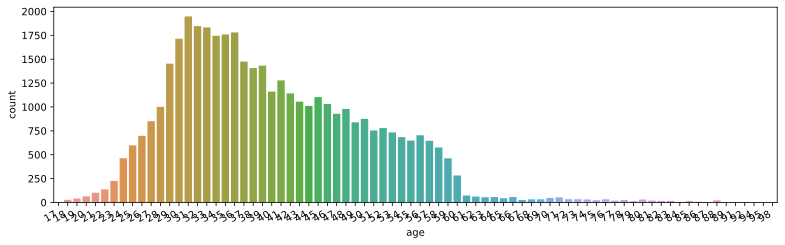

<Figure size 432x288 with 0 Axes>

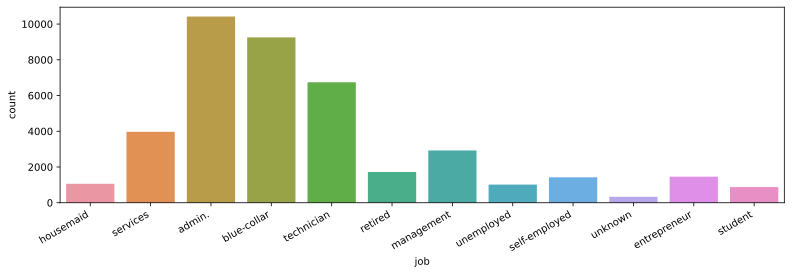

<Figure size 432x288 with 0 Axes>

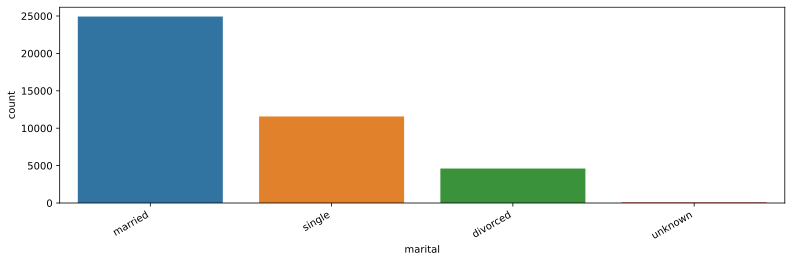

<Figure size 432x288 with 0 Axes>

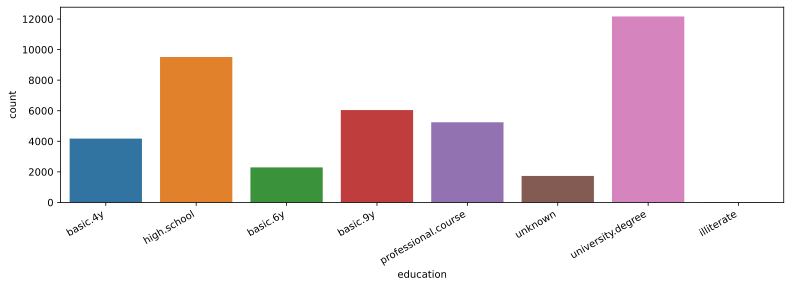

<Figure size 432x288 with 0 Axes>

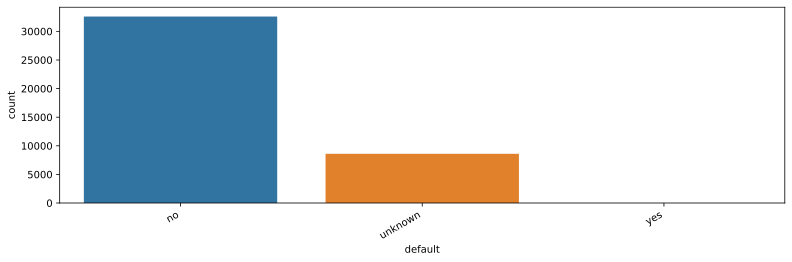

<Figure size 432x288 with 0 Axes>

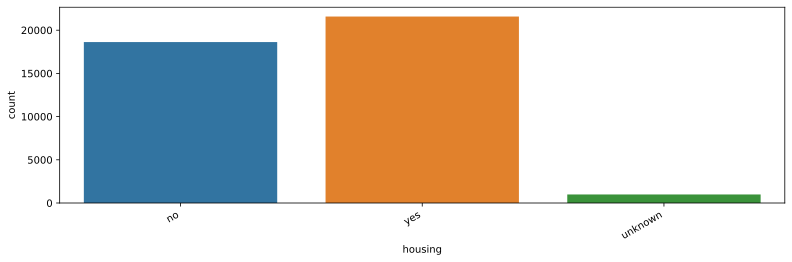

<Figure size 432x288 with 0 Axes>

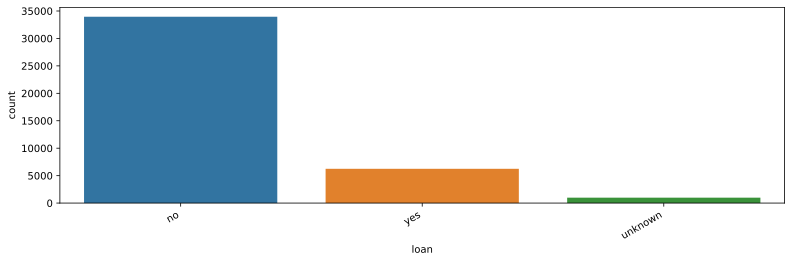

<Figure size 432x288 with 0 Axes>

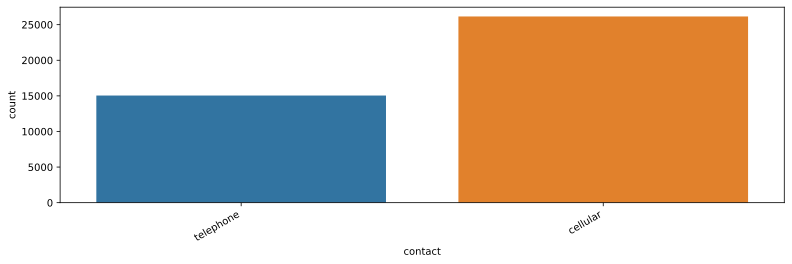

<Figure size 432x288 with 0 Axes>

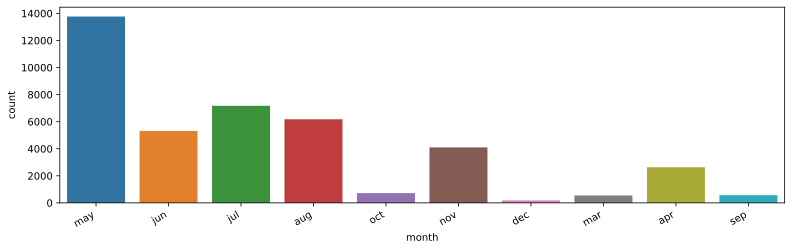

<Figure size 432x288 with 0 Axes>

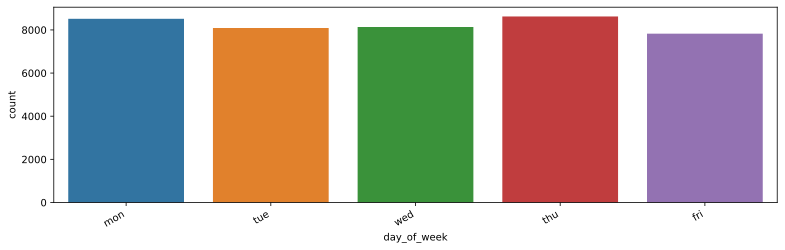

<Figure size 432x288 with 0 Axes>

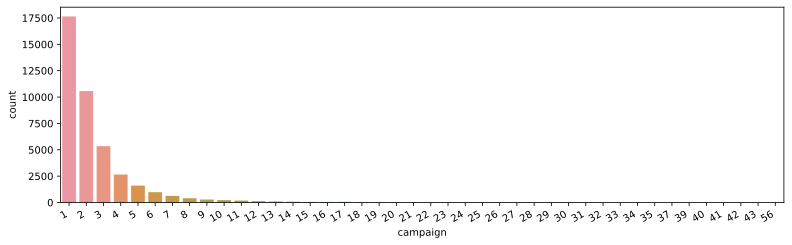

<Figure size 432x288 with 0 Axes>

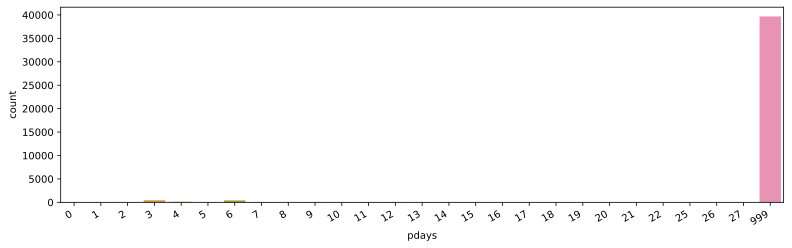

<Figure size 432x288 with 0 Axes>

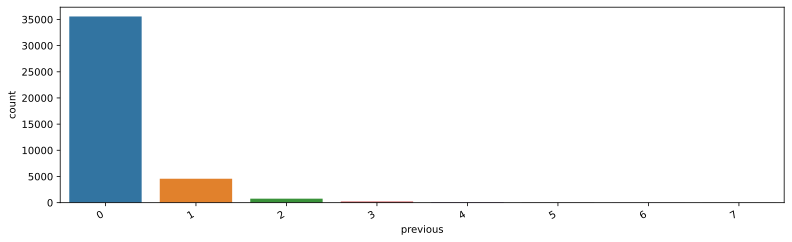

<Figure size 432x288 with 0 Axes>

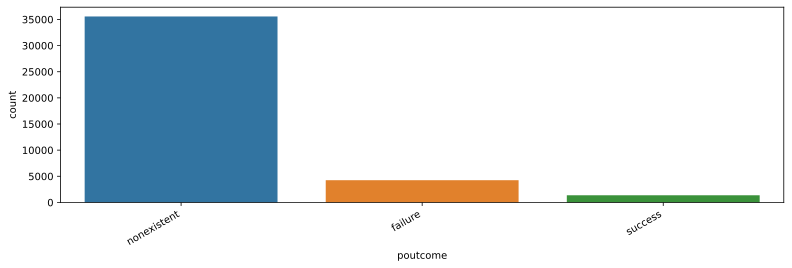

<Figure size 432x288 with 0 Axes>

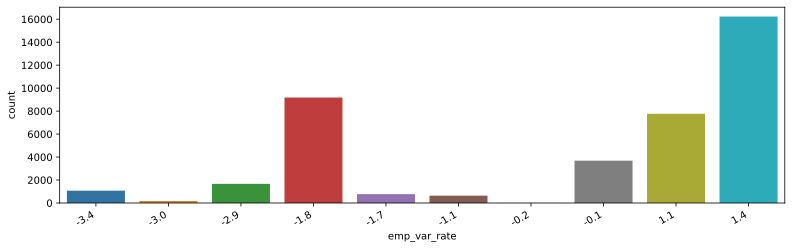

<Figure size 432x288 with 0 Axes>

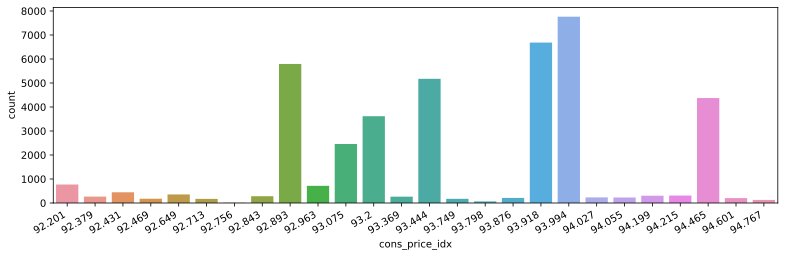

<Figure size 432x288 with 0 Axes>

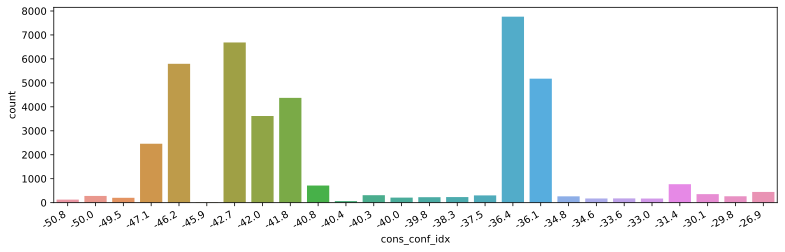

<Figure size 432x288 with 0 Axes>

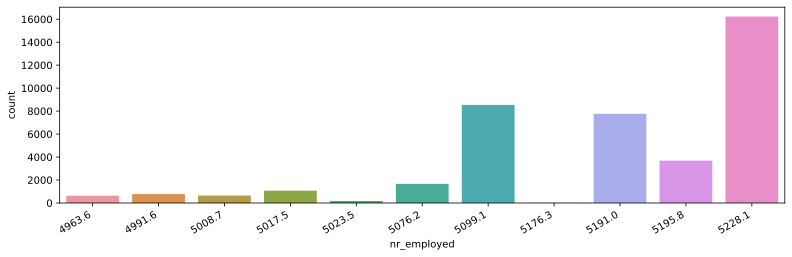

<Figure size 432x288 with 0 Axes>

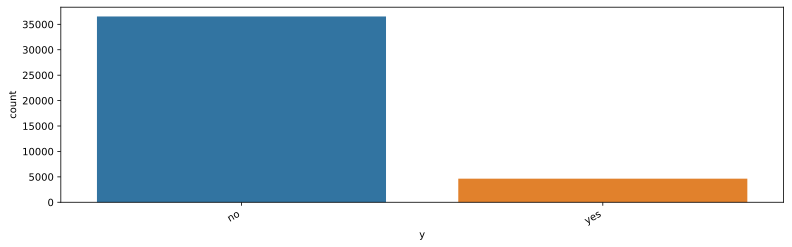

<Figure size 432x288 with 0 Axes>

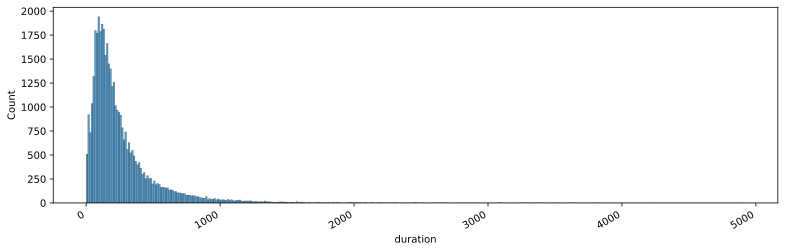

<Figure size 432x288 with 0 Axes>

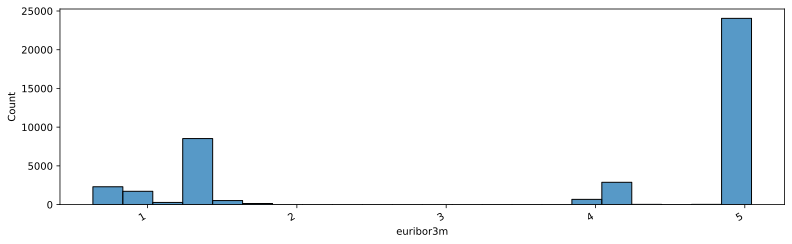

In [12]:
print_data_plots(df)       

In [13]:
df.drop_duplicates(inplace=True)
# удаляем объекты с очень редкой категорией 18 из 41188
df = df[df.education != 'illiterate']
# удаляем признак duration, чтобы избежать утечки данных 
# (как сказано в документации к датасету)
df.drop('duration', axis=1, inplace=True)
df.reset_index(drop=True)
# объединим 'unknown' и 'yes', чтобы избавиться от редкой категории
# и закодируем 'default' как бинарный признак
df['default'] = (df['default'] != 'no').astype(int)
# всех клиентов, с которыми связывались хотя бы раз объединяем под категорией 1,
# остальных под категорией 0
df['pdays'] = (df['pdays'] != 999).astype(int)
# кодируем порядковые и бинарные признаки
# исходя из информации о системе образования в Португалии,
# уровни образования следует упордочить следующим образом
df.replace(
    {'basic.4y': 1, 'basic.6y': 2, 'basic.9y': 3,'professional.course': 4,
    'high.school': 5, 'university.degree' : 6, 'yes': 1, 'no': 0, 
    'cellular': 1, 'telephone': 0,'mar': 1, 'apr': 2, 'may': 3, 'jun': 4, 
    'jul': 5, 'aug': 6, 'sep': 7, 'oct': 8, 'nov': 9, 'dec': 10, 'mon': 1,
    'tue': 2, 'wed': 3, 'thu': 4, 'fri': 5}, inplace=True
)                 

In [14]:
df_NaN = df.replace('unknown', np.NaN)
df_NaN.isna().sum()

age                  0
job                330
marital             80
education         1730
default              0
housing            990
loan               990
contact              0
month                0
day_of_week          0
campaign             0
pdays                0
previous             0
poutcome             0
emp_var_rate         0
cons_price_idx       0
cons_conf_idx        0
euribor3m            0
nr_employed          0
y                    0
dtype: int64

In [15]:
msno.matrix(df_NaN, figsize=(10, 6))

<AxesSubplot:>

<AxesSubplot:>

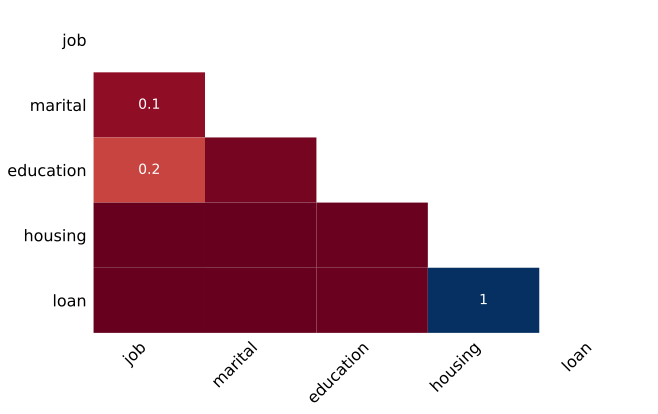

In [16]:
# пропуски в housing и loan у одних и тех же объектов
msno.heatmap(df_NaN, figsize = (10,6))

In [17]:
dataframe_X = df_NaN.loc[:, df_NaN.columns != 'y']
series_y = df_NaN.y
# создаем списки c названиями признаков по типам признаков
nominal = list(dataframe_X.select_dtypes(include = object).columns)

binary = [dataframe_X[column].name for column in dataframe_X.columns 
          if dataframe_X[column].nunique() == 2]

ordinal = [dataframe_X[column].name for column in dataframe_X.columns 
           if (dataframe_X[column].name in list_cat_features 
           and 3 in dataframe_X[column].unique())]

cat = nominal + ordinal + binary 

quantitative = [dataframe_X[column].name for column in dataframe_X.columns 
            if dataframe_X[column].name not in cat]

ord_bin = ordinal + binary
quant_ord = quantitative + ordinal
quant_nom = quantitative + nominal

# получаем список индексов, указывающих на порядковые и бинарные признаки с пропусками,
# для передачи его в MissForest
ord_bin_nan = dataframe_X[ord_bin].columns[dataframe_X[ord_bin].isnull().any()].tolist()
ord_bin_nan_indexes = [dataframe_X.columns.get_loc(column) for column in ord_bin_nan]

# переносим признак 'poutcome' из ord_bin в quant_nom,
# ввиду особеностей масштабирования в дальнейшем 
ord_bin_w_pout = copy.deepcopy(ord_bin) + ['poutcome'] 
quant_nom_wo_pout = copy.deepcopy(quant_nom)
quant_nom_wo_pout.remove('poutcome')
scaler_columns = quant_nom_wo_pout+ord_bin_w_pout
# получаем индексы признаков для передачи в ColumnTransformer
ord_bin_w_pout_indexes = [dataframe_X.columns.get_loc(column) for column in ord_bin_w_pout] 
quant_nom_wo_pout_indexes = [dataframe_X.columns.get_loc(column) for column in quant_nom_wo_pout]

Scaler = ColumnTransformer([
        ('quant_nom', RobustScaler(), quant_nom_wo_pout_indexes),
        ('ord_bin', MinMaxScaler(feature_range=(-1, 1)), ord_bin_w_pout_indexes)
])

print(quantitative)
print(nominal)
print(binary)
print(ordinal)
print(ord_bin_w_pout)
print(quant_nom_wo_pout)
print(ord_bin_nan_indexes)

['age', 'campaign', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']
['job', 'marital', 'poutcome']
['default', 'housing', 'loan', 'contact', 'pdays']
['education', 'month', 'day_of_week']
['education', 'month', 'day_of_week', 'default', 'housing', 'loan', 'contact', 'pdays', 'poutcome']
['age', 'campaign', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'job', 'marital']
[3, 5, 6]


In [18]:
X_train, X_test, y_train, y_test = train_test_split(
df_NaN.loc[:, df_NaN.columns != 'y'], df_NaN.y, stratify=df_NaN.y, test_size=0.15, random_state=SEED)

X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

In [19]:
# предобрабатываем данные для разведочного анализа
pipe_eda = Pipeline([
    ('cat_encoder', NestedCVWrapper(CatBoostEncoder(handle_missing='return_nan'), random_state=SEED)),    
    ('imputer', MissForest(random_state=SEED)), 
    ('scaler', Scaler)
    ])

X_train_eda = pipe_eda.fit_transform(X_train, y_train, imputer__cat_vars=ord_bin_nan_indexes) 
X_train_eda = pd.DataFrame(X_train_eda, columns=scaler_columns)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


In [20]:
train_eda = pd.concat([X_train_eda, y_train], axis=1)
# детектируем выбросы, чтобы далее без них точнее рассчитать корреляцию признаков
Iso_Forest = IsolationForest(random_state=SEED, contamination='auto', n_estimators=200)
Iso_Forest.fit(X_train_eda)
# предсказываем выбросы в автоматическом режиме
label_outliers_auto = Iso_Forest.predict(X_train_eda) 
label_outliers_auto = pd.Series(label_outliers_auto, name='label_outliers_auto', index=(X_train_eda.index))
# посмотрим сколько выбросов нам предсказал алгоритм в автоматическом режиме
print(label_outliers_auto.value_counts())

 1    23683
-1    11301
Name: label_outliers_auto, dtype: int64


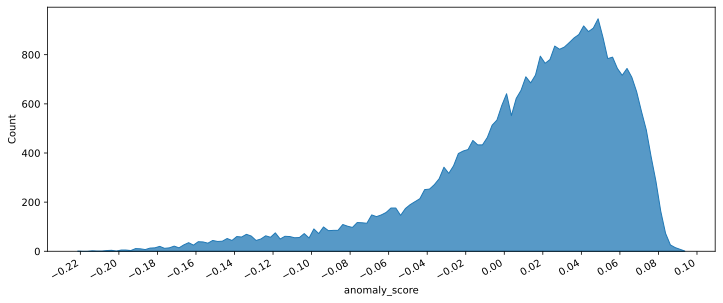

In [21]:
# в авто режиме алгоритм отнёс 1/3 к выбросам,
# поэтому мы сами определим threshold для выбросов по anomaly_score
# чем ментьше anomaly_score, тем вероятней объект является выбросом
anomaly_score = Iso_Forest.decision_function(X_train_eda)
anomaly_score = pd.Series(anomaly_score, name='anomaly_score',
                          index=X_train_eda.index)

fig_dims = (12,5) 
fig, ax = plt.subplots(figsize=fig_dims)        
fig.autofmt_xdate()
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.02))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
sns.histplot(anomaly_score, binwidth=0.0025, element='poly')

outlier_threshold = -0.10

In [22]:
df_umap = train_eda.copy()
# помечаем выбросы для визуализации вместе с метками классов в umap
df_class_w_outliers = df_umap.copy()
df_class_w_outliers.loc[list(anomaly_score[anomaly_score <= outlier_threshold].index),'y'] = 2
# помечаем 1 объект классом 2 для отображения в той же цветовой схеме
df_class_wo_outliers = df_umap.copy()
df_class_wo_outliers.loc[0, 'y'] = 2
# помечаем выбросы как класс -1
df_outliers = df_umap.copy()
df_outliers['outliers'] = df_outliers.y
df_outliers.loc[list(anomaly_score[anomaly_score <= outlier_threshold].index),'outliers'] = -1
df_outliers.loc[list(anomaly_score[anomaly_score > outlier_threshold].index),'outliers'] = 1

# смотрим сколько у нас выбросов
number_outliers = df_outliers['outliers'].isin([-1]).sum()
percent_minority_class = round((len(df_outliers[(df_outliers['outliers'] == -1) 
                          & (df_outliers['y'] == 1)]) 
                          / df_outliers['outliers'].isin([-1]).sum()) * 100)
print('из {} выбросов {}% минорного 1 класса'.format(number_outliers, percent_minority_class))
# 54% из 1553 выбросов относятся к 1 минорному классу при threshold = -0.10,
# при threshold = -0.13 64% из 828

из 1526 выбросов 54% минорного 1 класса


In [23]:
#umap_model = umap.UMAP(n_neighbors=15, min_dist = 0.1, random_state=SEED).fit(df_umap.iloc[:,:-1]) 

In [24]:
# смотрим на наши классы
#umap.plot.points(umap_model, labels=df_class_wo_outliers.y, theme='darkblue')
# смотрим на классы и выбросы
#umap.plot.points(umap_model, labels=df_class_w_outliers.y, theme='darkblue') #df_class_outliers background='black' color_key_cmap='Paired'

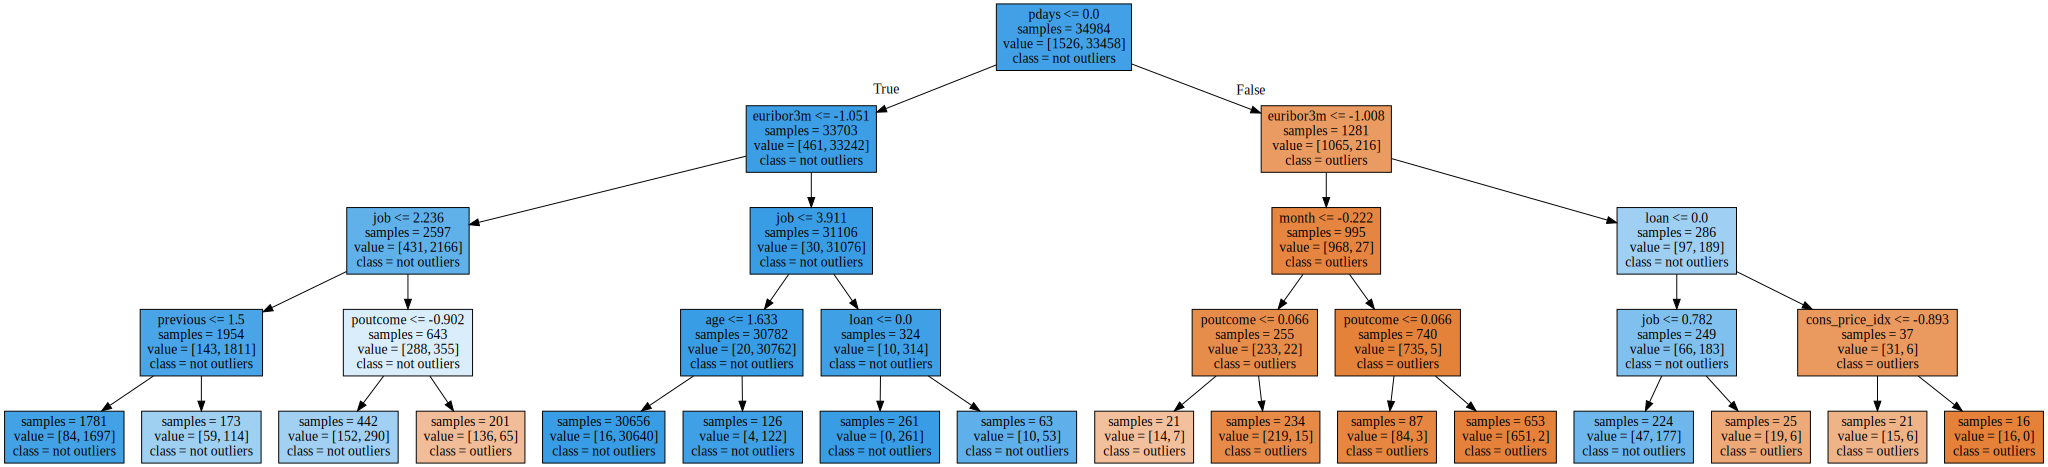

In [25]:
# чтобы лучше понимать, что делает выбросы выбросами визуализируем дерево решений
tree = DecisionTreeClassifier(random_state=0, max_depth=4)  
tree.fit(df_outliers.iloc[:,:-1], df_outliers.outliers)

dot_data = export_graphviz(tree, out_file='tree.dot', 
              feature_names = df_outliers.iloc[:,:-1].columns,
              class_names = ['outliers', 'not outliers'], 
              impurity=False, filled = True)

with open('tree.dot') as f:
    dot_graph = f.read()
    
graphviz.Source(dot_graph)

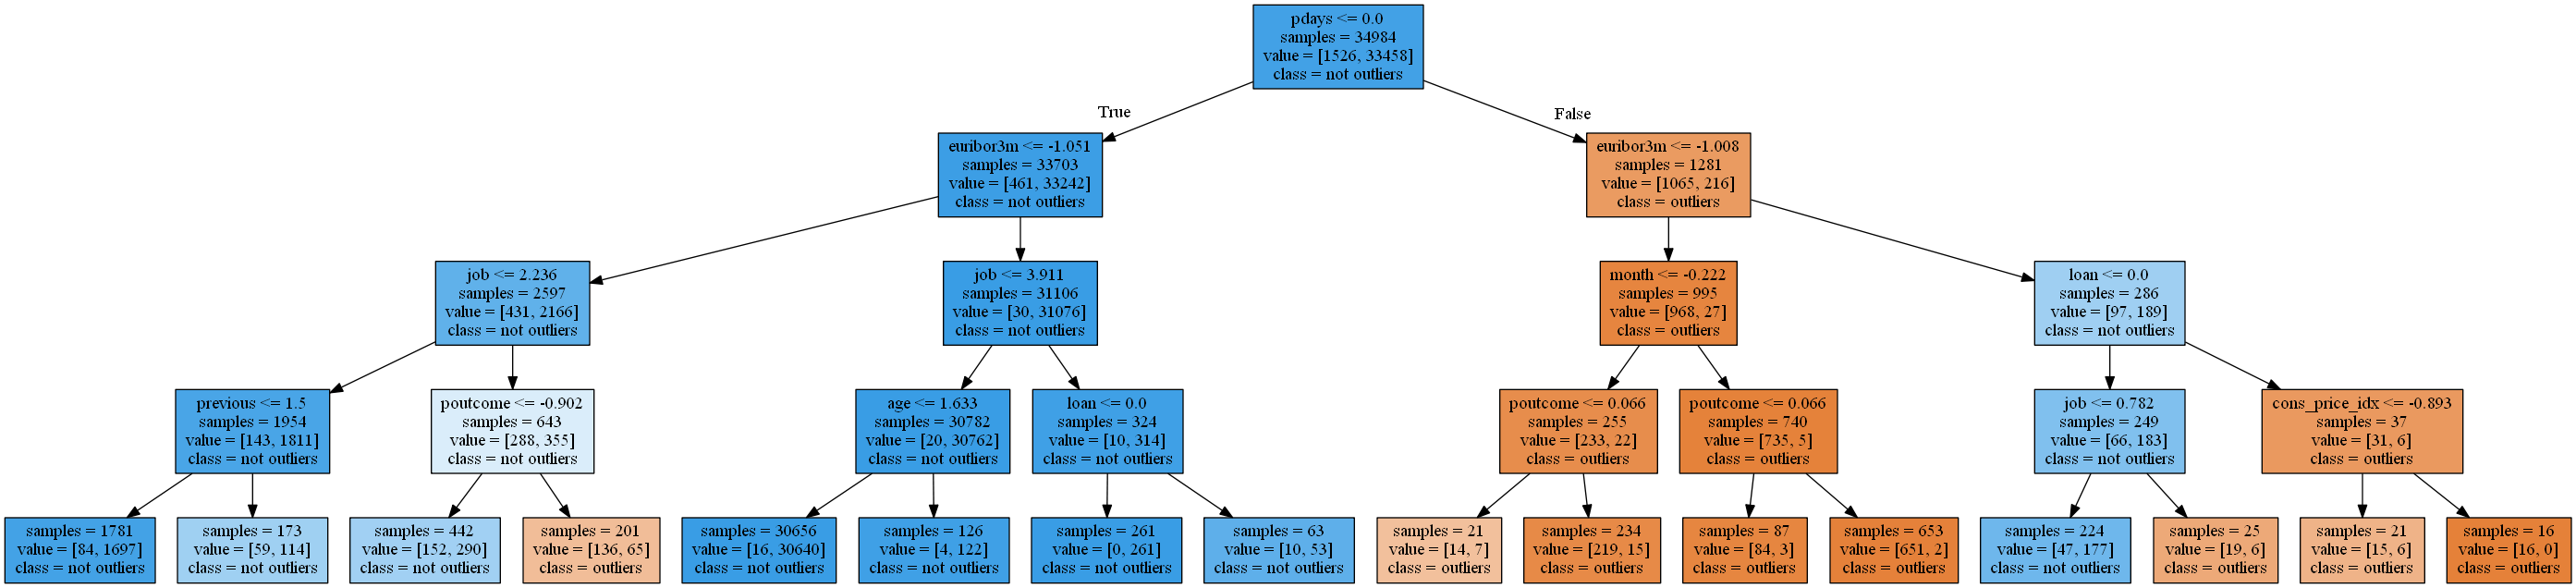

In [26]:
graph = pydotplus.graphviz.graph_from_dot_file('tree.dot')  
Image(graph.create_png())

In [28]:
# удаляем выбросы
train_eda.drop(list(anomaly_score[anomaly_score <= outlier_threshold].index), inplace=True)
df_NaN.drop(list(anomaly_score[anomaly_score <= outlier_threshold].index), inplace=True)

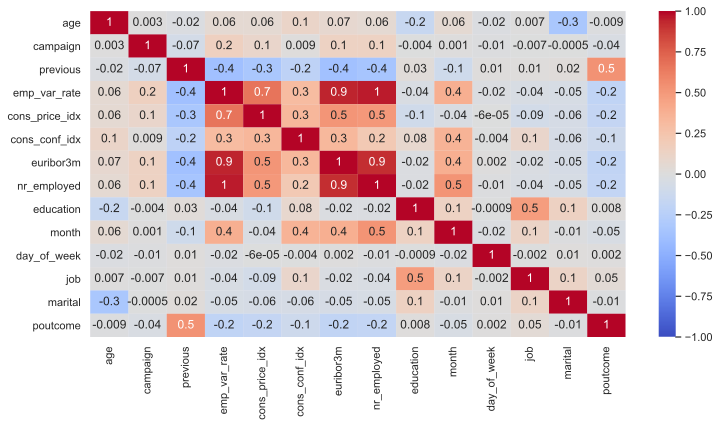

In [30]:
# смотрим на корреляцию Спирмена
spearman_corr = train_eda[quant_ord+nominal].corr(method='spearman') 
sns.set(rc={'figure.figsize':(12,6)})
sns.heatmap(spearman_corr, annot=True, fmt='.1g', vmin=-1, vmax=1, center=0, cmap= 'coolwarm')
plt.show()

In [31]:
# вычисляем коэффициент инфляции дисперсии (VIF)
calculate_vif(train_eda[quant_ord+nominal])

variables        VIF
0              age   1.288844
1         campaign   1.033321
2         previous   1.597780
3     emp_var_rate  35.772005
4   cons_price_idx   6.571609
5    cons_conf_idx   2.947028
6        euribor3m  75.142787
7      nr_employed  32.431277
8        education   1.156557
9            month   1.598441
10     day_of_week   1.001062
11             job   1.145843
12         marital   1.253312
13        poutcome   1.411707
14           const  67.797068

covariance of constraints does not have full rank. The number of constraints is 9, but rank is 8


<AxesSubplot:>

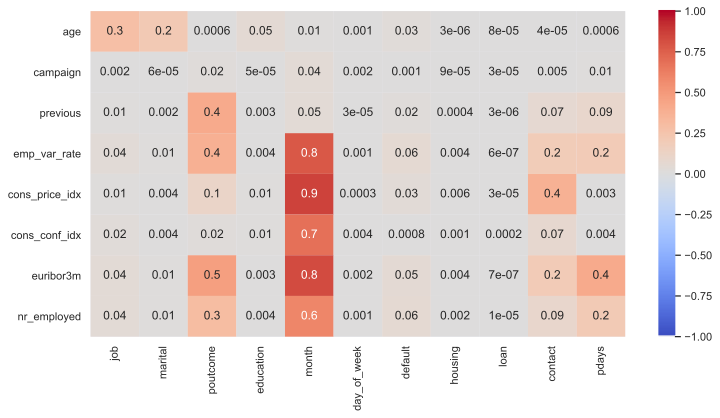

In [32]:
# вычисляем коэффициент eta для иземрения "корреляции" между количественными и категориальными признаками
quant_cat_corr = calculate_eta_corr(df_NaN, quantitative, cat)
sns.heatmap(quant_cat_corr, annot=True, fmt='.1g', vmin=-1, vmax=1, center=0, cmap= 'coolwarm')
# наблюдаем высокую корреляцию месяцев с месячными показателями


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


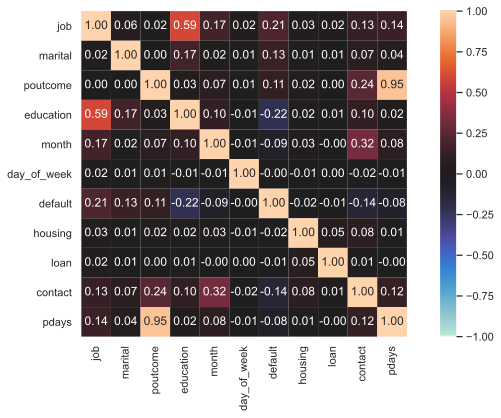

In [33]:
# вычисляем "корреляцию" между категориальными признакми, используя коэффицент неопределенности 
cat_cat_corr = associations(df_NaN[cat], theil_u=True)['corr']

In [34]:
# удаляем объекты с NaN для экономии времени,
# ввиду несовместимости работы GridSearch в паралельном режиме
# с MissForest и достаточно высоких временных затрат на заполнение пропусков MissForest,
# для осуществления предварительного быстрого выбора вариантов SMOTE и наборов признаков
# надеясь, что удаление небольшого процента данных не изменит ранг вариантов SMOTE
# по average_precision
train_dropna = pd.concat([X_train, y_train], axis=1)
train_dropna = train_dropna.dropna()
X_train_dropna =  train_dropna.loc[:, df_NaN.columns != 'y'] 
y_train_dropna = train_dropna.y

In [35]:
#получаем списки сильно коррелирующих функций
spearman_corr_features = get_high_corr_features(spearman_corr, 0.93) 
cat_cat_corr_features = get_high_corr_features(cat_cat_corr, 0.93)
quant_cat_corr_features =  get_high_corr_features(quant_cat_corr, 0.8, False)
all_corr_features = spearman_corr_features + cat_cat_corr_features + quant_cat_corr_features

# получаем индексы сильно коррелирующих признаков
spearman_corr_indexes = get_indexes_features(X_train_dropna, spearman_corr_features) 
cat_cat_corr_indexes = get_indexes_features(X_train_dropna, cat_cat_corr_features)
quant_cat_corr_indexes = get_indexes_features(X_train_dropna, quant_cat_corr_features)

# получаем индексы всех признаков без сильно коррелирующих
all_wo_corr_indexes = [X_train_dropna.columns.get_loc(column) for column 
                   in X_train_dropna.columns.difference(all_corr_features)]

# так как 'month' из quant_cat_corr_features коррелирует с 
# признаками 'emp_var_rate', 'euribor3m', 'nr_employed' из spearman_corr_features
# они входят в одну группу коррелирующих признаков
comb_group1 = get_all_combinations(spearman_corr_indexes + quant_cat_corr_indexes)
comb_group2 = get_all_combinations(cat_cat_corr_indexes)

# получаем список, состоящий из списков, каждый из которых
# состоит из индексов, среди которых есть хотя бы 1 индекс признака
# из каждой группы высоко коррелирующих признаков
# + индексы признаков, не входящие ни в одну из групп
corr_combinations = []
for comb1 in comb_group1:
    for comb2 in comb_group2:
        corr_combinations.append(comb1 + comb2 + all_wo_corr_indexes)

In [ ]:
# выбираем лучшие комбинации признаков
pipe_corr_col_selector = Pipeline([
    ('cat_encoder', NestedCVWrapper(CatBoostEncoder(handle_missing='return_nan'), random_state=SEED)),
    ('scaler', Scaler),
    ('column', ColumnSelector()),
    ('classifier', KNeighborsClassifier(n_jobs=-1))
    ])

param_grid_corr_col_selector = {
    'column__cols': corr_combinations, 
    'classifier': [KNeighborsClassifier(n_jobs=-1),
                   LogisticRegression(random_state=SEED)
                   LogisticRegression(random_state=SEED, C=100),
                   SVC(random_state=SEED), 
                   SVC(random_state=SEED, kernel = 'linear'),
                   LGBMClassifier(random_state=SEED), 
                   CatBoostClassifier(random_state=SEED), 
                   XGBClassifier(random_state=SEED), 
                   RandomForestClassifier(random_state=SEED, n_jobs=-1) 
                   ]
     }

SCORING = ['average_precision', 'roc_auc']

grid_corr_col_selector = GridSearchCV(pipe_corr_col_selector, param_grid_corr_col_selector, cv=5, 
                                      scoring=SCORING, refit='average_precision', n_jobs=-1, verbose=2) 
grid_corr_col_selector.fit(X_train_dropna, y_train_dropna)

get_grid_result(grid_corr_col_selector).to_excel('grid_corr_col_selector.xlsx')

In [37]:
# тюнить LGBMClassifier для Leshy будем на 
# лучшей по average precision комбинации признаков для 
# логистической регрессии, KNN, SVC с ядром rbf 
# из минимальных (когда в каждой коррелирующей группе остается по 1 признаку)
# для того, чтобы более точно оценить важность признаков
best_combination = [17, 11, 0, 10, 16, 15, 7, 9, 4, 3, 5, 1, 6, 2, 12]
best = [X_train_dropna.columns[i] for i in best_combination]
ord_bin_nan_index2 = [X_train[best].columns.get_loc(col) for col in ord_bin_nan]

pipe_lgbm_leshy = Pipeline([
    ('cat_encoder', NestedCVWrapper(CatBoostEncoder(handle_missing='return_nan'), random_state=SEED)),
    ('imputer', MissForest(random_state=SEED, n_estimators=25, max_features=5, min_samples_leaf=2)),
    ('classifier', LGBMClassifier(random_state=SEED))
    ]) 

param_lgbm_leshy = {
    'classifier__learning_rate': optuna.distributions.UniformDistribution(0.005, 0.3),                   
    'classifier__num_leaves': optuna.distributions.IntUniformDistribution(7, 200),   
    'classifier__lambda_l2': optuna.distributions.IntUniformDistribution(0, 15),
    'classifier__min_data_in_leaf': optuna.distributions.IntUniformDistribution(5, 175),    
    'classifier__subsample': optuna.distributions.UniformDistribution(0.5 ,1.0),
    'classifier__colsample_bytree': optuna.distributions.UniformDistribution(0.7, 1.0),
    'classifier__scale_pos_weight': optuna.distributions.IntUniformDistribution(1, 33, 2)
    }
optuna_search_lgbm_leshy = optuna.integration.OptunaSearchCV(pipe_lgbm_leshy, 
                                                             param_lgbm_leshy,
                                                             n_trials=40, 
                                                             random_state=SEED, 
                                                             n_jobs=-1,
                                                             scoring='average_precision')
optuna_search_lgbm_leshy.fit(X_train[best], y_train, imputer__cat_vars=ord_bin_nan_index2)

optuna_search_lgbm_leshy.trials_dataframe().sort_values(['value'], ascending = False).to_excel("LGBM_for_Leshy.xlsx")

OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.


[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Iteration: 1 / 100
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Iteration: 2 / 100
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Iteration: 3 / 100
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Iteration: 4 / 100
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Iteration: 5 / 100
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Iteration: 6 / 100
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Iteration: 7 / 100
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Iteration: 8 / 100
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Iteration: 9 / 100
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Iteration: 10 / 100
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Iteration: 11 / 100
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Iteration: 12 / 100
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Iteration: 13 / 100
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Iteration: 14 / 100
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Iteration: 15 / 100
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Iteration: 16 / 100
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Iteration: 17 / 100
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Iteration: 18 / 100
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Iteration: 19 / 100
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Iteration: 20 / 100
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Iteration: 21 / 100
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Iteration: 22 / 100
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Iteration: 23 / 100
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Iteration: 24 / 100
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Iteration: 25 / 100
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Iteration: 26 / 100
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Iteration: 27 / 100
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Iteration: 28 / 100
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Iteration: 29 / 100
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Iteration: 30 / 100
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Iteration: 31 / 100
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Iteration: 32 / 100


BorutaPy finished running using shap var. imp.

Iteration: 	33 / 100
Confirmed: 	11
Tentative: 	0
Rejected: 	4
All relevant predictors selected in 00:02:33.74
['euribor3m', 'pdays', 'age', 'campaign', 'cons_conf_idx', 'cons_price_idx', 'contact', 'day_of_week', 'default', 'job', 'previous']


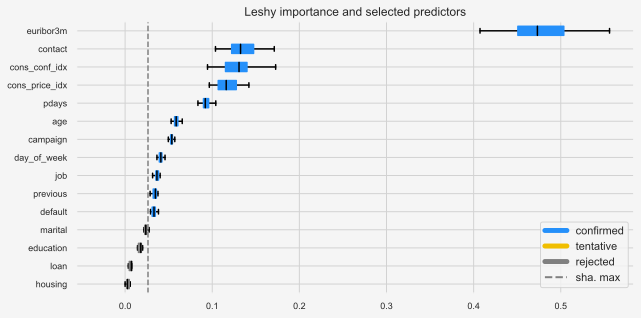

In [38]:
# используем лучшие гиперпараметры LGBMClassifier для Leshy

lgbm_leshy_best_params = optuna_search_LGBM_Leshy.best_params_
lgbm_leshy = LGBMClassifier(**lgbm_leshy_best_params)

feat_selector = arfsgroot.Leshy(lgbm_leshy, n_estimators=100, verbose=1, 
                                max_iter=100, random_state=SEED, importance='shap')
feat_selector.fit(X_train_eda[best], y_train)

print(feat_selector.support_names_)
feat_selector.plot_importance(n_feat_per_inch=3)

In [ ]:
# лучшие комбинации признаков по average_precision относительно коррелирующих признаков
best_comb_log_reg = [14, 17, 18, 8, 13, 11, 0, 10, 16, 15, 7, 9, 4, 3, 5, 1, 6, 2, 12]
best_comb_svc = [17, 11, 0, 10, 16, 15, 7, 9, 4, 3, 5, 1, 6, 2, 12]
best_comb_knn = [17, 18, 13, 11, 0, 10, 16, 15, 7, 9, 4, 3, 5, 1, 6, 2, 12]

# создаем список неважных признаков
unimportant_features = feat_selector.tag_df[feat_selector.tag_df.Boruta == 0].predictor.to_list()
unimportant_features_indexes = get_indexes_features(X_train_dropna, unimportant_features)
unimportant_features_indexes

# лучшие комбинации без неважных признаков
imp_comb_log_reg = [column for column in best_comb_log_reg 
                    if column not in unimportant_features_indexes]
imp_comb_svc = [column for column in best_comb_svc 
                if column not in unimportant_features_indexes]
imp_comb_knn = [column for column in best_comb_knn 
                if column not in unimportant_features_indexes]
unimp_combinations = all_combinations(unimportant_features_indexes, empty_combination = True)

imp_unimp_combs_log_reg = get_imp_unimp_combinations(unimp_combinations, imp_comb_log_reg)
imp_unimp_combs_svc = get_imp_unimp_combinations(unimp_combinations, imp_comb_svc)
imp_unimp_combs_knn = get_imp_unimp_combinations(unimp_combinations, imp_comb_knn)

In [ ]:
# выбираем лучшие комбинации для каждого из алгоритмов
pipe_imp_col_selector = Pipeline([
    ('cat_encoder', NestedCVWrapper(CatBoostEncoder(handle_missing='return_nan'), random_state=SEED)),
    ('scaler', Scaler),
    ('column', ColumnSelector()),
    ('classifier', KNeighborsClassifier(n_jobs=-1))
    ]) 

param_grid_imp_col_selector = [{'classifier': [KNeighborsClassifier(n_jobs=-1)],
                                'column__cols': imp_unimp_combs_knn},
                               {'classifier': [SVC(random_state=SEED)],
                                'column__cols': imp_unimp_combs_svc},
                               {'classifier': [LogisticRegression(random_state=SEED)],
                                'column__cols': imp_unimp_combs_log_reg}] 


grid_imp_col_selector = GridSearchCV(pipe_imp_col_selector, param_grid_imp_col_selector, cv=5, 
                                     scoring=SCORING, refit='average_precision', n_jobs=-1, verbose=2) 
grid_imp_col_selector.fit(X_train_dropna, y_train_dropna)

get_grid_result(grid_imp_col_selector).to_excel('grid_imp_col_selector.xlsx')
# лучшим для SVC является набор без 1 неважного признака
best_comb_SVC = (5, 6, 2, 17, 11, 0, 10, 16, 15, 7, 9, 4, 1, 12)
# лучшими наборами для KNN и log_reg являются наборы со всеми неважными признаками
best_comb_log_reg = (14, 17, 18, 8, 13, 11, 0, 10, 16, 15, 7, 9, 4, 3, 5, 1, 6, 2, 12)
best_comb_KNN = (17, 18, 13, 11, 0, 10, 16, 15, 7, 9, 4, 3, 5, 1, 6, 2, 12)

In [ ]:
# выбираем лучше удалять/не удалять выбросы из всей выборки или только отрицательного класса
pipe_reject_outliers = Pipeline([
    ('cat_encoder', NestedCVWrapper(CatBoostEncoder(handle_missing='return_nan'), random_state=SEED)),
    ('reject_outliers', FunctionSampler(func=reject_neg_class_outliers)),
    ('scaler', Scaler),
    ('classifier', KNeighborsClassifier(n_jobs=-1))
    ]) 

param_grid_reject_outliers = {
    'classifier': [KNeighborsClassifier(n_jobs=-1),
                   LogisticRegression(random_state=SEED),
                   SVC(random_state=SEED)],
    'reject_outliers': [FunctionSampler(func=reject_neg_class_outliers),
                        FunctionSampler(func=reject_outliers)],
    'reject_outliers__kw_args': [{'contamination': con} for con 
                                 in [0.0, 0.01, 0.02, 0.04, 0.08, 0.1]]
    }                

grid_reject_outliers = GridSearchCV(pipe_reject_outliers, param_grid_reject_outliers, cv=5, 
                                    scoring=SCORING, refit='average_precision', n_jobs=-1, verbose=2) 
grid_reject_outliers.fit(X_train_dropna, y_train_dropna) 

get_grid_result(grid_reject_outliers).to_excel('grid_reject_outliers.xlsx')

In [ ]:
# смотрим с каким вариантом SMOTE average_precision будет максимальна
pipe_smote_log_svc = Pipeline([
    ('cat_encoder', NestedCVWrapper(CatBoostEncoder(handle_missing='return_nan'), random_state=SEED)),
    ('scaler', Scaler),
    ('smote', sv.LVQ_SMOTE(random_state=SEED, n_jobs = -1)),
    ('classifier', LogisticRegression(random_state=SEED))
    ]) 

param_grid_smote_log_svc = {
    'classifier':[LogisticRegression(random_state=SEED), SVC(random_state=SEED)], 
    'smote': [sv.LVQ_SMOTE(random_state=SEED, n_jobs=-1), 
              sv.polynom_fit_SMOTE(random_state=SEED), 
              sv.ProWSyn(random_state=SEED),
              sv.SMOTE_IPF(random_state=SEED, n_jobs=-1), 
              sv.SMOBD(random_state=SEED, n_jobs=-1),
              sv.G_SMOTE(random_state=SEED, n_jobs=-1),
              sv.Supervised_SMOTE(random_state=SEED, n_jobs=-1),
              sv.DBSMOTE(random_state=SEED, n_jobs=-1),
              sv.CURE_SMOTE(random_state=SEED, n_jobs=-1),
              sv.DE_oversampling(random_state=SEED, n_jobs=-1),
              sv.CCR(random_state=SEED, n_jobs=-1)
              sv.NoSMOTE(random_state=SEED)],
    'smote__proportion': [0.25, 0.75]
    }

grid_smote_log_svc = GridSearchCV(pipe_smote_log_svc, param_grid_smote_log_svc, cv=5, scoring=SCORING,
                                  refit='average_precision', n_jobs=-1, verbose=2) 
grid_smote_log_svc.fit(X_train_dropna, y_train_dropna)

get_grid_result(grid_smote_log_svc).to_excel('grid_smote_log_svc.xlsx')

In [ ]:
pipe_smote_svc = Pipeline([
    ('cat_encoder', NestedCVWrapper(CatBoostEncoder(handle_missing='return_nan'), random_state=SEED)),
    ('scaler', Scaler),
    ('smote', sv.CE_SMOTE(random_state=SEED, n_jobs = -1)),
    ('classifier', SVC(cache_size=1900))
    ])

param_grid_smote_svc = {'smote': [sv.CE_SMOTE(random_state=SEED, n_jobs=-1),
                        sv.SMOTE_ENN(random_state=SEED, n_jobs=-1),
                        sv.MDO(random_state=SEED, n_jobs=-1),                        
                        sv.SMOTE_Cosine(random_state=SEED, n_jobs=-1)],
                        'smote__proportion': [0.25, 0.75]}

grid_smote_svc = GridSearchCV(pipe_smote_svc, param_grid_smote_svc, cv=5, scoring=SCORING,
                              refit='average_precision', n_jobs=-1, verbose=2) 
grid_smote_svc.fit(X_train_dropna, y_train_dropna)

get_grid_result(grid_smote_svc).to_excel('grid_smote_svc.xlsx')

In [ ]:
pipe_smote_log = Pipeline([
    ('cat_encoder', NestedCVWrapper(CatBoostEncoder(handle_missing='return_nan'), random_state=SEED)),
    ('scaler', Scaler),
    ('smote', sv.Gaussian_SMOTE(random_state=SEED, n_jobs=-1)),
    ('classifier', LogisticRegression(random_state=SEED))
    ]) 

param_grid_smote_log = {'smote': [sv.Gaussian_SMOTE(random_state=SEED, n_jobs=-1),
                                  sv.NEATER(random_state=SEED, n_jobs=-1),
                                  sv.DE_oversampling(random_state=SEED, n_jobs=-1),
                                  sv.NoSMOTE(random_state=SEED)],
                        'smote__proportion': [0.25, 0.75]}

grid_smote_log = GridSearchCV(pipe_smote_log, param_grid_smote_log, cv= 5, scoring=SCORING,
                              refit='average_precision', n_jobs=-1, verbose=2) 
grid_smote_log.fit(X_train_dropna, y_train_dropna)

get_grid_result(grid_smote_log).to_excel('grid_smote_log.xlsx')

In [ ]:
pipe_smote_knn = Pipeline([
    ('cat_encoder', NestedCVWrapper(CatBoostEncoder(handle_missing='return_nan'), random_state=SEED)),                  
    ('scaler', Scaler),
    ('smote', sv.LVQ_SMOTE(random_state=SEED, n_jobs = -1)),
    ('classifier', KNeighborsClassifier(n_jobs=-1))
    ])

param_grid_smote_knn = {
    'smote': [sv.LVQ_SMOTE(random_state=SEED, n_jobs=-1), 
              sv.polynom_fit_SMOTE(random_state=SEED), 
              sv.ProWSyn(random_state=SEED),
              sv.SMOTE_IPF(random_state=SEED, n_jobs=-1), 
              sv.SMOBD(random_state=SEED, n_jobs=-1), 
              sv.G_SMOTE(random_state=SEED, n_jobs=-1),
              sv.Supervised_SMOTE(random_state=SEED, n_jobs=-1),
              sv.AHC(random_state=SEED),
              sv.Assembled_SMOTE(random_state=SEED, n_jobs=-1), 
              sv.CCR(random_state=SEED, n_jobs=-1), 
              sv.DE_oversampling(random_state=SEED, n_jobs=-1),
              sv.NoSMOTE(random_state=SEED), 
              sv.CE_SMOTE(random_state=SEED, n_jobs=-1),
              sv.LLE_SMOTE(random_state=SEED, n_jobs=-1),
              sv.Gaussian_SMOTE(random_state=SEED, n_jobs=-1),
              sv.Borderline_SMOTE1(random_state=SEED, n_jobs=-1),
              sv.SMOTE_ENN(random_state=SEED, n_jobs=-1),
              sv.SMOTE_TomekLinks(random_state=SEED, n_jobs=-1)],
    'smote__proportion': [0.25, 0.75]
    }

grid_smote_knn = GridSearchCV(pipe_knn, param_grid_smote_knn, cv=5, scoring=SCORING, 
                              refit='average_precision', n_jobs=-1, verbose=2) 
grid_smote_knn.fit(X_train_dropna, y_train_dropna)

get_grid_result(grid_smote_knn).to_excel('grid_smote_knn.xlsx')

In [ ]:
pipe_boost_rf = Pipeline([
    ('cat_encoder', NestedCVWrapper(CatBoostEncoder(handle_missing='return_nan'), random_state=SEED)),                  
    ('scaler', Scaler),
    ('smote', sv.LVQ_SMOTE(random_state=SEED, n_jobs = -1)),
    ('classifier', LGBMClassifier(random_state=SEED))
    ])

param_grid_boost_rf = {
    'classifier':[LGBMClassifier(random_state=SEED),
                  CatBoostClassifier(random_state=SEED),
                  XGBClassifier(random_state=SEED),
                  RandomForestClassifier(random_state=SEED, n_jobs=-1)], 
    'smote':[sv.LVQ_SMOTE(random_state=SEED, n_jobs=-1),
             sv.Borderline_SMOTE2(random_state=SEED, n_jobs=-1),
             sv.SMOBD(random_state=SEED, n_jobs=-1),
             sv.ProWSyn(random_state=SEED),             
             sv.polynom_fit_SMOTE(random_state=SEED),
             sv.DE_oversampling(random_state=SEED, n_jobs=-1),
             sv.NoSMOTE(random_state=SEED)], 
    'smote__proportion': [0.25, 0.75]
    } 

grid_boost_rf = GridSearchCV(pipe_boost_rf, param_grid_boost_rf, cv5, scoring=SCORING,
                             refit='average_precision', n_jobs=-1, verbose=2) 
grid_boost_rf.fit(X_train_dropna, y_train_dropna) 

get_grid_result(grid_boost_rf).to_excel('grid_boost_rf.xlsx')

In [ ]:
# далее тюним гиперпараметры для конечных моделей
# opt_comb - это индексы наборов признаков, среди которых
# один набор всегда все признаки датасета, другие  - лучшие наборы
# по average_precision по результатам предварительного тюнинга
opt_comb_log_reg = [[14, 17, 18, 8, 13, 11, 0, 10, 16, 15, 7, 9, 4, 3, 5, 1, 6, 2, 12],
                    [14, 17, 8, 13, 11, 0, 10, 16, 15, 7, 9, 4, 3, 5, 1, 6, 2, 12]] 

pipe_log_reg = Pipeline([
    ('cat_encoder', NestedCVWrapper(CatBoostEncoder(handle_missing='return_nan'), random_state=SEED)),    
    ('imputer', MissForest(random_state=SEED, n_estimators=25, max_features=5, min_samples_leaf=2)),                   
    ('reject_outliers', FunctionSampler(func=reject_neg_class_outliers)), 
    ('scaler', Scaler),
    ('column_selector', ColumnSelector()),    
    ('classifier', LogisticRegression(random_state=SEED, n_jobs =-1))
    ]) 

param_log_reg = {
    'classifier__solver': optuna.distributions.CategoricalDistribution(['newton-cg', 'lbfgs', 
                                                                        'liblinear', 'sag', 
                                                                        'saga']),
    'classifier__C': optuna.distributions.LogUniformDistribution(1e-3, 1e3),
    'classifier__class_weight': optuna.distributions.CategoricalDistribution([{0: 1, 1: w} for w 
                                                                              in[1, 2, 4, 8, 12, 16, 24, 32]]),
    'reject_outliers__kw_args': optuna.distributions.CategoricalDistribution([{'contamination': con} for con 
                                                                              in [0.00, 0.01, 0.02, 0.03, 0.04]]),
    'column_selector__cols': optuna.distributions.CategoricalDistribution(opt_comb_log_reg)
    }
optuna_search_log_reg = optuna.integration.OptunaSearchCV(pipe_log_reg, param_log_reg, n_trials=2,
                                                          random_state=SEED, n_jobs=-1,
                                                          scoring='average_precision')
optuna_search_log_reg.fit(X_train, y_train, imputer__cat_vars=ord_bin_nan_indexes)

optuna_search_log_reg.trials_dataframe().sort_values(['value'], ascending=False).to_excel("Hyper_log_reg.xlsx")
optuna_search_log_reg.best_params_

In [ ]:
# обучение svc было остановлено на 27 итерации из 60
# ввиду очень длительного времени обучения
opt_comb_svc = [[14, 17, 18, 8, 13, 11, 0, 10, 16, 15, 7, 9, 4, 3, 5, 1, 6, 2, 12],
                [17, 11, 0, 10, 16, 15, 7, 9, 4, 3, 5, 1, 6, 2, 12],
                [5, 6, 2, 17, 11, 0, 10, 16, 15, 7, 9, 4, 1, 12]]

pipe_svc = Pipeline([
    ('cat_encoder', NestedCVWrapper(CatBoostEncoder(handle_missing='return_nan'), random_state=SEED)),    
    ('imputer', MissForest(random_state=SEED, n_estimators=25, max_features=5, min_samples_leaf=2)),                   
    ('reject_outliers', FunctionSampler(func=reject_neg_class_outliers)), 
    ('scaler', Scaler),
    ('column_selector', ColumnSelector()),                
    ('smote', sv.SMOTE_ENN(random_state=SEED, n_jobs=-1)),                   
    ('classifier', SVC())
    ])

param_svc = {
    'classifier__kernel': optuna.distributions.CategoricalDistribution(['rbf', 'poly', 'sigmoid']),
    'classifier__gamma': optuna.distributions.LogUniformDistribution(1e-3, 1e3),
    'classifier__C': optuna.distributions.LogUniformDistribution(1e-3, 1e3),
    'classifier__class_weight': optuna.distributions.CategoricalDistribution([{0: 1, 1: w} for w
                                                                              in[1, 2, 4, 8, 12, 16, 24, 32]]),
    'reject_outliers__kw_args': optuna.distributions.CategoricalDistribution([{'contamination': con} for con
                                                                               in [0.00, 0.01, 0.02, 0.03, 0.04]]),
    'smote__proportion': optuna.distributions.UniformDistribution(0.1269, 1.5),    
    'smote__n_neighbors': optuna.distributions.IntUniformDistribution(3, 27, 2),
    'column_selector__cols': optuna.distributions.CategoricalDistribution(opt_comb_svc)
    }
optuna_search_svc = optuna.integration.OptunaSearchCV(pipe_svc, param_svc, n_trials=60,
                                                      random_state=SEED, n_jobs =-1,
                                                      scoring='average_precision')
optuna_search_svc.fit(X_train, y_train, imputer__cat_vars=ord_bin_nan_indexes)

optuna_search_svc.trials_dataframe().sort_values(['value'], ascending=False).to_excel("Hyper_SVC.xlsx")
optuna_search_svc.best_params_

In [ ]:
opt_comb_knn = [[17, 18, 13, 11, 0, 10, 16, 15, 7, 9, 4, 3, 5, 1, 6, 2, 12],
                [14, 17, 18, 8, 13, 11, 0, 10, 16, 15, 7, 9, 4, 3, 5, 1, 6, 2, 12]]

pipe_knn = Pipeline([
    ('cat_encoder', NestedCVWrapper(CatBoostEncoder(handle_missing='return_nan'), random_state=SEED)),    
    ('imputer', MissForest(random_state=SEED, n_estimators=25, max_features=5, min_samples_leaf=2)),                   
    ('reject_outliers', FunctionSampler(func=reject_neg_class_outliers)), 
    ('scaler', Scaler),
    ('column_selector', ColumnSelector()),                
    ('smote', sv.polynom_fit_SMOTE(random_state=SEED)),        
    ('classifier', KNeighborsClassifier(n_jobs=-1))
    ]) 

param_knn = {
    'classifier__n_neighbors': optuna.distributions.IntUniformDistribution(1, 31, 2),
    'classifier__p': optuna.distributions.IntUniformDistribution(1, 2),
    'classifier__weights': optuna.distributions.CategoricalDistribution(['uniform', 'distance']),
    'reject_outliers__kw_args': optuna.distributions.CategoricalDistribution(
        [{'contamination': con} for con in [0.00, 0.01, 0.02, 0.03, 0.04, 0.06, 0.08]]),
    'reject_outliers__kw_args': optuna.distributions.CategoricalDistribution(
        [{'max_samples': maxs} for maxs in [128, 256, 512]]),
    'reject_outliers__kw_args': optuna.distributions.CategoricalDistribution(
        [{'n_estimators': 100}, {'n_estimators': 200}]),
    'smote__proportion': optuna.distributions.UniformDistribution(0.1269, 1.5),    
    'smote__topology': optuna.distributions.CategoricalDistribution(['star', 'mesh', 'poly_1', 
                                                                     'poly_2', 'poly_3']),
    'column_selector__cols': optuna.distributions.CategoricalDistribution(opt_comb_knn)
    }
optuna_search_knn = optuna.integration.OptunaSearchCV(pipe_knn, param_knn, n_trials=60,
                                                      random_state=SEED, n_job=-1,
                                                      scoring='average_precision')
optuna_search_knn.fit(X_train, y_train, imputer__cat_vars=ord_bin_nan_indexes)

optuna_search_knn.trials_dataframe().sort_values(['value'], ascending=False).to_excel("Hyper_KNN.xlsx")
optuna_search_knn.best_params_

In [ ]:
opt_comb_rf = [[17, 18, 8, 13, 11, 0, 10, 16, 15, 7, 9, 4, 3, 5, 1, 6, 2, 12],
               [14, 17, 18, 8, 13, 11, 0, 10, 16, 15, 7, 9, 4, 3, 5, 1, 6, 2, 12]]

pipe_rf = Pipeline([
    ('cat_encoder', NestedCVWrapper(CatBoostEncoder(handle_missing='return_nan'), random_state=SEED)),    
    ('imputer', MissForest(random_state=SEED, n_estimators=25, max_features=5, min_samples_leaf=2)),
    ('reject_outliers', FunctionSampler(func=reject_neg_class_outliers)), 
    ('scaler', Scaler),
    ('column_selector', ColumnSelector()),
    ('smote', sv.polynom_fit_SMOTE(random_state=SEED)),                   
    ('classifier', RandomForestClassifier(random_state=SEED, n_jobs=-1))
    ])

param_rf = {
    "classifier__max_features": optuna.distributions.IntUniformDistribution(4, 8),
    "classifier__n_estimators": optuna.distributions.IntUniformDistribution(100, 600),
    "classifier__criterion": optuna.distributions.CategoricalDistribution(['gini', 'entropy']),
    "classifier__bootstrap": optuna.distributions.CategoricalDistribution([True, False]),
    "classifier__max_samples": optuna.distributions.UniformDistribution(0.2 ,1.0), 
    "classifier__min_samples_leaf": optuna.distributions.IntUniformDistribution(1, 8),
    "classifier__class_weight": optuna.distributions.CategoricalDistribution(
        [{0: 1, 1 : w} for w in[1, 2, 4, 8, 12, 16, 24, 32]]),
    'reject_outliers__kw_args': optuna.distributions.CategoricalDistribution(
        [{'contamination': con} for con in [0.0, 0.01, 0.02, 0.03, 0.04]]),    
    'smote__proportion': optuna.distributions.UniformDistribution(0.1269, 1.5),    
    'smote__topology': optuna.distributions.CategoricalDistribution(['star', 'mesh', 'poly_1',
                                                                     'poly_2', 'poly_3']),
    'column_selector__cols': optuna.distributions.CategoricalDistribution(opt_comb_rf)
    } 


optuna_search_rf = optuna.integration.OptunaSearchCV(pipe_rf, param_rf, n_trials=90,
                                                     random_state=SEED, n_jobs=-1,
                                                     scoring='average_precision')
optuna_search_rf.fit(X_train, y_train, imputer__cat_vars=ord_bin_nan_indexes)

optuna_search_rf.trials_dataframe().sort_values(['value'], ascending=False).to_excel("Hyper_RF.xlsx")
optuna_search_rf.best_params_

In [ ]:
opt_comb_cat = [[14, 17, 18, 8, 13, 11, 0, 10, 16, 15, 7, 9, 4, 3, 5, 1, 6, 2, 12],
                [14, 17, 13, 11, 0, 10, 16, 15, 7, 9, 4, 3, 5, 1, 6, 2, 12]]

pipe_cat = Pipeline([
    ('cat_encoder', NestedCVWrapper(CatBoostEncoder(handle_missing='return_nan'), random_state=SEED)),    
    ('imputer', MissForest(random_state=SEED, n_estimators=25, max_features=5, min_samples_leaf=2)),
    ('reject_outliers', FunctionSampler(func=reject_neg_class_outliers)), 
    ('scaler', Scaler),
    ('column_selector', ColumnSelector()),
    ('smote', sv.polynom_fit_SMOTE(random_state=SEED)),                   
    ('classifier', CatBoostClassifier(n_estimators=1000, random_state=SEED))
    ]) 

param_cat = {
    'classifier__learning_rate' : optuna.distributions.UniformDistribution(0.005, 0.2),                   
    'classifier__max_depth': optuna.distributions.IntUniformDistribution(3, 10),   
    'classifier__l2_leaf_reg': optuna.distributions.IntUniformDistribution(1, 30),
    'classifier__bagging_temperature': optuna.distributions.DiscreteUniformDistribution(0.2, 50, 0.2),
    'classifier__random_strength': optuna.distributions.DiscreteUniformDistribution(0.0, 10, 0.2),
    'classifier__rsm': optuna.distributions.UniformDistribution(0.7 ,1.0), 
    'classifier__scale_pos_weight': optuna.distributions.IntUniformDistribution(1, 33, 2),
    'reject_outliers__kw_args': optuna.distributions.CategoricalDistribution(
        [{'contamination': con} for con in [0.0, 0.01, 0.02, 0.03, 0.04]]),
    'smote__proportion': optuna.distributions.UniformDistribution(0.1269, 1.5),    
    'smote__topology': optuna.distributions.CategoricalDistribution(['star', 'mesh', 'poly_1',
                                                                     'poly_2', 'poly_3']),
    'column_selector__cols': optuna.distributions.CategoricalDistribution(opt_comb_cat)
    }
optuna_search_cat = optuna.integration.OptunaSearchCV(pipe_cat, param_cat, n_trials=90,
                                                      random_state=SEED, n_jobs=-1,
                                                      scoring='average_precision')
optuna_search_cat.fit(X_train, y_train, imputer__cat_vars = ord_bin_nan_indexes)    

optuna_search_cat.trials_dataframe().sort_values(['value'], ascending=False).to_excel("Hyper_Cat.xlsx")
optuna_search_cat.best_params_

In [ ]:
# ниже визцализация гиперпараметров и average_precision 
plot_optimization_history(optuna_search_RF.study_)

In [ ]:
plot_param_importances(optuna_search_RF.study_, params=["classifier__max_features",
                                                        "classifier__n_estimators",
                                                        "classifier__criterion",
                                                        "classifier__bootstrap",
                                                        "classifier__max_samples",
                                                        "classifier__min_samples_leaf",
                                                        "classifier__class_weight", 
                                                        'smote__proportion',
                                                        'smote__n_neighbors',
                                                        'smote__n_clusters'])

In [ ]:
fig = plot_contour(optuna_search_RF.study_, params=['smote__proportion',
                                                    'smote__n_clusters',
                                                    'smote__n_neighbors',
                                                    'classifier__class_weight'])    
fig.update_layout(
    autosize=False,
    width=1000,
    height=1000    
)

In [ ]:
plot_parallel_coordinate(optuna_search_RF.study_, params=['smote__proportion',
                                                          'smote__n_clusters',
                                                          'smote__n_neighbors',
                                                          'classifier__max_features'])

In [ ]:
opt_comb_lgbm = [[14, 17, 18, 8, 13, 11, 0, 10, 16, 15, 7, 9, 4, 3, 5, 1, 6, 2, 12],
            [14, 17, 13, 11, 0, 10, 16, 15, 7, 9, 4, 3, 5, 1, 6, 2, 12]]

pipe_lgbm = Pipeline([
    ('cat_encoder', NestedCVWrapper(CatBoostEncoder(handle_missing='return_nan'), random_state=SEED)),    
    ('imputer', MissForest(random_state=SEED, n_estimators=25, max_features=5, min_samples_leaf=2)),
    ('reject_outliers', FunctionSampler(func=reject_neg_class_outliers)), 
    ('scaler', Scaler),
    ('column_selector', ColumnSelector()),
    ('smote', sv.LVQ_SMOTE(random_state=SEED, n_jobs=-1)),                   
    ('classifier', LGBMClassifier(n_estimators=1000, random_state=SEED))
    ]) 

param_lgbm = {
    'classifier__learning_rate': optuna.distributions.UniformDistribution(0.005, 0.2),                   
    'classifier__num_leaves': optuna.distributions.IntUniformDistribution(7, 200),   
    'classifier__lambda_l2': optuna.distributions.IntUniformDistribution(0, 15),
    'classifier__min_data_in_leaf': optuna.distributions.IntUniformDistribution(5, 175),    
    'classifier__subsample': optuna.distributions.UniformDistribution(0.5 ,1.0),
    'classifier__colsample_bytree': optuna.distributions.UniformDistribution(0.7, 1.0),
    'classifier__scale_pos_weight': optuna.distributions.IntUniformDistribution(1, 33, 2),
    'reject_outliers__kw_args': optuna.distributions.CategoricalDistribution(
        [{'contamination': con} for con in [0.0, 0.01, 0.02, 0.03, 0.04]]),
    'smote__proportion': optuna.distributions.UniformDistribution(0.1269, 1.5),
    'smote__n_neighbors': optuna.distributions.IntUniformDistribution(3, 11, 2),
    'smote__n_clusters': optuna.distributions.IntUniformDistribution(3, 17),
    'column_selector__cols': optuna.distributions.CategoricalDistribution(opt_comb_lgbm)    
    }

%time optuna_search_lgbm = optuna.integration.OptunaSearchCV(pipe_lgbm, param_lgbm, n_trials=90,
                                                             random_state=SEED, n_jobs=-1,
                                                             scoring= 'average_precision')
optuna_search_lgbm.fit(X_train, y_train, imputer__cat_vars=ord_bin_nan_indexes) 

optuna_search_lgbm.trials_dataframe().sort_values(['value'], ascending=False).to_excel("Hyper_LGBM.xlsx")
optuna_search_lgbm.best_params_

In [ ]:
opt_comb_xgb = [[14, 17, 18, 8, 13, 11, 0, 10, 16, 15, 7, 9, 4, 3, 5, 1, 6, 2, 12],
                [17, 18, 8, 13, 11, 0, 10, 16, 15, 7, 9, 4, 3, 5, 1, 6, 2, 12]]

pipe_xgb = Pipeline([
    ('cat_encoder', NestedCVWrapper(CatBoostEncoder(handle_missing='return_nan'), random_state=SEED)),    
    ('imputer', MissForest(random_state=SEED, n_estimators=25, max_features=5, min_samples_leaf=2)),
    ('reject_outliers', FunctionSampler(func=reject_neg_class_outliers)), 
    ('scaler', Scaler),
    ('column_selector', ColumnSelector()),
    ('smote', sv.polynom_fit_SMOTE(random_state=SEED)),                   
    ('classifier', XGBClassifier(n_estimators=1000, random_state=SEED))
    ])           

param_xgb = {
    'classifier__learning_rate' : optuna.distributions.UniformDistribution(0.005, 0.2),                   
    'classifier__max_depth': optuna.distributions.IntUniformDistribution(3, 10),   
    'classifier__lambda': optuna.distributions.IntUniformDistribution(0, 15),
    'classifier__min_child_weight': optuna.distributions.UniformDistribution(0.5, 40),    
    'classifier__subsample': optuna.distributions.UniformDistribution(0.5 ,1.0),
    'classifier__colsample_bytree': optuna.distributions.UniformDistribution(0.7, 1.0),
    'classifier__scale_pos_weight': optuna.distributions.IntUniformDistribution(1, 33, 2),
    'reject_outliers__kw_args': optuna.distributions.CategoricalDistribution(
        [{'contamination': con} for con in [0.0, 0.01, 0.02, 0.03, 0.04]]),        
    'smote__proportion': optuna.distributions.UniformDistribution(0.1269, 1.5),    
    'smote__topology': optuna.distributions.CategoricalDistribution(['star', 'mesh', 'poly_1', 
                                                                     'poly_2', 'poly_3']),
    'column_selector__cols': optuna.distributions.CategoricalDistribution(opt_comb_xgb)
    }

optuna_search_xgb = optuna.integration.OptunaSearchCV(pipe_xgb, param_xgb, n_trials=90,
                                                      random_state=SEED, n_jobs=-1, 
                                                      scoring= 'average_precision')
%time optuna_search_xgb.fit(X_train, y_train, imputer__cat_vars=ord_bin_nan_indexes)

optuna_search_xgb.trials_dataframe().sort_values(['value'], ascending=False).to_excel("Hyper_XGB.xlsx")
optuna_search_xgb.best_params_

In [20]:
# все пайплайны и лучшие параметры для каждого пайплайна
pipe_log_reg = Pipeline([
    ('cat_encoder', NestedCVWrapper(CatBoostEncoder(handle_missing='return_nan'), random_state=SEED)),    
    ('imputer', MissForest(random_state=SEED, n_estimators=25, max_features=5, min_samples_leaf=2)),                   
    ('reject_outliers', FunctionSampler(func=reject_neg_class_outliers)), 
    ('scaler', Scaler),
    ('column_selector', ColumnSelector()),    
    ('classifier', LogisticRegression(random_state=SEED, n_jobs =-1))
    ]) 

pipe_svc = Pipeline([
    ('cat_encoder', NestedCVWrapper(CatBoostEncoder(handle_missing='return_nan'), random_state=SEED)),    
    ('imputer', MissForest(random_state=SEED, n_estimators=25, max_features=5, min_samples_leaf=2)),                   
    ('reject_outliers', FunctionSampler(func=reject_neg_class_outliers)), 
    ('scaler', Scaler),
    ('column_selector', ColumnSelector()),                
    ('smote', sv.SMOTE_ENN(random_state=SEED, n_jobs=-1)),                   
    ('classifier', SVC())
    ])

pipe_knn = Pipeline([
    ('cat_encoder', NestedCVWrapper(CatBoostEncoder(handle_missing='return_nan'), random_state=SEED)),    
    ('imputer', MissForest(random_state=SEED, n_estimators=25, max_features=5, min_samples_leaf=2)),                   
    ('reject_outliers', FunctionSampler(func=reject_neg_class_outliers)), 
    ('scaler', Scaler),
    ('column_selector', ColumnSelector()),                
    ('smote', sv.polynom_fit_SMOTE(random_state=SEED)),        
    ('classifier', KNeighborsClassifier(n_jobs=-1))
    ])

pipe_rf = Pipeline([
    ('cat_encoder', NestedCVWrapper(CatBoostEncoder(handle_missing='return_nan'), random_state=SEED)),    
    ('imputer', MissForest(random_state=SEED, n_estimators=25, max_features=5, min_samples_leaf=2)),
    ('reject_outliers', FunctionSampler(func=reject_neg_class_outliers)), 
    ('scaler', Scaler),
    ('column_selector', ColumnSelector()),
    ('smote', sv.polynom_fit_SMOTE(random_state=SEED)),                   
    ('classifier', RandomForestClassifier(random_state=SEED, n_jobs=-1))
    ])

pipe_cat = Pipeline([
    ('cat_encoder', NestedCVWrapper(CatBoostEncoder(handle_missing='return_nan'), random_state=SEED)),    
    ('imputer', MissForest(random_state=SEED, n_estimators=25, max_features=5, min_samples_leaf=2)),
    ('reject_outliers', FunctionSampler(func=reject_neg_class_outliers)), 
    ('scaler', Scaler),
    ('column_selector', ColumnSelector()),
    ('smote', sv.polynom_fit_SMOTE(random_state=SEED)),                   
    ('classifier', CatBoostClassifier(n_estimators=1000, random_state=SEED))
    ]) 

pipe_lgbm = Pipeline([
    ('cat_encoder', NestedCVWrapper(CatBoostEncoder(handle_missing='return_nan'), random_state=SEED)),    
    ('imputer', MissForest(random_state=SEED, n_estimators=25, max_features=5, min_samples_leaf=2)),
    ('reject_outliers', FunctionSampler(func=reject_neg_class_outliers)), 
    ('scaler', Scaler),
    ('column_selector', ColumnSelector()),
    ('smote', sv.LVQ_SMOTE(random_state=SEED, n_jobs=-1)),                   
    ('classifier', LGBMClassifier(n_estimators=1000, random_state=SEED))
    ]) 

pipe_xgb = Pipeline([
    ('cat_encoder', NestedCVWrapper(CatBoostEncoder(handle_missing='return_nan'), random_state=SEED)),    
    ('imputer', MissForest(random_state=SEED, n_estimators=25, max_features=5, min_samples_leaf=2)),
    ('reject_outliers', FunctionSampler(func=reject_neg_class_outliers)), 
    ('scaler', Scaler),
    ('column_selector', ColumnSelector()),
    ('smote', sv.polynom_fit_SMOTE(random_state=SEED)),                   
    ('classifier', XGBClassifier(n_estimators=1000, random_state=SEED))
    ])  

log_reg = {'classifier__C': 0.209261731596304,
'classifier__class_weight':{0: 1, 1: 1},
'classifier__solver': 'liblinear',
'column_selector__cols': (14, 17, 18, 8, 13, 11, 0, 10, 16, 15, 7, 9, 4, 3, 5, 1, 6, 2, 12),
'reject_outliers__kw_args':{'contamination': 0.02}}

# обучение svc было остановлено на 27 итерации из 60
# ввиду очень длительного времени обучения
# это лучшие параметры по итогу 27 итераций
svc = {'classifier__kernel': 'poly', 
'classifier__gamma': 9.177188150921296, 
'classifier__C': 0.0035624340456710474, 
'classifier__class_weight': {0: 1, 1: 4}, 
'reject_outliers__kw_args': {'contamination': 0.03}, 
'smote__proportion': 0.33547381102012774, 
'smote__n_neighbors': 5, 
'column_selector__cols': (17, 11, 0, 10, 16, 15, 7, 9, 4, 3, 5, 1, 6, 2, 12)}


knn = {'classifier__n_neighbors': 31,
 'classifier__p': 1,
 'classifier__weights': 'uniform',
 'reject_outliers__kw_args': {'n_estimators': 100},
 'smote__proportion': 0.6854375019617758,
 'smote__topology': 'poly_1',
 'column_selector__cols': (17, 18, 13, 11, 0, 10, 16, 15, 7, 9, 4, 3, 5, 1, 6, 2, 12)}


rf = {'classifier__max_features': 5,
 'classifier__n_estimators': 568,
 'classifier__criterion': 'gini',
 'classifier__bootstrap': True,
 'classifier__max_samples': 0.3763813382878065,
 'classifier__min_samples_leaf': 5,
 'classifier__class_weight': {0: 1, 1: 24},
 'reject_outliers__kw_args': {'contamination': 0.01},
 'smote__proportion': 0.36660330414955,
 'smote__topology': 'poly_2',
 'column_selector__cols': (17, 18, 8, 13, 11, 0, 10, 16, 15, 7, 9, 4, 3, 5, 1, 6, 2, 12)}


cat = {'classifier__learning_rate': 0.03881187434659765,
 'classifier__max_depth': 3,
 'classifier__l2_leaf_reg': 25,
 'classifier__bagging_temperature': 31.400000000000002,
 'classifier__random_strength': 3.8000000000000003,
 'classifier__rsm': 0.734519866165844,
 'classifier__scale_pos_weight': 3,
 'reject_outliers__kw_args': {'contamination': 0.0},
 'smote__proportion': 0.1333872731877877,
 'smote__topology': 'star',
 'column_selector__cols': (14, 17, 13, 11, 0, 10, 16, 15, 7, 9, 4, 3, 5, 1, 6, 2, 12)}


lgbm = {'classifier__learning_rate': 0.01358112662653318,
 'classifier__num_leaves': 35,
 'classifier__lambda_l2': 4,
 'classifier__min_data_in_leaf': 35,
 'classifier__subsample': 0.5403335513789371,
 'classifier__colsample_bytree': 0.701372960674491,
 'classifier__scale_pos_weight': 29,
 'reject_outliers__kw_args': {'contamination': 0.01},
 'smote__proportion': 1.0837182125082963,
 'smote__n_neighbors': 11,
 'smote__n_clusters': 15,
 'column_selector__cols': (14, 17, 18, 8, 13, 11, 0, 10, 16, 15, 7, 9, 4, 3, 5, 1, 6, 2, 12)}


xgb = {'classifier__learning_rate': 0.02127968419934923,
 'classifier__max_depth': 3,
 'classifier__lambda': 11,
 'classifier__min_child_weight': 18.721004255101306,
 'classifier__subsample': 0.9492285431239548,
 'classifier__colsample_bytree': 0.958879066205903,
 'classifier__scale_pos_weight': 11,
 'reject_outliers__kw_args': {'contamination': 0.0},
 'smote__proportion': 1.45813336459613,
 'smote__topology': 'poly_3',
 'column_selector__cols': (17, 18, 8, 13, 11, 0, 10, 16, 15, 7, 9, 4, 3, 5, 1, 6, 2, 12)}

pipelines = [pipe_log_reg, pipe_knn, pipe_rf, pipe_cat, pipe_lgbm, pipe_xgb]
parameters = [log_reg, knn, rf, cat, lgbm, xgb]
classifier_names = ['log_reg', 'knn', 'rf', 'cat', 'lgbm', 'xgb']

In [21]:
# обучаем модели с лучшими параметрами для рассчета average precision
# и построения в дальнейшим графиков Precision Recall кривых
test_precision = []
test_recall  = []
test_ap = []

for pipeline, parameter in zip (pipelines, parameters):             
    pipeline.set_params(**parameter)
    pipeline.fit(X_train, y_train, imputer__cat_vars=ord_bin_nan_indexes)    
    
    y_proba = pipeline.predict_proba(X_test)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)    
    ap = average_precision_score(y_test, y_proba)
        
    test_precision.append(precision)
    test_recall.append(recall)
    test_ap.append(ap)

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-14 23:53:20,564:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.6854375019617758, 'topology': 'poly_1', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-14 23:53:48,367:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.36660330414955, 'topology': 'poly_2', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-14 23:54:18,073:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.1333872731877877, 'topology': 'star', 'random_state': 42}")


0:	learn: 0.6638643	total: 152ms	remaining: 2m 31s
1:	learn: 0.6361285	total: 163ms	remaining: 1m 21s
2:	learn: 0.6117327	total: 173ms	remaining: 57.5s
3:	learn: 0.5919402	total: 184ms	remaining: 45.7s
4:	learn: 0.5723653	total: 195ms	remaining: 38.8s
5:	learn: 0.5545403	total: 207ms	remaining: 34.2s
6:	learn: 0.5389425	total: 218ms	remaining: 30.9s
7:	learn: 0.5232875	total: 229ms	remaining: 28.4s
8:	learn: 0.5057348	total: 242ms	remaining: 26.6s
9:	learn: 0.4938534	total: 266ms	remaining: 26.3s
10:	learn: 0.4845449	total: 277ms	remaining: 24.9s
11:	learn: 0.4754957	total: 295ms	remaining: 24.3s
12:	learn: 0.4684148	total: 305ms	remaining: 23.1s
13:	learn: 0.4609063	total: 315ms	remaining: 22.2s
14:	learn: 0.4539018	total: 325ms	remaining: 21.4s
15:	learn: 0.4474750	total: 335ms	remaining: 20.6s
16:	learn: 0.4419549	total: 346ms	remaining: 20s
17:	learn: 0.4365034	total: 357ms	remaining: 19.5s
18:	learn: 0.4294001	total: 375ms	remaining: 19.3s
19:	learn: 0.4253964	total: 387ms	remaini

161:	learn: 0.3594217	total: 2.37s	remaining: 12.3s
162:	learn: 0.3591103	total: 2.38s	remaining: 12.2s
163:	learn: 0.3590733	total: 2.4s	remaining: 12.3s
164:	learn: 0.3590571	total: 2.42s	remaining: 12.2s
165:	learn: 0.3590098	total: 2.43s	remaining: 12.2s
166:	learn: 0.3588814	total: 2.45s	remaining: 12.2s
167:	learn: 0.3588273	total: 2.47s	remaining: 12.2s
168:	learn: 0.3587852	total: 2.48s	remaining: 12.2s
169:	learn: 0.3586638	total: 2.49s	remaining: 12.2s
170:	learn: 0.3586399	total: 2.51s	remaining: 12.2s
171:	learn: 0.3586151	total: 2.53s	remaining: 12.2s
172:	learn: 0.3586023	total: 2.54s	remaining: 12.2s
173:	learn: 0.3585688	total: 2.56s	remaining: 12.2s
174:	learn: 0.3585427	total: 2.58s	remaining: 12.2s
175:	learn: 0.3585223	total: 2.6s	remaining: 12.2s
176:	learn: 0.3585049	total: 2.62s	remaining: 12.2s
177:	learn: 0.3584524	total: 2.66s	remaining: 12.3s
178:	learn: 0.3583755	total: 2.67s	remaining: 12.2s
179:	learn: 0.3583651	total: 2.69s	remaining: 12.2s
180:	learn: 0.

334:	learn: 0.3517798	total: 5.19s	remaining: 10.3s
335:	learn: 0.3517298	total: 5.2s	remaining: 10.3s
336:	learn: 0.3516867	total: 5.22s	remaining: 10.3s
337:	learn: 0.3516307	total: 5.23s	remaining: 10.2s
338:	learn: 0.3515909	total: 5.24s	remaining: 10.2s
339:	learn: 0.3515484	total: 5.25s	remaining: 10.2s
340:	learn: 0.3514983	total: 5.27s	remaining: 10.2s
341:	learn: 0.3514785	total: 5.28s	remaining: 10.2s
342:	learn: 0.3514459	total: 5.3s	remaining: 10.2s
343:	learn: 0.3514158	total: 5.32s	remaining: 10.1s
344:	learn: 0.3512747	total: 5.33s	remaining: 10.1s
345:	learn: 0.3512310	total: 5.34s	remaining: 10.1s
346:	learn: 0.3511903	total: 5.35s	remaining: 10.1s
347:	learn: 0.3511635	total: 5.37s	remaining: 10.1s
348:	learn: 0.3511447	total: 5.38s	remaining: 10s
349:	learn: 0.3511235	total: 5.41s	remaining: 10s
350:	learn: 0.3510684	total: 5.42s	remaining: 10s
351:	learn: 0.3510301	total: 5.44s	remaining: 10s
352:	learn: 0.3510140	total: 5.45s	remaining: 9.99s
353:	learn: 0.3509872	

498:	learn: 0.3462815	total: 7.79s	remaining: 7.83s
499:	learn: 0.3462496	total: 7.81s	remaining: 7.81s
500:	learn: 0.3462276	total: 7.82s	remaining: 7.79s
501:	learn: 0.3461867	total: 7.84s	remaining: 7.77s
502:	learn: 0.3461512	total: 7.85s	remaining: 7.76s
503:	learn: 0.3461367	total: 7.87s	remaining: 7.74s
504:	learn: 0.3461132	total: 7.88s	remaining: 7.73s
505:	learn: 0.3460914	total: 7.9s	remaining: 7.71s
506:	learn: 0.3460661	total: 7.91s	remaining: 7.69s
507:	learn: 0.3460433	total: 7.93s	remaining: 7.68s
508:	learn: 0.3460215	total: 7.94s	remaining: 7.66s
509:	learn: 0.3460010	total: 7.95s	remaining: 7.64s
510:	learn: 0.3459701	total: 7.97s	remaining: 7.62s
511:	learn: 0.3459495	total: 7.98s	remaining: 7.61s
512:	learn: 0.3459344	total: 7.99s	remaining: 7.59s
513:	learn: 0.3459167	total: 8.01s	remaining: 7.57s
514:	learn: 0.3459165	total: 8.02s	remaining: 7.55s
515:	learn: 0.3458590	total: 8.03s	remaining: 7.53s
516:	learn: 0.3458269	total: 8.04s	remaining: 7.51s
517:	learn: 0

660:	learn: 0.3428889	total: 10.2s	remaining: 5.23s
661:	learn: 0.3428697	total: 10.2s	remaining: 5.21s
662:	learn: 0.3428505	total: 10.2s	remaining: 5.2s
663:	learn: 0.3428499	total: 10.2s	remaining: 5.18s
664:	learn: 0.3428309	total: 10.2s	remaining: 5.16s
665:	learn: 0.3427955	total: 10.3s	remaining: 5.14s
666:	learn: 0.3427787	total: 10.3s	remaining: 5.13s
667:	learn: 0.3427629	total: 10.3s	remaining: 5.11s
668:	learn: 0.3427478	total: 10.3s	remaining: 5.09s
669:	learn: 0.3426966	total: 10.3s	remaining: 5.08s
670:	learn: 0.3426964	total: 10.3s	remaining: 5.07s
671:	learn: 0.3426745	total: 10.3s	remaining: 5.05s
672:	learn: 0.3426742	total: 10.4s	remaining: 5.03s
673:	learn: 0.3426616	total: 10.4s	remaining: 5.02s
674:	learn: 0.3426411	total: 10.4s	remaining: 5s
675:	learn: 0.3426342	total: 10.4s	remaining: 4.99s
676:	learn: 0.3426088	total: 10.4s	remaining: 4.97s
677:	learn: 0.3425763	total: 10.4s	remaining: 4.96s
678:	learn: 0.3425757	total: 10.4s	remaining: 4.94s
679:	learn: 0.34

823:	learn: 0.3404694	total: 12.6s	remaining: 2.68s
824:	learn: 0.3404529	total: 12.6s	remaining: 2.67s
825:	learn: 0.3404263	total: 12.6s	remaining: 2.66s
826:	learn: 0.3404031	total: 12.6s	remaining: 2.64s
827:	learn: 0.3403877	total: 12.6s	remaining: 2.63s
828:	learn: 0.3403755	total: 12.7s	remaining: 2.61s
829:	learn: 0.3403561	total: 12.7s	remaining: 2.59s
830:	learn: 0.3403320	total: 12.7s	remaining: 2.58s
831:	learn: 0.3403165	total: 12.7s	remaining: 2.56s
832:	learn: 0.3402974	total: 12.7s	remaining: 2.55s
833:	learn: 0.3402853	total: 12.7s	remaining: 2.53s
834:	learn: 0.3402849	total: 12.7s	remaining: 2.52s
835:	learn: 0.3402659	total: 12.8s	remaining: 2.5s
836:	learn: 0.3402415	total: 12.8s	remaining: 2.49s
837:	learn: 0.3402204	total: 12.8s	remaining: 2.47s
838:	learn: 0.3401856	total: 12.8s	remaining: 2.46s
839:	learn: 0.3401728	total: 12.8s	remaining: 2.44s
840:	learn: 0.3401552	total: 12.8s	remaining: 2.43s
841:	learn: 0.3401453	total: 12.9s	remaining: 2.41s
842:	learn: 0

990:	learn: 0.3385232	total: 15.4s	remaining: 140ms
991:	learn: 0.3385011	total: 15.4s	remaining: 124ms
992:	learn: 0.3384923	total: 15.4s	remaining: 109ms
993:	learn: 0.3384811	total: 15.5s	remaining: 93.3ms
994:	learn: 0.3384558	total: 15.5s	remaining: 77.7ms
995:	learn: 0.3384413	total: 15.5s	remaining: 62.2ms
996:	learn: 0.3384412	total: 15.5s	remaining: 46.6ms
997:	learn: 0.3384327	total: 15.5s	remaining: 31.1ms
998:	learn: 0.3384205	total: 15.5s	remaining: 15.6ms
999:	learn: 0.3384042	total: 15.6s	remaining: 0us
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-14 23:54:57,844:INFO:LVQ_SMOTE: Running sampling via ('LVQ_SMOTE', "{'proportion': 1.0837182125082963, 'n_neighbors': 11, 'n_clusters': 15, 'n_jobs': -1, 'random_state': 42}")


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] lambda_l2 is set=4, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-14 23:56:12,640:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.45813336459613, 'topology': 'poly_3', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


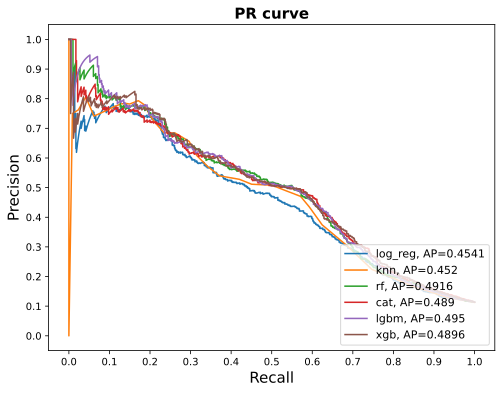

In [22]:
# строим Precision Recall кривые
# в общем в заивимости от бизнес задачи
# по графику можно выбрать лучший алгоритм и порог
fig = plt.figure(figsize=(8,6))

for i in range(len(test_recall)):
    plt.plot(test_recall[i],
             test_precision[i],
             label="{}, AP={}".format(str(classifier_names[i]), round(test_ap[i], 4)))

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Recall", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("Precision", fontsize=15)

plt.title('PR curve', fontweight='bold', fontsize=15)
plt.legend(prop={'size':11}, loc='lower right')

plt.show()


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2


'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2


'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2


'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.


Iteration: 0
Iteration: 1
Iteration: 2


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.


Iteration: 0
Iteration: 1
Iteration: 2


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2


'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2


'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.


Iteration: 0
Iteration: 1
Iteration: 2


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.


Iteration: 0
Iteration: 1
Iteration: 2


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.


Iteration: 0
Iteration: 1
Iteration: 2


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6


'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-16 23:23:32,595:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.6854375019617758, 'topology': 'poly_1', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-16 23:23:58,817:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.6854375019617758, 'topology': 'poly_1', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2


2021-04-16 23:24:20,429:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.6854375019617758, 'topology': 'poly_1', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-16 23:24:44,634:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.6854375019617758, 'topology': 'poly_1', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-16 23:25:11,073:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.6854375019617758, 'topology': 'poly_1', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


2021-04-16 23:25:37,891:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.6854375019617758, 'topology': 'poly_1', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2


2021-04-16 23:25:59,485:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.6854375019617758, 'topology': 'poly_1', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


2021-04-16 23:26:28,960:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.6854375019617758, 'topology': 'poly_1', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-16 23:26:53,327:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.6854375019617758, 'topology': 'poly_1', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2


2021-04-16 23:27:14,928:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.6854375019617758, 'topology': 'poly_1', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-16 23:27:38,095:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.6854375019617758, 'topology': 'poly_1', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-16 23:28:03,347:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.6854375019617758, 'topology': 'poly_1', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


2021-04-16 23:28:35,509:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.6854375019617758, 'topology': 'poly_1', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2


2021-04-16 23:29:06,278:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.6854375019617758, 'topology': 'poly_1', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


2021-04-16 23:29:41,359:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.6854375019617758, 'topology': 'poly_1', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-16 23:30:13,685:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.6854375019617758, 'topology': 'poly_1', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-16 23:30:44,500:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.6854375019617758, 'topology': 'poly_1', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-16 23:31:16,786:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.6854375019617758, 'topology': 'poly_1', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2


2021-04-16 23:31:44,325:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.6854375019617758, 'topology': 'poly_1', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


2021-04-16 23:32:17,535:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.6854375019617758, 'topology': 'poly_1', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-16 23:32:50,609:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.6854375019617758, 'topology': 'poly_1', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-16 23:33:21,840:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.6854375019617758, 'topology': 'poly_1', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-16 23:33:53,030:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.6854375019617758, 'topology': 'poly_1', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


2021-04-16 23:34:26,509:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.6854375019617758, 'topology': 'poly_1', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6


2021-04-16 23:35:07,079:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.6854375019617758, 'topology': 'poly_1', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-16 23:35:41,133:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.36660330414955, 'topology': 'poly_2', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-16 23:36:16,316:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.36660330414955, 'topology': 'poly_2', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2


2021-04-16 23:36:45,345:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.36660330414955, 'topology': 'poly_2', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-16 23:37:19,034:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.36660330414955, 'topology': 'poly_2', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-16 23:37:54,194:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.36660330414955, 'topology': 'poly_2', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


2021-04-16 23:38:30,685:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.36660330414955, 'topology': 'poly_2', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2


2021-04-16 23:38:59,601:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.36660330414955, 'topology': 'poly_2', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


2021-04-16 23:39:39,945:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.36660330414955, 'topology': 'poly_2', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-16 23:40:12,373:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.36660330414955, 'topology': 'poly_2', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2


2021-04-16 23:40:41,774:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.36660330414955, 'topology': 'poly_2', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-16 23:41:13,549:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.36660330414955, 'topology': 'poly_2', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-16 23:41:47,820:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.36660330414955, 'topology': 'poly_2', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


2021-04-16 23:42:23,148:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.36660330414955, 'topology': 'poly_2', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2


2021-04-16 23:42:54,750:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.36660330414955, 'topology': 'poly_2', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


2021-04-16 23:43:31,814:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.36660330414955, 'topology': 'poly_2', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-16 23:44:06,300:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.36660330414955, 'topology': 'poly_2', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-16 23:44:39,047:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.36660330414955, 'topology': 'poly_2', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-16 23:45:12,036:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.36660330414955, 'topology': 'poly_2', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2


2021-04-16 23:45:41,317:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.36660330414955, 'topology': 'poly_2', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


2021-04-16 23:46:16,531:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.36660330414955, 'topology': 'poly_2', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-16 23:46:51,014:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.36660330414955, 'topology': 'poly_2', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-16 23:47:23,968:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.36660330414955, 'topology': 'poly_2', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-16 23:47:56,906:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.36660330414955, 'topology': 'poly_2', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


2021-04-16 23:48:31,720:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.36660330414955, 'topology': 'poly_2', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6


2021-04-16 23:49:14,292:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.36660330414955, 'topology': 'poly_2', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-16 23:49:49,994:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.1333872731877877, 'topology': 'star', 'random_state': 42}")


0:	learn: 0.6666018	total: 252ms	remaining: 4m 11s
1:	learn: 0.6388532	total: 267ms	remaining: 2m 13s
2:	learn: 0.6151380	total: 283ms	remaining: 1m 33s
3:	learn: 0.5921172	total: 299ms	remaining: 1m 14s
4:	learn: 0.5723758	total: 315ms	remaining: 1m 2s
5:	learn: 0.5606266	total: 328ms	remaining: 54.4s
6:	learn: 0.5385591	total: 345ms	remaining: 48.9s
7:	learn: 0.5256109	total: 360ms	remaining: 44.6s
8:	learn: 0.5143522	total: 376ms	remaining: 41.4s
9:	learn: 0.5020963	total: 392ms	remaining: 38.8s
10:	learn: 0.4913416	total: 408ms	remaining: 36.7s
11:	learn: 0.4837418	total: 424ms	remaining: 34.9s
12:	learn: 0.4740931	total: 440ms	remaining: 33.4s
13:	learn: 0.4656074	total: 458ms	remaining: 32.2s
14:	learn: 0.4586002	total: 474ms	remaining: 31.1s
15:	learn: 0.4524254	total: 488ms	remaining: 30s
16:	learn: 0.4467822	total: 501ms	remaining: 29s
17:	learn: 0.4403144	total: 517ms	remaining: 28.2s
18:	learn: 0.4348151	total: 535ms	remaining: 27.6s
19:	learn: 0.4306458	total: 551ms	remaini

167:	learn: 0.3609326	total: 3.09s	remaining: 15.3s
168:	learn: 0.3608952	total: 3.1s	remaining: 15.3s
169:	learn: 0.3608312	total: 3.11s	remaining: 15.2s
170:	learn: 0.3607426	total: 3.13s	remaining: 15.2s
171:	learn: 0.3606526	total: 3.14s	remaining: 15.1s
172:	learn: 0.3606142	total: 3.16s	remaining: 15.1s
173:	learn: 0.3605228	total: 3.17s	remaining: 15s
174:	learn: 0.3605038	total: 3.18s	remaining: 15s
175:	learn: 0.3604841	total: 3.2s	remaining: 15s
176:	learn: 0.3603464	total: 3.21s	remaining: 14.9s
177:	learn: 0.3603156	total: 3.23s	remaining: 14.9s
178:	learn: 0.3602588	total: 3.24s	remaining: 14.9s
179:	learn: 0.3602402	total: 3.26s	remaining: 14.8s
180:	learn: 0.3600964	total: 3.27s	remaining: 14.8s
181:	learn: 0.3600786	total: 3.29s	remaining: 14.8s
182:	learn: 0.3599765	total: 3.3s	remaining: 14.7s
183:	learn: 0.3599388	total: 3.32s	remaining: 14.7s
184:	learn: 0.3599045	total: 3.33s	remaining: 14.7s
185:	learn: 0.3598433	total: 3.34s	remaining: 14.6s
186:	learn: 0.3594786

328:	learn: 0.3524956	total: 5.48s	remaining: 11.2s
329:	learn: 0.3524533	total: 5.49s	remaining: 11.2s
330:	learn: 0.3523914	total: 5.51s	remaining: 11.1s
331:	learn: 0.3523814	total: 5.53s	remaining: 11.1s
332:	learn: 0.3523181	total: 5.54s	remaining: 11.1s
333:	learn: 0.3522774	total: 5.56s	remaining: 11.1s
334:	learn: 0.3522447	total: 5.57s	remaining: 11.1s
335:	learn: 0.3522345	total: 5.59s	remaining: 11s
336:	learn: 0.3521973	total: 5.61s	remaining: 11s
337:	learn: 0.3520612	total: 5.62s	remaining: 11s
338:	learn: 0.3520335	total: 5.63s	remaining: 11s
339:	learn: 0.3519810	total: 5.65s	remaining: 11s
340:	learn: 0.3519365	total: 5.66s	remaining: 10.9s
341:	learn: 0.3519011	total: 5.68s	remaining: 10.9s
342:	learn: 0.3517760	total: 5.69s	remaining: 10.9s
343:	learn: 0.3517544	total: 5.71s	remaining: 10.9s
344:	learn: 0.3517041	total: 5.73s	remaining: 10.9s
345:	learn: 0.3516813	total: 5.74s	remaining: 10.9s
346:	learn: 0.3516013	total: 5.76s	remaining: 10.8s
347:	learn: 0.3515425	

489:	learn: 0.3463176	total: 7.9s	remaining: 8.22s
490:	learn: 0.3462863	total: 7.91s	remaining: 8.2s
491:	learn: 0.3462858	total: 7.93s	remaining: 8.18s
492:	learn: 0.3462331	total: 7.94s	remaining: 8.17s
493:	learn: 0.3461964	total: 7.96s	remaining: 8.15s
494:	learn: 0.3461230	total: 7.97s	remaining: 8.13s
495:	learn: 0.3460986	total: 7.99s	remaining: 8.11s
496:	learn: 0.3460982	total: 8s	remaining: 8.09s
497:	learn: 0.3460772	total: 8.01s	remaining: 8.08s
498:	learn: 0.3460515	total: 8.03s	remaining: 8.06s
499:	learn: 0.3460234	total: 8.04s	remaining: 8.04s
500:	learn: 0.3460050	total: 8.06s	remaining: 8.03s
501:	learn: 0.3459770	total: 8.07s	remaining: 8.01s
502:	learn: 0.3459419	total: 8.09s	remaining: 8s
503:	learn: 0.3458957	total: 8.11s	remaining: 7.98s
504:	learn: 0.3458620	total: 8.12s	remaining: 7.96s
505:	learn: 0.3458194	total: 8.13s	remaining: 7.94s
506:	learn: 0.3457871	total: 8.15s	remaining: 7.92s
507:	learn: 0.3457533	total: 8.17s	remaining: 7.91s
508:	learn: 0.345752

656:	learn: 0.3427293	total: 10.5s	remaining: 5.48s
657:	learn: 0.3427289	total: 10.5s	remaining: 5.46s
658:	learn: 0.3426983	total: 10.5s	remaining: 5.45s
659:	learn: 0.3426776	total: 10.5s	remaining: 5.43s
660:	learn: 0.3426440	total: 10.6s	remaining: 5.41s
661:	learn: 0.3426187	total: 10.6s	remaining: 5.39s
662:	learn: 0.3425734	total: 10.6s	remaining: 5.38s
663:	learn: 0.3425389	total: 10.6s	remaining: 5.36s
664:	learn: 0.3425149	total: 10.6s	remaining: 5.34s
665:	learn: 0.3424838	total: 10.6s	remaining: 5.33s
666:	learn: 0.3424565	total: 10.6s	remaining: 5.31s
667:	learn: 0.3424434	total: 10.7s	remaining: 5.29s
668:	learn: 0.3424430	total: 10.7s	remaining: 5.28s
669:	learn: 0.3424374	total: 10.7s	remaining: 5.26s
670:	learn: 0.3424143	total: 10.7s	remaining: 5.24s
671:	learn: 0.3424139	total: 10.7s	remaining: 5.23s
672:	learn: 0.3424135	total: 10.7s	remaining: 5.21s
673:	learn: 0.3424133	total: 10.7s	remaining: 5.2s
674:	learn: 0.3423933	total: 10.8s	remaining: 5.18s
675:	learn: 0

827:	learn: 0.3397015	total: 13.1s	remaining: 2.73s
828:	learn: 0.3396833	total: 13.1s	remaining: 2.71s
829:	learn: 0.3396723	total: 13.2s	remaining: 2.69s
830:	learn: 0.3396720	total: 13.2s	remaining: 2.68s
831:	learn: 0.3396558	total: 13.2s	remaining: 2.66s
832:	learn: 0.3396411	total: 13.2s	remaining: 2.65s
833:	learn: 0.3396149	total: 13.2s	remaining: 2.63s
834:	learn: 0.3396146	total: 13.2s	remaining: 2.61s
835:	learn: 0.3395868	total: 13.2s	remaining: 2.6s
836:	learn: 0.3395579	total: 13.3s	remaining: 2.58s
837:	learn: 0.3395435	total: 13.3s	remaining: 2.57s
838:	learn: 0.3395432	total: 13.3s	remaining: 2.55s
839:	learn: 0.3395429	total: 13.3s	remaining: 2.53s
840:	learn: 0.3395115	total: 13.3s	remaining: 2.52s
841:	learn: 0.3395113	total: 13.3s	remaining: 2.5s
842:	learn: 0.3394968	total: 13.4s	remaining: 2.49s
843:	learn: 0.3394749	total: 13.4s	remaining: 2.47s
844:	learn: 0.3394748	total: 13.4s	remaining: 2.45s
845:	learn: 0.3394562	total: 13.4s	remaining: 2.44s
846:	learn: 0.

996:	learn: 0.3374226	total: 15.7s	remaining: 47.2ms
997:	learn: 0.3373992	total: 15.7s	remaining: 31.5ms
998:	learn: 0.3373897	total: 15.7s	remaining: 15.7ms
999:	learn: 0.3373642	total: 15.7s	remaining: 0us
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-16 23:50:36,344:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.1333872731877877, 'topology': 'star', 'random_state': 42}")


0:	learn: 0.6667663	total: 16ms	remaining: 16s
1:	learn: 0.6393415	total: 33.9ms	remaining: 16.9s
2:	learn: 0.6157526	total: 49.5ms	remaining: 16.4s
3:	learn: 0.5959180	total: 66.2ms	remaining: 16.5s
4:	learn: 0.5744133	total: 83.1ms	remaining: 16.5s
5:	learn: 0.5584238	total: 99.5ms	remaining: 16.5s
6:	learn: 0.5424500	total: 116ms	remaining: 16.5s
7:	learn: 0.5294619	total: 131ms	remaining: 16.2s
8:	learn: 0.5157405	total: 149ms	remaining: 16.4s
9:	learn: 0.5063928	total: 167ms	remaining: 16.6s
10:	learn: 0.4960626	total: 191ms	remaining: 17.1s
11:	learn: 0.4874930	total: 216ms	remaining: 17.8s
12:	learn: 0.4776835	total: 234ms	remaining: 17.8s
13:	learn: 0.4693000	total: 250ms	remaining: 17.6s
14:	learn: 0.4629383	total: 264ms	remaining: 17.3s
15:	learn: 0.4566167	total: 277ms	remaining: 17s
16:	learn: 0.4499823	total: 293ms	remaining: 16.9s
17:	learn: 0.4442656	total: 309ms	remaining: 16.9s
18:	learn: 0.4402238	total: 322ms	remaining: 16.6s
19:	learn: 0.4359531	total: 334ms	remaini

162:	learn: 0.3619095	total: 2.87s	remaining: 14.7s
163:	learn: 0.3618395	total: 2.89s	remaining: 14.7s
164:	learn: 0.3618076	total: 2.91s	remaining: 14.7s
165:	learn: 0.3617788	total: 2.92s	remaining: 14.7s
166:	learn: 0.3617210	total: 2.94s	remaining: 14.7s
167:	learn: 0.3616352	total: 2.96s	remaining: 14.7s
168:	learn: 0.3615871	total: 2.98s	remaining: 14.6s
169:	learn: 0.3615351	total: 2.99s	remaining: 14.6s
170:	learn: 0.3615060	total: 3.01s	remaining: 14.6s
171:	learn: 0.3614335	total: 3.02s	remaining: 14.6s
172:	learn: 0.3613857	total: 3.04s	remaining: 14.5s
173:	learn: 0.3612840	total: 3.06s	remaining: 14.5s
174:	learn: 0.3608799	total: 3.08s	remaining: 14.5s
175:	learn: 0.3608562	total: 3.09s	remaining: 14.5s
176:	learn: 0.3607995	total: 3.1s	remaining: 14.4s
177:	learn: 0.3607192	total: 3.11s	remaining: 14.4s
178:	learn: 0.3606607	total: 3.13s	remaining: 14.3s
179:	learn: 0.3606395	total: 3.14s	remaining: 14.3s
180:	learn: 0.3606223	total: 3.16s	remaining: 14.3s
181:	learn: 0

330:	learn: 0.3539747	total: 5.44s	remaining: 11s
331:	learn: 0.3539355	total: 5.46s	remaining: 11s
332:	learn: 0.3538622	total: 5.47s	remaining: 11s
333:	learn: 0.3537222	total: 5.49s	remaining: 10.9s
334:	learn: 0.3536877	total: 5.51s	remaining: 10.9s
335:	learn: 0.3536482	total: 5.52s	remaining: 10.9s
336:	learn: 0.3536009	total: 5.54s	remaining: 10.9s
337:	learn: 0.3535632	total: 5.55s	remaining: 10.9s
338:	learn: 0.3535109	total: 5.57s	remaining: 10.9s
339:	learn: 0.3534875	total: 5.58s	remaining: 10.8s
340:	learn: 0.3534454	total: 5.6s	remaining: 10.8s
341:	learn: 0.3534041	total: 5.61s	remaining: 10.8s
342:	learn: 0.3532432	total: 5.63s	remaining: 10.8s
343:	learn: 0.3532097	total: 5.65s	remaining: 10.8s
344:	learn: 0.3531645	total: 5.66s	remaining: 10.7s
345:	learn: 0.3531375	total: 5.68s	remaining: 10.7s
346:	learn: 0.3531078	total: 5.69s	remaining: 10.7s
347:	learn: 0.3530563	total: 5.71s	remaining: 10.7s
348:	learn: 0.3530295	total: 5.72s	remaining: 10.7s
349:	learn: 0.35298

495:	learn: 0.3472122	total: 8.02s	remaining: 8.15s
496:	learn: 0.3472118	total: 8.04s	remaining: 8.13s
497:	learn: 0.3471765	total: 8.05s	remaining: 8.12s
498:	learn: 0.3471528	total: 8.07s	remaining: 8.1s
499:	learn: 0.3471195	total: 8.09s	remaining: 8.09s
500:	learn: 0.3470804	total: 8.1s	remaining: 8.06s
501:	learn: 0.3470619	total: 8.11s	remaining: 8.05s
502:	learn: 0.3470312	total: 8.13s	remaining: 8.03s
503:	learn: 0.3470140	total: 8.14s	remaining: 8.02s
504:	learn: 0.3469587	total: 8.16s	remaining: 8s
505:	learn: 0.3469583	total: 8.18s	remaining: 7.98s
506:	learn: 0.3469412	total: 8.19s	remaining: 7.96s
507:	learn: 0.3469105	total: 8.21s	remaining: 7.95s
508:	learn: 0.3468709	total: 8.22s	remaining: 7.93s
509:	learn: 0.3468704	total: 8.24s	remaining: 7.92s
510:	learn: 0.3468382	total: 8.26s	remaining: 7.9s
511:	learn: 0.3468185	total: 8.27s	remaining: 7.88s
512:	learn: 0.3467937	total: 8.29s	remaining: 7.87s
513:	learn: 0.3467516	total: 8.3s	remaining: 7.85s
514:	learn: 0.34672

664:	learn: 0.3433153	total: 10.8s	remaining: 5.45s
665:	learn: 0.3432877	total: 10.8s	remaining: 5.43s
666:	learn: 0.3432754	total: 10.8s	remaining: 5.42s
667:	learn: 0.3432552	total: 10.9s	remaining: 5.4s
668:	learn: 0.3432549	total: 10.9s	remaining: 5.38s
669:	learn: 0.3432436	total: 10.9s	remaining: 5.37s
670:	learn: 0.3432433	total: 10.9s	remaining: 5.35s
671:	learn: 0.3432430	total: 10.9s	remaining: 5.33s
672:	learn: 0.3432145	total: 10.9s	remaining: 5.32s
673:	learn: 0.3431906	total: 11s	remaining: 5.3s
674:	learn: 0.3431821	total: 11s	remaining: 5.29s
675:	learn: 0.3431454	total: 11s	remaining: 5.27s
676:	learn: 0.3431239	total: 11s	remaining: 5.26s
677:	learn: 0.3431043	total: 11s	remaining: 5.24s
678:	learn: 0.3431039	total: 11.1s	remaining: 5.23s
679:	learn: 0.3430906	total: 11.1s	remaining: 5.21s
680:	learn: 0.3430748	total: 11.1s	remaining: 5.19s
681:	learn: 0.3430117	total: 11.1s	remaining: 5.18s
682:	learn: 0.3429957	total: 11.1s	remaining: 5.16s
683:	learn: 0.3429766	to

834:	learn: 0.3403363	total: 13.7s	remaining: 2.7s
835:	learn: 0.3403141	total: 13.7s	remaining: 2.68s
836:	learn: 0.3402912	total: 13.7s	remaining: 2.67s
837:	learn: 0.3402725	total: 13.7s	remaining: 2.65s
838:	learn: 0.3402722	total: 13.7s	remaining: 2.63s
839:	learn: 0.3402596	total: 13.7s	remaining: 2.62s
840:	learn: 0.3402310	total: 13.8s	remaining: 2.6s
841:	learn: 0.3402161	total: 13.8s	remaining: 2.58s
842:	learn: 0.3402158	total: 13.8s	remaining: 2.57s
843:	learn: 0.3402059	total: 13.8s	remaining: 2.55s
844:	learn: 0.3401894	total: 13.8s	remaining: 2.54s
845:	learn: 0.3401743	total: 13.8s	remaining: 2.52s
846:	learn: 0.3401601	total: 13.9s	remaining: 2.5s
847:	learn: 0.3401431	total: 13.9s	remaining: 2.49s
848:	learn: 0.3401428	total: 13.9s	remaining: 2.47s
849:	learn: 0.3401323	total: 13.9s	remaining: 2.45s
850:	learn: 0.3401036	total: 13.9s	remaining: 2.44s
851:	learn: 0.3401034	total: 13.9s	remaining: 2.42s
852:	learn: 0.3400821	total: 14s	remaining: 2.4s
853:	learn: 0.3400

998:	learn: 0.3379624	total: 16.5s	remaining: 16.5ms
999:	learn: 0.3379467	total: 16.5s	remaining: 0us
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2


2021-04-16 23:51:17,000:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.1333872731877877, 'topology': 'star', 'random_state': 42}")


0:	learn: 0.6663931	total: 17.8ms	remaining: 17.8s
1:	learn: 0.6395174	total: 33.5ms	remaining: 16.7s
2:	learn: 0.6155467	total: 48.6ms	remaining: 16.1s
3:	learn: 0.5922844	total: 65.2ms	remaining: 16.2s
4:	learn: 0.5717627	total: 80.9ms	remaining: 16.1s
5:	learn: 0.5537981	total: 96.7ms	remaining: 16s
6:	learn: 0.5391314	total: 113ms	remaining: 16s
7:	learn: 0.5251631	total: 129ms	remaining: 16s
8:	learn: 0.5123840	total: 144ms	remaining: 15.9s
9:	learn: 0.5009833	total: 161ms	remaining: 15.9s
10:	learn: 0.4859970	total: 177ms	remaining: 15.9s
11:	learn: 0.4785413	total: 193ms	remaining: 15.9s
12:	learn: 0.4666692	total: 209ms	remaining: 15.9s
13:	learn: 0.4584056	total: 231ms	remaining: 16.3s
14:	learn: 0.4530597	total: 248ms	remaining: 16.3s
15:	learn: 0.4487568	total: 263ms	remaining: 16.2s
16:	learn: 0.4434405	total: 279ms	remaining: 16.1s
17:	learn: 0.4382597	total: 297ms	remaining: 16.2s
18:	learn: 0.4333803	total: 312ms	remaining: 16.1s
19:	learn: 0.4285806	total: 328ms	remaini

161:	learn: 0.3593347	total: 3.35s	remaining: 17.3s
162:	learn: 0.3592622	total: 3.37s	remaining: 17.3s
163:	learn: 0.3592321	total: 3.38s	remaining: 17.3s
164:	learn: 0.3591874	total: 3.4s	remaining: 17.2s
165:	learn: 0.3591304	total: 3.41s	remaining: 17.2s
166:	learn: 0.3591005	total: 3.43s	remaining: 17.1s
167:	learn: 0.3590074	total: 3.44s	remaining: 17.1s
168:	learn: 0.3589751	total: 3.46s	remaining: 17s
169:	learn: 0.3588708	total: 3.48s	remaining: 17s
170:	learn: 0.3586158	total: 3.5s	remaining: 17s
171:	learn: 0.3585704	total: 3.52s	remaining: 16.9s
172:	learn: 0.3585046	total: 3.53s	remaining: 16.9s
173:	learn: 0.3584481	total: 3.55s	remaining: 16.9s
174:	learn: 0.3584027	total: 3.57s	remaining: 16.8s
175:	learn: 0.3583357	total: 3.59s	remaining: 16.8s
176:	learn: 0.3583097	total: 3.61s	remaining: 16.8s
177:	learn: 0.3582907	total: 3.63s	remaining: 16.7s
178:	learn: 0.3582588	total: 3.64s	remaining: 16.7s
179:	learn: 0.3582420	total: 3.65s	remaining: 16.6s
180:	learn: 0.358159

326:	learn: 0.3501848	total: 6.93s	remaining: 14.3s
327:	learn: 0.3501474	total: 6.96s	remaining: 14.3s
328:	learn: 0.3500411	total: 6.98s	remaining: 14.2s
329:	learn: 0.3500007	total: 7.01s	remaining: 14.2s
330:	learn: 0.3498929	total: 7.03s	remaining: 14.2s
331:	learn: 0.3498772	total: 7.05s	remaining: 14.2s
332:	learn: 0.3498318	total: 7.08s	remaining: 14.2s
333:	learn: 0.3497902	total: 7.1s	remaining: 14.2s
334:	learn: 0.3497626	total: 7.12s	remaining: 14.1s
335:	learn: 0.3496940	total: 7.15s	remaining: 14.1s
336:	learn: 0.3496219	total: 7.17s	remaining: 14.1s
337:	learn: 0.3495777	total: 7.21s	remaining: 14.1s
338:	learn: 0.3495650	total: 7.23s	remaining: 14.1s
339:	learn: 0.3495123	total: 7.25s	remaining: 14.1s
340:	learn: 0.3494182	total: 7.27s	remaining: 14.1s
341:	learn: 0.3493681	total: 7.3s	remaining: 14s
342:	learn: 0.3492319	total: 7.32s	remaining: 14s
343:	learn: 0.3491908	total: 7.34s	remaining: 14s
344:	learn: 0.3491076	total: 7.37s	remaining: 14s
345:	learn: 0.3490223	

490:	learn: 0.3432683	total: 10.8s	remaining: 11.1s
491:	learn: 0.3432148	total: 10.8s	remaining: 11.1s
492:	learn: 0.3431871	total: 10.8s	remaining: 11.1s
493:	learn: 0.3431502	total: 10.8s	remaining: 11.1s
494:	learn: 0.3431288	total: 10.8s	remaining: 11.1s
495:	learn: 0.3430642	total: 10.9s	remaining: 11s
496:	learn: 0.3430424	total: 10.9s	remaining: 11s
497:	learn: 0.3430209	total: 10.9s	remaining: 11s
498:	learn: 0.3430014	total: 10.9s	remaining: 11s
499:	learn: 0.3429568	total: 10.9s	remaining: 10.9s
500:	learn: 0.3429297	total: 11s	remaining: 10.9s
501:	learn: 0.3428971	total: 11s	remaining: 10.9s
502:	learn: 0.3428695	total: 11s	remaining: 10.9s
503:	learn: 0.3428335	total: 11.1s	remaining: 10.9s
504:	learn: 0.3428042	total: 11.1s	remaining: 10.9s
505:	learn: 0.3427770	total: 11.1s	remaining: 10.8s
506:	learn: 0.3427368	total: 11.1s	remaining: 10.8s
507:	learn: 0.3427031	total: 11.2s	remaining: 10.8s
508:	learn: 0.3426677	total: 11.2s	remaining: 10.8s
509:	learn: 0.3426355	tota

652:	learn: 0.3388840	total: 14.8s	remaining: 7.85s
653:	learn: 0.3388834	total: 14.8s	remaining: 7.83s
654:	learn: 0.3388566	total: 14.8s	remaining: 7.8s
655:	learn: 0.3388366	total: 14.8s	remaining: 7.78s
656:	learn: 0.3388359	total: 14.9s	remaining: 7.76s
657:	learn: 0.3388213	total: 14.9s	remaining: 7.74s
658:	learn: 0.3387836	total: 14.9s	remaining: 7.71s
659:	learn: 0.3387829	total: 14.9s	remaining: 7.69s
660:	learn: 0.3387460	total: 14.9s	remaining: 7.67s
661:	learn: 0.3387231	total: 15s	remaining: 7.64s
662:	learn: 0.3387046	total: 15s	remaining: 7.62s
663:	learn: 0.3387040	total: 15s	remaining: 7.59s
664:	learn: 0.3386953	total: 15s	remaining: 7.57s
665:	learn: 0.3386802	total: 15.1s	remaining: 7.55s
666:	learn: 0.3386558	total: 15.1s	remaining: 7.53s
667:	learn: 0.3386330	total: 15.1s	remaining: 7.5s
668:	learn: 0.3386324	total: 15.1s	remaining: 7.48s
669:	learn: 0.3385987	total: 15.1s	remaining: 7.46s
670:	learn: 0.3385919	total: 15.2s	remaining: 7.44s
671:	learn: 0.3385729	

812:	learn: 0.3358839	total: 18.8s	remaining: 4.32s
813:	learn: 0.3358834	total: 18.8s	remaining: 4.3s
814:	learn: 0.3358037	total: 18.8s	remaining: 4.27s
815:	learn: 0.3357713	total: 18.9s	remaining: 4.25s
816:	learn: 0.3357588	total: 18.9s	remaining: 4.23s
817:	learn: 0.3357582	total: 18.9s	remaining: 4.21s
818:	learn: 0.3357284	total: 18.9s	remaining: 4.19s
819:	learn: 0.3357073	total: 19s	remaining: 4.17s
820:	learn: 0.3356798	total: 19s	remaining: 4.15s
821:	learn: 0.3356705	total: 19s	remaining: 4.12s
822:	learn: 0.3356699	total: 19.1s	remaining: 4.1s
823:	learn: 0.3356694	total: 19.1s	remaining: 4.08s
824:	learn: 0.3356510	total: 19.1s	remaining: 4.05s
825:	learn: 0.3356225	total: 19.1s	remaining: 4.03s
826:	learn: 0.3356013	total: 19.1s	remaining: 4s
827:	learn: 0.3356007	total: 19.2s	remaining: 3.98s
828:	learn: 0.3355816	total: 19.2s	remaining: 3.96s
829:	learn: 0.3355729	total: 19.2s	remaining: 3.94s
830:	learn: 0.3355427	total: 19.3s	remaining: 3.92s
831:	learn: 0.3355364	t

978:	learn: 0.3332761	total: 22.5s	remaining: 483ms
979:	learn: 0.3332637	total: 22.5s	remaining: 460ms
980:	learn: 0.3332484	total: 22.6s	remaining: 437ms
981:	learn: 0.3332361	total: 22.6s	remaining: 414ms
982:	learn: 0.3332218	total: 22.6s	remaining: 391ms
983:	learn: 0.3332113	total: 22.6s	remaining: 368ms
984:	learn: 0.3331876	total: 22.7s	remaining: 345ms
985:	learn: 0.3331704	total: 22.7s	remaining: 322ms
986:	learn: 0.3331558	total: 22.7s	remaining: 299ms
987:	learn: 0.3331413	total: 22.7s	remaining: 276ms
988:	learn: 0.3331296	total: 22.7s	remaining: 253ms
989:	learn: 0.3331293	total: 22.8s	remaining: 230ms
990:	learn: 0.3331073	total: 22.8s	remaining: 207ms
991:	learn: 0.3330900	total: 22.8s	remaining: 184ms
992:	learn: 0.3330761	total: 22.8s	remaining: 161ms
993:	learn: 0.3330711	total: 22.9s	remaining: 138ms
994:	learn: 0.3330555	total: 22.9s	remaining: 115ms
995:	learn: 0.3330220	total: 22.9s	remaining: 92ms
996:	learn: 0.3330120	total: 22.9s	remaining: 69ms
997:	learn: 0.

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-16 23:52:12,225:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.1333872731877877, 'topology': 'star', 'random_state': 42}")


0:	learn: 0.6667454	total: 17.7ms	remaining: 17.7s
1:	learn: 0.6391434	total: 33.8ms	remaining: 16.9s
2:	learn: 0.6153707	total: 49.5ms	remaining: 16.5s
3:	learn: 0.5954334	total: 66.4ms	remaining: 16.5s
4:	learn: 0.5741631	total: 83.6ms	remaining: 16.6s
5:	learn: 0.5578891	total: 99.3ms	remaining: 16.4s
6:	learn: 0.5402182	total: 116ms	remaining: 16.4s
7:	learn: 0.5245601	total: 133ms	remaining: 16.4s
8:	learn: 0.5117816	total: 149ms	remaining: 16.4s
9:	learn: 0.5000343	total: 166ms	remaining: 16.4s
10:	learn: 0.4892160	total: 182ms	remaining: 16.4s
11:	learn: 0.4812073	total: 195ms	remaining: 16.1s
12:	learn: 0.4722686	total: 214ms	remaining: 16.3s
13:	learn: 0.4644822	total: 232ms	remaining: 16.3s
14:	learn: 0.4569804	total: 248ms	remaining: 16.3s
15:	learn: 0.4508766	total: 262ms	remaining: 16.1s
16:	learn: 0.4446634	total: 280ms	remaining: 16.2s
17:	learn: 0.4391766	total: 302ms	remaining: 16.5s
18:	learn: 0.4348714	total: 321ms	remaining: 16.6s
19:	learn: 0.4301268	total: 344ms	r

167:	learn: 0.3584667	total: 2.88s	remaining: 14.3s
168:	learn: 0.3584316	total: 2.9s	remaining: 14.2s
169:	learn: 0.3584174	total: 2.91s	remaining: 14.2s
170:	learn: 0.3583462	total: 2.92s	remaining: 14.2s
171:	learn: 0.3582701	total: 2.94s	remaining: 14.2s
172:	learn: 0.3581665	total: 2.96s	remaining: 14.2s
173:	learn: 0.3581446	total: 2.98s	remaining: 14.1s
174:	learn: 0.3581093	total: 2.99s	remaining: 14.1s
175:	learn: 0.3580354	total: 3.01s	remaining: 14.1s
176:	learn: 0.3579831	total: 3.03s	remaining: 14.1s
177:	learn: 0.3579584	total: 3.04s	remaining: 14s
178:	learn: 0.3579119	total: 3.06s	remaining: 14s
179:	learn: 0.3578559	total: 3.07s	remaining: 14s
180:	learn: 0.3578303	total: 3.08s	remaining: 14s
181:	learn: 0.3576132	total: 3.1s	remaining: 13.9s
182:	learn: 0.3575845	total: 3.11s	remaining: 13.9s
183:	learn: 0.3575645	total: 3.13s	remaining: 13.9s
184:	learn: 0.3575586	total: 3.14s	remaining: 13.9s
185:	learn: 0.3575485	total: 3.16s	remaining: 13.8s
186:	learn: 0.3574940	

328:	learn: 0.3506512	total: 5.74s	remaining: 11.7s
329:	learn: 0.3505591	total: 5.75s	remaining: 11.7s
330:	learn: 0.3505362	total: 5.77s	remaining: 11.7s
331:	learn: 0.3505054	total: 5.79s	remaining: 11.6s
332:	learn: 0.3504841	total: 5.82s	remaining: 11.7s
333:	learn: 0.3504561	total: 5.84s	remaining: 11.6s
334:	learn: 0.3504087	total: 5.86s	remaining: 11.6s
335:	learn: 0.3503277	total: 5.88s	remaining: 11.6s
336:	learn: 0.3501847	total: 5.89s	remaining: 11.6s
337:	learn: 0.3501336	total: 5.91s	remaining: 11.6s
338:	learn: 0.3500935	total: 5.93s	remaining: 11.6s
339:	learn: 0.3500595	total: 5.95s	remaining: 11.6s
340:	learn: 0.3499850	total: 5.97s	remaining: 11.5s
341:	learn: 0.3499479	total: 5.99s	remaining: 11.5s
342:	learn: 0.3499050	total: 6.01s	remaining: 11.5s
343:	learn: 0.3498395	total: 6.03s	remaining: 11.5s
344:	learn: 0.3497987	total: 6.06s	remaining: 11.5s
345:	learn: 0.3497316	total: 6.08s	remaining: 11.5s
346:	learn: 0.3497113	total: 6.11s	remaining: 11.5s
347:	learn: 

497:	learn: 0.3436375	total: 9.13s	remaining: 9.2s
498:	learn: 0.3435997	total: 9.15s	remaining: 9.18s
499:	learn: 0.3435989	total: 9.17s	remaining: 9.17s
500:	learn: 0.3435981	total: 9.19s	remaining: 9.15s
501:	learn: 0.3435979	total: 9.2s	remaining: 9.13s
502:	learn: 0.3435622	total: 9.24s	remaining: 9.13s
503:	learn: 0.3435614	total: 9.27s	remaining: 9.12s
504:	learn: 0.3435313	total: 9.29s	remaining: 9.11s
505:	learn: 0.3435312	total: 9.32s	remaining: 9.1s
506:	learn: 0.3434971	total: 9.34s	remaining: 9.08s
507:	learn: 0.3434675	total: 9.37s	remaining: 9.08s
508:	learn: 0.3434353	total: 9.4s	remaining: 9.06s
509:	learn: 0.3433998	total: 9.42s	remaining: 9.05s
510:	learn: 0.3433763	total: 9.44s	remaining: 9.03s
511:	learn: 0.3433155	total: 9.46s	remaining: 9.01s
512:	learn: 0.3433147	total: 9.48s	remaining: 9s
513:	learn: 0.3432880	total: 9.49s	remaining: 8.98s
514:	learn: 0.3432626	total: 9.52s	remaining: 8.96s
515:	learn: 0.3432341	total: 9.53s	remaining: 8.94s
516:	learn: 0.34321

662:	learn: 0.3399727	total: 12.6s	remaining: 6.39s
663:	learn: 0.3399509	total: 12.6s	remaining: 6.37s
664:	learn: 0.3398685	total: 12.6s	remaining: 6.35s
665:	learn: 0.3398416	total: 12.6s	remaining: 6.33s
666:	learn: 0.3397976	total: 12.6s	remaining: 6.31s
667:	learn: 0.3397240	total: 12.7s	remaining: 6.29s
668:	learn: 0.3397117	total: 12.7s	remaining: 6.27s
669:	learn: 0.3396922	total: 12.7s	remaining: 6.25s
670:	learn: 0.3396916	total: 12.7s	remaining: 6.24s
671:	learn: 0.3396667	total: 12.7s	remaining: 6.22s
672:	learn: 0.3396661	total: 12.8s	remaining: 6.2s
673:	learn: 0.3396454	total: 12.8s	remaining: 6.18s
674:	learn: 0.3396076	total: 12.8s	remaining: 6.16s
675:	learn: 0.3395895	total: 12.8s	remaining: 6.14s
676:	learn: 0.3395649	total: 12.8s	remaining: 6.12s
677:	learn: 0.3395496	total: 12.8s	remaining: 6.1s
678:	learn: 0.3395255	total: 12.9s	remaining: 6.09s
679:	learn: 0.3394578	total: 12.9s	remaining: 6.07s
680:	learn: 0.3394303	total: 12.9s	remaining: 6.05s
681:	learn: 0.

825:	learn: 0.3368852	total: 15.9s	remaining: 3.34s
826:	learn: 0.3368847	total: 15.9s	remaining: 3.32s
827:	learn: 0.3368660	total: 15.9s	remaining: 3.3s
828:	learn: 0.3368656	total: 15.9s	remaining: 3.28s
829:	learn: 0.3368367	total: 15.9s	remaining: 3.26s
830:	learn: 0.3368145	total: 15.9s	remaining: 3.24s
831:	learn: 0.3368140	total: 16s	remaining: 3.22s
832:	learn: 0.3367968	total: 16s	remaining: 3.2s
833:	learn: 0.3367771	total: 16s	remaining: 3.19s
834:	learn: 0.3367639	total: 16s	remaining: 3.17s
835:	learn: 0.3367444	total: 16s	remaining: 3.15s
836:	learn: 0.3367191	total: 16.1s	remaining: 3.13s
837:	learn: 0.3367186	total: 16.1s	remaining: 3.11s
838:	learn: 0.3367010	total: 16.1s	remaining: 3.09s
839:	learn: 0.3367005	total: 16.1s	remaining: 3.07s
840:	learn: 0.3366822	total: 16.1s	remaining: 3.05s
841:	learn: 0.3366568	total: 16.2s	remaining: 3.03s
842:	learn: 0.3366358	total: 16.2s	remaining: 3.01s
843:	learn: 0.3366354	total: 16.2s	remaining: 2.99s
844:	learn: 0.3366297	to

989:	learn: 0.3345843	total: 19.1s	remaining: 193ms
990:	learn: 0.3345747	total: 19.1s	remaining: 174ms
991:	learn: 0.3345744	total: 19.1s	remaining: 154ms
992:	learn: 0.3345385	total: 19.2s	remaining: 135ms
993:	learn: 0.3345382	total: 19.2s	remaining: 116ms
994:	learn: 0.3345117	total: 19.2s	remaining: 96.4ms
995:	learn: 0.3345113	total: 19.2s	remaining: 77.1ms
996:	learn: 0.3344968	total: 19.2s	remaining: 57.9ms
997:	learn: 0.3344964	total: 19.3s	remaining: 38.6ms
998:	learn: 0.3344964	total: 19.3s	remaining: 19.3ms
999:	learn: 0.3344550	total: 19.3s	remaining: 0us
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-16 23:53:05,979:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.1333872731877877, 'topology': 'star', 'random_state': 42}")


0:	learn: 0.6668315	total: 21.5ms	remaining: 21.5s
1:	learn: 0.6394397	total: 43.1ms	remaining: 21.5s
2:	learn: 0.6159547	total: 59ms	remaining: 19.6s
3:	learn: 0.5931679	total: 81.4ms	remaining: 20.3s
4:	learn: 0.5735306	total: 101ms	remaining: 20.2s
5:	learn: 0.5585752	total: 121ms	remaining: 20.1s
6:	learn: 0.5398818	total: 140ms	remaining: 19.9s
7:	learn: 0.5280635	total: 156ms	remaining: 19.3s
8:	learn: 0.5173775	total: 174ms	remaining: 19.1s
9:	learn: 0.5061511	total: 192ms	remaining: 19s
10:	learn: 0.4943007	total: 211ms	remaining: 19s
11:	learn: 0.4870359	total: 225ms	remaining: 18.5s
12:	learn: 0.4810725	total: 251ms	remaining: 19.1s
13:	learn: 0.4737559	total: 267ms	remaining: 18.8s
14:	learn: 0.4621967	total: 289ms	remaining: 19s
15:	learn: 0.4573516	total: 304ms	remaining: 18.7s
16:	learn: 0.4493912	total: 326ms	remaining: 18.9s
17:	learn: 0.4436841	total: 344ms	remaining: 18.8s
18:	learn: 0.4392998	total: 361ms	remaining: 18.6s
19:	learn: 0.4340725	total: 378ms	remaining: 

162:	learn: 0.3623251	total: 3.25s	remaining: 16.7s
163:	learn: 0.3622676	total: 3.27s	remaining: 16.6s
164:	learn: 0.3622530	total: 3.28s	remaining: 16.6s
165:	learn: 0.3622098	total: 3.3s	remaining: 16.6s
166:	learn: 0.3621117	total: 3.32s	remaining: 16.5s
167:	learn: 0.3620659	total: 3.33s	remaining: 16.5s
168:	learn: 0.3619907	total: 3.35s	remaining: 16.5s
169:	learn: 0.3618965	total: 3.37s	remaining: 16.4s
170:	learn: 0.3618561	total: 3.38s	remaining: 16.4s
171:	learn: 0.3617169	total: 3.4s	remaining: 16.4s
172:	learn: 0.3617013	total: 3.41s	remaining: 16.3s
173:	learn: 0.3616806	total: 3.43s	remaining: 16.3s
174:	learn: 0.3616032	total: 3.45s	remaining: 16.3s
175:	learn: 0.3615814	total: 3.47s	remaining: 16.3s
176:	learn: 0.3614766	total: 3.49s	remaining: 16.2s
177:	learn: 0.3611993	total: 3.51s	remaining: 16.2s
178:	learn: 0.3611599	total: 3.52s	remaining: 16.1s
179:	learn: 0.3611127	total: 3.54s	remaining: 16.1s
180:	learn: 0.3610822	total: 3.55s	remaining: 16.1s
181:	learn: 0.

327:	learn: 0.3540828	total: 6.06s	remaining: 12.4s
328:	learn: 0.3540514	total: 6.08s	remaining: 12.4s
329:	learn: 0.3540161	total: 6.1s	remaining: 12.4s
330:	learn: 0.3539936	total: 6.12s	remaining: 12.4s
331:	learn: 0.3539492	total: 6.13s	remaining: 12.3s
332:	learn: 0.3539110	total: 6.15s	remaining: 12.3s
333:	learn: 0.3538072	total: 6.17s	remaining: 12.3s
334:	learn: 0.3537649	total: 6.19s	remaining: 12.3s
335:	learn: 0.3537502	total: 6.2s	remaining: 12.3s
336:	learn: 0.3537376	total: 6.22s	remaining: 12.2s
337:	learn: 0.3537100	total: 6.25s	remaining: 12.2s
338:	learn: 0.3536824	total: 6.27s	remaining: 12.2s
339:	learn: 0.3536480	total: 6.29s	remaining: 12.2s
340:	learn: 0.3536244	total: 6.3s	remaining: 12.2s
341:	learn: 0.3536044	total: 6.32s	remaining: 12.2s
342:	learn: 0.3535376	total: 6.34s	remaining: 12.1s
343:	learn: 0.3534967	total: 6.36s	remaining: 12.1s
344:	learn: 0.3534536	total: 6.38s	remaining: 12.1s
345:	learn: 0.3534156	total: 6.39s	remaining: 12.1s
346:	learn: 0.3

493:	learn: 0.3482838	total: 9.27s	remaining: 9.49s
494:	learn: 0.3482610	total: 9.29s	remaining: 9.48s
495:	learn: 0.3481945	total: 9.3s	remaining: 9.45s
496:	learn: 0.3481942	total: 9.32s	remaining: 9.43s
497:	learn: 0.3481369	total: 9.33s	remaining: 9.41s
498:	learn: 0.3481248	total: 9.35s	remaining: 9.39s
499:	learn: 0.3480483	total: 9.37s	remaining: 9.37s
500:	learn: 0.3480286	total: 9.39s	remaining: 9.35s
501:	learn: 0.3480033	total: 9.4s	remaining: 9.33s
502:	learn: 0.3479649	total: 9.42s	remaining: 9.31s
503:	learn: 0.3479461	total: 9.48s	remaining: 9.33s
504:	learn: 0.3479187	total: 9.5s	remaining: 9.31s
505:	learn: 0.3478990	total: 9.56s	remaining: 9.33s
506:	learn: 0.3478761	total: 9.58s	remaining: 9.31s
507:	learn: 0.3478609	total: 9.6s	remaining: 9.29s
508:	learn: 0.3478604	total: 9.61s	remaining: 9.27s
509:	learn: 0.3478411	total: 9.63s	remaining: 9.25s
510:	learn: 0.3477991	total: 9.65s	remaining: 9.23s
511:	learn: 0.3477864	total: 9.66s	remaining: 9.21s
512:	learn: 0.34

660:	learn: 0.3443725	total: 12.6s	remaining: 6.47s
661:	learn: 0.3443609	total: 12.6s	remaining: 6.45s
662:	learn: 0.3443404	total: 12.7s	remaining: 6.43s
663:	learn: 0.3443173	total: 12.7s	remaining: 6.42s
664:	learn: 0.3442741	total: 12.7s	remaining: 6.39s
665:	learn: 0.3442411	total: 12.7s	remaining: 6.38s
666:	learn: 0.3442237	total: 12.7s	remaining: 6.36s
667:	learn: 0.3441882	total: 12.8s	remaining: 6.34s
668:	learn: 0.3441719	total: 12.8s	remaining: 6.32s
669:	learn: 0.3441611	total: 12.8s	remaining: 6.3s
670:	learn: 0.3441178	total: 12.8s	remaining: 6.29s
671:	learn: 0.3441017	total: 12.8s	remaining: 6.27s
672:	learn: 0.3440796	total: 12.9s	remaining: 6.25s
673:	learn: 0.3440719	total: 12.9s	remaining: 6.23s
674:	learn: 0.3440596	total: 12.9s	remaining: 6.21s
675:	learn: 0.3440253	total: 12.9s	remaining: 6.19s
676:	learn: 0.3440135	total: 12.9s	remaining: 6.17s
677:	learn: 0.3439691	total: 13s	remaining: 6.15s
678:	learn: 0.3439532	total: 13s	remaining: 6.13s
679:	learn: 0.343

830:	learn: 0.3414078	total: 15.9s	remaining: 3.23s
831:	learn: 0.3414077	total: 15.9s	remaining: 3.21s
832:	learn: 0.3414076	total: 15.9s	remaining: 3.19s
833:	learn: 0.3413821	total: 15.9s	remaining: 3.17s
834:	learn: 0.3413685	total: 16s	remaining: 3.15s
835:	learn: 0.3413404	total: 16s	remaining: 3.13s
836:	learn: 0.3413240	total: 16s	remaining: 3.11s
837:	learn: 0.3413033	total: 16s	remaining: 3.09s
838:	learn: 0.3412975	total: 16s	remaining: 3.07s
839:	learn: 0.3412571	total: 16s	remaining: 3.05s
840:	learn: 0.3412286	total: 16s	remaining: 3.03s
841:	learn: 0.3412161	total: 16.1s	remaining: 3.01s
842:	learn: 0.3412039	total: 16.1s	remaining: 2.99s
843:	learn: 0.3411794	total: 16.1s	remaining: 2.98s
844:	learn: 0.3411717	total: 16.1s	remaining: 2.96s
845:	learn: 0.3411569	total: 16.1s	remaining: 2.94s
846:	learn: 0.3411455	total: 16.2s	remaining: 2.92s
847:	learn: 0.3411212	total: 16.2s	remaining: 2.9s
848:	learn: 0.3410981	total: 16.2s	remaining: 2.88s
849:	learn: 0.3410858	total

992:	learn: 0.3389430	total: 19s	remaining: 134ms
993:	learn: 0.3389321	total: 19s	remaining: 115ms
994:	learn: 0.3389259	total: 19s	remaining: 95.5ms
995:	learn: 0.3389109	total: 19s	remaining: 76.4ms
996:	learn: 0.3388811	total: 19s	remaining: 57.3ms
997:	learn: 0.3388650	total: 19.1s	remaining: 38.2ms
998:	learn: 0.3388563	total: 19.1s	remaining: 19.1ms
999:	learn: 0.3388288	total: 19.1s	remaining: 0us
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


2021-04-16 23:53:58,728:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.1333872731877877, 'topology': 'star', 'random_state': 42}")


0:	learn: 0.6666421	total: 17.2ms	remaining: 17.2s
1:	learn: 0.6390790	total: 34.1ms	remaining: 17s
2:	learn: 0.6153219	total: 50.5ms	remaining: 16.8s
3:	learn: 0.5921483	total: 67.2ms	remaining: 16.7s
4:	learn: 0.5731309	total: 83.7ms	remaining: 16.7s
5:	learn: 0.5563796	total: 99ms	remaining: 16.4s
6:	learn: 0.5407633	total: 115ms	remaining: 16.3s
7:	learn: 0.5284993	total: 129ms	remaining: 16s
8:	learn: 0.5169110	total: 143ms	remaining: 15.7s
9:	learn: 0.4999716	total: 159ms	remaining: 15.8s
10:	learn: 0.4885391	total: 175ms	remaining: 15.7s
11:	learn: 0.4772309	total: 191ms	remaining: 15.7s
12:	learn: 0.4681986	total: 208ms	remaining: 15.8s
13:	learn: 0.4597811	total: 226ms	remaining: 15.9s
14:	learn: 0.4530506	total: 243ms	remaining: 16s
15:	learn: 0.4473621	total: 258ms	remaining: 15.9s
16:	learn: 0.4423343	total: 273ms	remaining: 15.8s
17:	learn: 0.4333029	total: 289ms	remaining: 15.7s
18:	learn: 0.4283050	total: 305ms	remaining: 15.7s
19:	learn: 0.4245131	total: 321ms	remaining

166:	learn: 0.3599307	total: 3.12s	remaining: 15.5s
167:	learn: 0.3598821	total: 3.13s	remaining: 15.5s
168:	learn: 0.3597470	total: 3.15s	remaining: 15.5s
169:	learn: 0.3596960	total: 3.17s	remaining: 15.5s
170:	learn: 0.3596652	total: 3.19s	remaining: 15.5s
171:	learn: 0.3596340	total: 3.2s	remaining: 15.4s
172:	learn: 0.3594794	total: 3.22s	remaining: 15.4s
173:	learn: 0.3593556	total: 3.23s	remaining: 15.3s
174:	learn: 0.3592703	total: 3.25s	remaining: 15.3s
175:	learn: 0.3592545	total: 3.27s	remaining: 15.3s
176:	learn: 0.3591272	total: 3.28s	remaining: 15.3s
177:	learn: 0.3590964	total: 3.3s	remaining: 15.2s
178:	learn: 0.3590302	total: 3.32s	remaining: 15.2s
179:	learn: 0.3590146	total: 3.33s	remaining: 15.2s
180:	learn: 0.3588744	total: 3.35s	remaining: 15.2s
181:	learn: 0.3588333	total: 3.37s	remaining: 15.1s
182:	learn: 0.3587855	total: 3.38s	remaining: 15.1s
183:	learn: 0.3587287	total: 3.4s	remaining: 15.1s
184:	learn: 0.3587182	total: 3.41s	remaining: 15s
185:	learn: 0.358

329:	learn: 0.3508655	total: 5.75s	remaining: 11.7s
330:	learn: 0.3507266	total: 5.76s	remaining: 11.6s
331:	learn: 0.3506975	total: 5.78s	remaining: 11.6s
332:	learn: 0.3506474	total: 5.8s	remaining: 11.6s
333:	learn: 0.3506015	total: 5.82s	remaining: 11.6s
334:	learn: 0.3505635	total: 5.83s	remaining: 11.6s
335:	learn: 0.3505116	total: 5.84s	remaining: 11.6s
336:	learn: 0.3504541	total: 5.86s	remaining: 11.5s
337:	learn: 0.3503082	total: 5.87s	remaining: 11.5s
338:	learn: 0.3502608	total: 5.89s	remaining: 11.5s
339:	learn: 0.3502057	total: 5.9s	remaining: 11.5s
340:	learn: 0.3501653	total: 5.92s	remaining: 11.4s
341:	learn: 0.3501239	total: 5.93s	remaining: 11.4s
342:	learn: 0.3500926	total: 5.95s	remaining: 11.4s
343:	learn: 0.3499683	total: 5.97s	remaining: 11.4s
344:	learn: 0.3499421	total: 5.98s	remaining: 11.4s
345:	learn: 0.3498550	total: 6s	remaining: 11.3s
346:	learn: 0.3498021	total: 6.01s	remaining: 11.3s
347:	learn: 0.3497638	total: 6.03s	remaining: 11.3s
348:	learn: 0.349

493:	learn: 0.3441747	total: 8.85s	remaining: 9.06s
494:	learn: 0.3441504	total: 8.88s	remaining: 9.06s
495:	learn: 0.3441497	total: 8.89s	remaining: 9.04s
496:	learn: 0.3441071	total: 8.93s	remaining: 9.03s
497:	learn: 0.3440901	total: 8.94s	remaining: 9.01s
498:	learn: 0.3440560	total: 8.96s	remaining: 8.99s
499:	learn: 0.3440295	total: 8.98s	remaining: 8.98s
500:	learn: 0.3440286	total: 9.01s	remaining: 8.97s
501:	learn: 0.3440042	total: 9.03s	remaining: 8.96s
502:	learn: 0.3439864	total: 9.05s	remaining: 8.94s
503:	learn: 0.3439421	total: 9.09s	remaining: 8.94s
504:	learn: 0.3439221	total: 9.12s	remaining: 8.94s
505:	learn: 0.3438855	total: 9.14s	remaining: 8.93s
506:	learn: 0.3438847	total: 9.16s	remaining: 8.91s
507:	learn: 0.3438626	total: 9.2s	remaining: 8.91s
508:	learn: 0.3438617	total: 9.22s	remaining: 8.89s
509:	learn: 0.3438609	total: 9.24s	remaining: 8.88s
510:	learn: 0.3438357	total: 9.28s	remaining: 8.88s
511:	learn: 0.3438114	total: 9.31s	remaining: 8.88s
512:	learn: 0

657:	learn: 0.3406373	total: 12.3s	remaining: 6.41s
658:	learn: 0.3406063	total: 12.4s	remaining: 6.39s
659:	learn: 0.3405874	total: 12.4s	remaining: 6.38s
660:	learn: 0.3405867	total: 12.4s	remaining: 6.36s
661:	learn: 0.3405860	total: 12.4s	remaining: 6.34s
662:	learn: 0.3405853	total: 12.4s	remaining: 6.33s
663:	learn: 0.3405847	total: 12.5s	remaining: 6.31s
664:	learn: 0.3405636	total: 12.5s	remaining: 6.29s
665:	learn: 0.3405263	total: 12.5s	remaining: 6.28s
666:	learn: 0.3404877	total: 12.5s	remaining: 6.26s
667:	learn: 0.3404814	total: 12.6s	remaining: 6.25s
668:	learn: 0.3404481	total: 12.6s	remaining: 6.23s
669:	learn: 0.3404273	total: 12.6s	remaining: 6.22s
670:	learn: 0.3403920	total: 12.6s	remaining: 6.2s
671:	learn: 0.3403782	total: 12.7s	remaining: 6.19s
672:	learn: 0.3403555	total: 12.7s	remaining: 6.17s
673:	learn: 0.3403551	total: 12.7s	remaining: 6.16s
674:	learn: 0.3403267	total: 12.8s	remaining: 6.14s
675:	learn: 0.3402950	total: 12.8s	remaining: 6.12s
676:	learn: 0

816:	learn: 0.3377131	total: 15.9s	remaining: 3.57s
817:	learn: 0.3377024	total: 16s	remaining: 3.55s
818:	learn: 0.3376771	total: 16s	remaining: 3.53s
819:	learn: 0.3376457	total: 16s	remaining: 3.51s
820:	learn: 0.3376186	total: 16s	remaining: 3.49s
821:	learn: 0.3375993	total: 16.1s	remaining: 3.48s
822:	learn: 0.3375794	total: 16.1s	remaining: 3.46s
823:	learn: 0.3375491	total: 16.1s	remaining: 3.44s
824:	learn: 0.3375338	total: 16.1s	remaining: 3.42s
825:	learn: 0.3375333	total: 16.1s	remaining: 3.4s
826:	learn: 0.3375104	total: 16.1s	remaining: 3.38s
827:	learn: 0.3374853	total: 16.2s	remaining: 3.36s
828:	learn: 0.3374657	total: 16.2s	remaining: 3.34s
829:	learn: 0.3374569	total: 16.2s	remaining: 3.32s
830:	learn: 0.3374563	total: 16.2s	remaining: 3.3s
831:	learn: 0.3374560	total: 16.2s	remaining: 3.28s
832:	learn: 0.3374415	total: 16.3s	remaining: 3.26s
833:	learn: 0.3374272	total: 16.3s	remaining: 3.24s
834:	learn: 0.3374155	total: 16.3s	remaining: 3.22s
835:	learn: 0.3373845	

977:	learn: 0.3352865	total: 19.5s	remaining: 438ms
978:	learn: 0.3352715	total: 19.5s	remaining: 418ms
979:	learn: 0.3352507	total: 19.5s	remaining: 398ms
980:	learn: 0.3352336	total: 19.5s	remaining: 378ms
981:	learn: 0.3352216	total: 19.5s	remaining: 358ms
982:	learn: 0.3352211	total: 19.6s	remaining: 339ms
983:	learn: 0.3351932	total: 19.6s	remaining: 319ms
984:	learn: 0.3351860	total: 19.6s	remaining: 299ms
985:	learn: 0.3351668	total: 19.6s	remaining: 279ms
986:	learn: 0.3351449	total: 19.7s	remaining: 259ms
987:	learn: 0.3351354	total: 19.7s	remaining: 239ms
988:	learn: 0.3351180	total: 19.7s	remaining: 219ms
989:	learn: 0.3351022	total: 19.7s	remaining: 199ms
990:	learn: 0.3351017	total: 19.7s	remaining: 179ms
991:	learn: 0.3350688	total: 19.7s	remaining: 159ms
992:	learn: 0.3350551	total: 19.8s	remaining: 139ms
993:	learn: 0.3350371	total: 19.8s	remaining: 119ms
994:	learn: 0.3350263	total: 19.8s	remaining: 99.5ms
995:	learn: 0.3350259	total: 19.8s	remaining: 79.6ms
996:	learn

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2


2021-04-16 23:54:52,336:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.1333872731877877, 'topology': 'star', 'random_state': 42}")


0:	learn: 0.6670396	total: 22ms	remaining: 21.9s
1:	learn: 0.6397176	total: 43.1ms	remaining: 21.5s
2:	learn: 0.6163326	total: 79.1ms	remaining: 26.3s
3:	learn: 0.5934472	total: 99.4ms	remaining: 24.8s
4:	learn: 0.5746297	total: 121ms	remaining: 24s
5:	learn: 0.5580602	total: 139ms	remaining: 23.1s
6:	learn: 0.5419149	total: 159ms	remaining: 22.6s
7:	learn: 0.5272717	total: 177ms	remaining: 22s
8:	learn: 0.5137290	total: 194ms	remaining: 21.4s
9:	learn: 0.5021249	total: 211ms	remaining: 20.9s
10:	learn: 0.4915387	total: 230ms	remaining: 20.7s
11:	learn: 0.4833266	total: 248ms	remaining: 20.4s
12:	learn: 0.4740307	total: 268ms	remaining: 20.3s
13:	learn: 0.4651424	total: 289ms	remaining: 20.4s
14:	learn: 0.4583648	total: 320ms	remaining: 21s
15:	learn: 0.4523615	total: 338ms	remaining: 20.8s
16:	learn: 0.4470166	total: 362ms	remaining: 20.9s
17:	learn: 0.4377177	total: 381ms	remaining: 20.8s
18:	learn: 0.4326498	total: 400ms	remaining: 20.7s
19:	learn: 0.4305734	total: 418ms	remaining: 

166:	learn: 0.3621286	total: 4.05s	remaining: 20.2s
167:	learn: 0.3620712	total: 4.09s	remaining: 20.3s
168:	learn: 0.3620434	total: 4.14s	remaining: 20.4s
169:	learn: 0.3619810	total: 4.16s	remaining: 20.3s
170:	learn: 0.3619261	total: 4.19s	remaining: 20.3s
171:	learn: 0.3618375	total: 4.21s	remaining: 20.2s
172:	learn: 0.3618130	total: 4.24s	remaining: 20.3s
173:	learn: 0.3617638	total: 4.26s	remaining: 20.2s
174:	learn: 0.3617188	total: 4.28s	remaining: 20.2s
175:	learn: 0.3617066	total: 4.3s	remaining: 20.1s
176:	learn: 0.3616819	total: 4.32s	remaining: 20.1s
177:	learn: 0.3615920	total: 4.34s	remaining: 20s
178:	learn: 0.3615111	total: 4.36s	remaining: 20s
179:	learn: 0.3614807	total: 4.37s	remaining: 19.9s
180:	learn: 0.3614671	total: 4.39s	remaining: 19.9s
181:	learn: 0.3614384	total: 4.42s	remaining: 19.9s
182:	learn: 0.3613822	total: 4.44s	remaining: 19.8s
183:	learn: 0.3613052	total: 4.46s	remaining: 19.8s
184:	learn: 0.3612722	total: 4.49s	remaining: 19.8s
185:	learn: 0.361

325:	learn: 0.3541638	total: 8.12s	remaining: 16.8s
326:	learn: 0.3541219	total: 8.14s	remaining: 16.8s
327:	learn: 0.3539120	total: 8.17s	remaining: 16.7s
328:	learn: 0.3538404	total: 8.19s	remaining: 16.7s
329:	learn: 0.3538058	total: 8.22s	remaining: 16.7s
330:	learn: 0.3537734	total: 8.24s	remaining: 16.7s
331:	learn: 0.3537435	total: 8.26s	remaining: 16.6s
332:	learn: 0.3537278	total: 8.3s	remaining: 16.6s
333:	learn: 0.3536962	total: 8.34s	remaining: 16.6s
334:	learn: 0.3536314	total: 8.37s	remaining: 16.6s
335:	learn: 0.3536060	total: 8.41s	remaining: 16.6s
336:	learn: 0.3535782	total: 8.43s	remaining: 16.6s
337:	learn: 0.3535119	total: 8.46s	remaining: 16.6s
338:	learn: 0.3534622	total: 8.49s	remaining: 16.6s
339:	learn: 0.3534180	total: 8.51s	remaining: 16.5s
340:	learn: 0.3533623	total: 8.54s	remaining: 16.5s
341:	learn: 0.3533146	total: 8.55s	remaining: 16.5s
342:	learn: 0.3532839	total: 8.58s	remaining: 16.4s
343:	learn: 0.3531663	total: 8.6s	remaining: 16.4s
344:	learn: 0.

487:	learn: 0.3467659	total: 11.4s	remaining: 12s
488:	learn: 0.3467039	total: 11.4s	remaining: 12s
489:	learn: 0.3466445	total: 11.5s	remaining: 11.9s
490:	learn: 0.3466285	total: 11.5s	remaining: 11.9s
491:	learn: 0.3465965	total: 11.5s	remaining: 11.9s
492:	learn: 0.3465783	total: 11.5s	remaining: 11.8s
493:	learn: 0.3465375	total: 11.5s	remaining: 11.8s
494:	learn: 0.3465100	total: 11.5s	remaining: 11.8s
495:	learn: 0.3464850	total: 11.6s	remaining: 11.7s
496:	learn: 0.3464846	total: 11.6s	remaining: 11.7s
497:	learn: 0.3464582	total: 11.6s	remaining: 11.7s
498:	learn: 0.3463697	total: 11.6s	remaining: 11.6s
499:	learn: 0.3463512	total: 11.6s	remaining: 11.6s
500:	learn: 0.3463219	total: 11.6s	remaining: 11.6s
501:	learn: 0.3463014	total: 11.6s	remaining: 11.6s
502:	learn: 0.3462611	total: 11.7s	remaining: 11.5s
503:	learn: 0.3462310	total: 11.7s	remaining: 11.5s
504:	learn: 0.3461992	total: 11.7s	remaining: 11.5s
505:	learn: 0.3461447	total: 11.7s	remaining: 11.4s
506:	learn: 0.34

653:	learn: 0.3428386	total: 14.2s	remaining: 7.52s
654:	learn: 0.3428383	total: 14.2s	remaining: 7.5s
655:	learn: 0.3428240	total: 14.3s	remaining: 7.47s
656:	learn: 0.3428238	total: 14.3s	remaining: 7.45s
657:	learn: 0.3428058	total: 14.3s	remaining: 7.42s
658:	learn: 0.3428055	total: 14.3s	remaining: 7.4s
659:	learn: 0.3428052	total: 14.3s	remaining: 7.37s
660:	learn: 0.3427448	total: 14.3s	remaining: 7.35s
661:	learn: 0.3427283	total: 14.3s	remaining: 7.33s
662:	learn: 0.3427047	total: 14.4s	remaining: 7.32s
663:	learn: 0.3426808	total: 14.4s	remaining: 7.29s
664:	learn: 0.3426692	total: 14.4s	remaining: 7.27s
665:	learn: 0.3426689	total: 14.5s	remaining: 7.25s
666:	learn: 0.3426686	total: 14.5s	remaining: 7.22s
667:	learn: 0.3426519	total: 14.5s	remaining: 7.2s
668:	learn: 0.3426047	total: 14.5s	remaining: 7.17s
669:	learn: 0.3425865	total: 14.5s	remaining: 7.15s
670:	learn: 0.3425679	total: 14.5s	remaining: 7.13s
671:	learn: 0.3425414	total: 14.6s	remaining: 7.1s
672:	learn: 0.34

817:	learn: 0.3398517	total: 17s	remaining: 3.78s
818:	learn: 0.3398243	total: 17s	remaining: 3.76s
819:	learn: 0.3398238	total: 17s	remaining: 3.74s
820:	learn: 0.3398235	total: 17.1s	remaining: 3.72s
821:	learn: 0.3398065	total: 17.1s	remaining: 3.7s
822:	learn: 0.3397897	total: 17.1s	remaining: 3.67s
823:	learn: 0.3397894	total: 17.1s	remaining: 3.65s
824:	learn: 0.3397558	total: 17.1s	remaining: 3.63s
825:	learn: 0.3397259	total: 17.1s	remaining: 3.61s
826:	learn: 0.3397169	total: 17.1s	remaining: 3.59s
827:	learn: 0.3397166	total: 17.2s	remaining: 3.56s
828:	learn: 0.3397002	total: 17.2s	remaining: 3.54s
829:	learn: 0.3396997	total: 17.2s	remaining: 3.52s
830:	learn: 0.3396994	total: 17.2s	remaining: 3.5s
831:	learn: 0.3396921	total: 17.2s	remaining: 3.48s
832:	learn: 0.3396788	total: 17.2s	remaining: 3.46s
833:	learn: 0.3396786	total: 17.3s	remaining: 3.43s
834:	learn: 0.3396619	total: 17.3s	remaining: 3.41s
835:	learn: 0.3396469	total: 17.3s	remaining: 3.39s
836:	learn: 0.339632

979:	learn: 0.3376672	total: 19.6s	remaining: 400ms
980:	learn: 0.3376567	total: 19.6s	remaining: 380ms
981:	learn: 0.3376565	total: 19.6s	remaining: 360ms
982:	learn: 0.3376386	total: 19.6s	remaining: 340ms
983:	learn: 0.3376233	total: 19.7s	remaining: 320ms
984:	learn: 0.3376231	total: 19.7s	remaining: 300ms
985:	learn: 0.3376027	total: 19.7s	remaining: 280ms
986:	learn: 0.3375934	total: 19.7s	remaining: 259ms
987:	learn: 0.3375667	total: 19.7s	remaining: 239ms
988:	learn: 0.3375665	total: 19.7s	remaining: 219ms
989:	learn: 0.3375527	total: 19.7s	remaining: 199ms
990:	learn: 0.3375438	total: 19.8s	remaining: 179ms
991:	learn: 0.3375167	total: 19.8s	remaining: 159ms
992:	learn: 0.3375048	total: 19.8s	remaining: 140ms
993:	learn: 0.3374932	total: 19.8s	remaining: 120ms
994:	learn: 0.3374746	total: 19.8s	remaining: 99.6ms
995:	learn: 0.3374541	total: 19.8s	remaining: 79.7ms
996:	learn: 0.3374320	total: 19.9s	remaining: 59.8ms
997:	learn: 0.3374318	total: 19.9s	remaining: 39.8ms
998:	lea

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


2021-04-16 23:55:47,356:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.1333872731877877, 'topology': 'star', 'random_state': 42}")


0:	learn: 0.6665477	total: 17.6ms	remaining: 17.6s
1:	learn: 0.6389859	total: 34.3ms	remaining: 17.1s
2:	learn: 0.6189163	total: 50.6ms	remaining: 16.8s
3:	learn: 0.5958769	total: 68.2ms	remaining: 17s
4:	learn: 0.5767525	total: 84.6ms	remaining: 16.8s
5:	learn: 0.5599590	total: 98.6ms	remaining: 16.3s
6:	learn: 0.5434867	total: 114ms	remaining: 16.2s
7:	learn: 0.5302102	total: 130ms	remaining: 16.1s
8:	learn: 0.5162379	total: 145ms	remaining: 16s
9:	learn: 0.5042412	total: 162ms	remaining: 16s
10:	learn: 0.4933728	total: 179ms	remaining: 16.1s
11:	learn: 0.4848053	total: 195ms	remaining: 16s
12:	learn: 0.4753585	total: 213ms	remaining: 16.2s
13:	learn: 0.4665279	total: 230ms	remaining: 16.2s
14:	learn: 0.4595800	total: 246ms	remaining: 16.1s
15:	learn: 0.4534415	total: 261ms	remaining: 16s
16:	learn: 0.4479446	total: 274ms	remaining: 15.8s
17:	learn: 0.4425104	total: 290ms	remaining: 15.8s
18:	learn: 0.4349441	total: 306ms	remaining: 15.8s
19:	learn: 0.4307468	total: 321ms	remaining: 

162:	learn: 0.3625059	total: 2.7s	remaining: 13.9s
163:	learn: 0.3624563	total: 2.71s	remaining: 13.8s
164:	learn: 0.3623659	total: 2.73s	remaining: 13.8s
165:	learn: 0.3619921	total: 2.75s	remaining: 13.8s
166:	learn: 0.3619236	total: 2.76s	remaining: 13.8s
167:	learn: 0.3618819	total: 2.78s	remaining: 13.7s
168:	learn: 0.3618289	total: 2.79s	remaining: 13.7s
169:	learn: 0.3617687	total: 2.81s	remaining: 13.7s
170:	learn: 0.3617269	total: 2.82s	remaining: 13.7s
171:	learn: 0.3616007	total: 2.84s	remaining: 13.7s
172:	learn: 0.3615899	total: 2.85s	remaining: 13.6s
173:	learn: 0.3615659	total: 2.87s	remaining: 13.6s
174:	learn: 0.3615322	total: 2.88s	remaining: 13.6s
175:	learn: 0.3615111	total: 2.9s	remaining: 13.6s
176:	learn: 0.3614895	total: 2.91s	remaining: 13.5s
177:	learn: 0.3613927	total: 2.93s	remaining: 13.5s
178:	learn: 0.3613638	total: 2.94s	remaining: 13.5s
179:	learn: 0.3613445	total: 2.96s	remaining: 13.5s
180:	learn: 0.3613174	total: 2.97s	remaining: 13.5s
181:	learn: 0.

322:	learn: 0.3550795	total: 5.58s	remaining: 11.7s
323:	learn: 0.3550384	total: 5.59s	remaining: 11.7s
324:	learn: 0.3550182	total: 5.61s	remaining: 11.7s
325:	learn: 0.3549508	total: 5.62s	remaining: 11.6s
326:	learn: 0.3549385	total: 5.64s	remaining: 11.6s
327:	learn: 0.3548900	total: 5.66s	remaining: 11.6s
328:	learn: 0.3548792	total: 5.67s	remaining: 11.6s
329:	learn: 0.3548417	total: 5.69s	remaining: 11.6s
330:	learn: 0.3548144	total: 5.71s	remaining: 11.5s
331:	learn: 0.3548042	total: 5.72s	remaining: 11.5s
332:	learn: 0.3547640	total: 5.74s	remaining: 11.5s
333:	learn: 0.3547517	total: 5.76s	remaining: 11.5s
334:	learn: 0.3547179	total: 5.78s	remaining: 11.5s
335:	learn: 0.3547088	total: 5.79s	remaining: 11.4s
336:	learn: 0.3546644	total: 5.81s	remaining: 11.4s
337:	learn: 0.3545220	total: 5.82s	remaining: 11.4s
338:	learn: 0.3544958	total: 5.84s	remaining: 11.4s
339:	learn: 0.3544822	total: 5.85s	remaining: 11.4s
340:	learn: 0.3544378	total: 5.87s	remaining: 11.3s
341:	learn: 

486:	learn: 0.3490324	total: 8.18s	remaining: 8.62s
487:	learn: 0.3490013	total: 8.2s	remaining: 8.6s
488:	learn: 0.3489884	total: 8.22s	remaining: 8.59s
489:	learn: 0.3489646	total: 8.23s	remaining: 8.57s
490:	learn: 0.3489307	total: 8.25s	remaining: 8.55s
491:	learn: 0.3489288	total: 8.27s	remaining: 8.54s
492:	learn: 0.3489115	total: 8.28s	remaining: 8.52s
493:	learn: 0.3488455	total: 8.29s	remaining: 8.5s
494:	learn: 0.3488452	total: 8.31s	remaining: 8.48s
495:	learn: 0.3488431	total: 8.33s	remaining: 8.46s
496:	learn: 0.3487879	total: 8.34s	remaining: 8.44s
497:	learn: 0.3487522	total: 8.36s	remaining: 8.42s
498:	learn: 0.3487330	total: 8.37s	remaining: 8.41s
499:	learn: 0.3487104	total: 8.39s	remaining: 8.39s
500:	learn: 0.3486566	total: 8.41s	remaining: 8.37s
501:	learn: 0.3486411	total: 8.42s	remaining: 8.36s
502:	learn: 0.3485936	total: 8.44s	remaining: 8.34s
503:	learn: 0.3485498	total: 8.46s	remaining: 8.32s
504:	learn: 0.3485295	total: 8.47s	remaining: 8.3s
505:	learn: 0.34

650:	learn: 0.3449724	total: 10.8s	remaining: 5.81s
651:	learn: 0.3449711	total: 10.9s	remaining: 5.79s
652:	learn: 0.3449411	total: 10.9s	remaining: 5.78s
653:	learn: 0.3448916	total: 10.9s	remaining: 5.76s
654:	learn: 0.3448425	total: 10.9s	remaining: 5.74s
655:	learn: 0.3448352	total: 10.9s	remaining: 5.72s
656:	learn: 0.3448110	total: 10.9s	remaining: 5.71s
657:	learn: 0.3447832	total: 10.9s	remaining: 5.69s
658:	learn: 0.3447726	total: 11s	remaining: 5.67s
659:	learn: 0.3447470	total: 11s	remaining: 5.66s
660:	learn: 0.3447467	total: 11s	remaining: 5.64s
661:	learn: 0.3447200	total: 11s	remaining: 5.62s
662:	learn: 0.3447187	total: 11s	remaining: 5.61s
663:	learn: 0.3447124	total: 11s	remaining: 5.59s
664:	learn: 0.3447021	total: 11.1s	remaining: 5.57s
665:	learn: 0.3446690	total: 11.1s	remaining: 5.55s
666:	learn: 0.3446514	total: 11.1s	remaining: 5.54s
667:	learn: 0.3446393	total: 11.1s	remaining: 5.52s
668:	learn: 0.3446122	total: 11.1s	remaining: 5.5s
669:	learn: 0.3445845	tot

812:	learn: 0.3421061	total: 13.4s	remaining: 3.09s
813:	learn: 0.3420927	total: 13.5s	remaining: 3.08s
814:	learn: 0.3420103	total: 13.5s	remaining: 3.06s
815:	learn: 0.3420096	total: 13.5s	remaining: 3.04s
816:	learn: 0.3419897	total: 13.5s	remaining: 3.02s
817:	learn: 0.3419881	total: 13.5s	remaining: 3.01s
818:	learn: 0.3419627	total: 13.5s	remaining: 2.99s
819:	learn: 0.3419620	total: 13.6s	remaining: 2.98s
820:	learn: 0.3419531	total: 13.6s	remaining: 2.96s
821:	learn: 0.3419338	total: 13.6s	remaining: 2.94s
822:	learn: 0.3419314	total: 13.6s	remaining: 2.93s
823:	learn: 0.3419088	total: 13.6s	remaining: 2.91s
824:	learn: 0.3419037	total: 13.6s	remaining: 2.89s
825:	learn: 0.3418906	total: 13.7s	remaining: 2.88s
826:	learn: 0.3418739	total: 13.7s	remaining: 2.86s
827:	learn: 0.3418470	total: 13.7s	remaining: 2.85s
828:	learn: 0.3418463	total: 13.7s	remaining: 2.83s
829:	learn: 0.3418456	total: 13.7s	remaining: 2.81s
830:	learn: 0.3418301	total: 13.7s	remaining: 2.8s
831:	learn: 0

978:	learn: 0.3398733	total: 16.1s	remaining: 345ms
979:	learn: 0.3398678	total: 16.1s	remaining: 329ms
980:	learn: 0.3398612	total: 16.1s	remaining: 312ms
981:	learn: 0.3398409	total: 16.1s	remaining: 296ms
982:	learn: 0.3398327	total: 16.2s	remaining: 279ms
983:	learn: 0.3398090	total: 16.2s	remaining: 263ms
984:	learn: 0.3397925	total: 16.2s	remaining: 246ms
985:	learn: 0.3397253	total: 16.2s	remaining: 230ms
986:	learn: 0.3397086	total: 16.2s	remaining: 214ms
987:	learn: 0.3396903	total: 16.2s	remaining: 197ms
988:	learn: 0.3396840	total: 16.2s	remaining: 181ms
989:	learn: 0.3396747	total: 16.3s	remaining: 164ms
990:	learn: 0.3396501	total: 16.3s	remaining: 148ms
991:	learn: 0.3396290	total: 16.3s	remaining: 132ms
992:	learn: 0.3396193	total: 16.3s	remaining: 115ms
993:	learn: 0.3396171	total: 16.4s	remaining: 98.7ms
994:	learn: 0.3396169	total: 16.4s	remaining: 82.2ms
995:	learn: 0.3396102	total: 16.4s	remaining: 65.8ms
996:	learn: 0.3396097	total: 16.4s	remaining: 49.3ms
997:	lea

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-16 23:56:31,631:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.1333872731877877, 'topology': 'star', 'random_state': 42}")


0:	learn: 0.6664892	total: 14.9ms	remaining: 14.9s
1:	learn: 0.6386212	total: 30.8ms	remaining: 15.4s
2:	learn: 0.6148877	total: 45.7ms	remaining: 15.2s
3:	learn: 0.5918264	total: 62.3ms	remaining: 15.5s
4:	learn: 0.5713231	total: 78.9ms	remaining: 15.7s
5:	learn: 0.5533988	total: 94.7ms	remaining: 15.7s
6:	learn: 0.5388606	total: 111ms	remaining: 15.7s
7:	learn: 0.5268364	total: 124ms	remaining: 15.3s
8:	learn: 0.5130805	total: 140ms	remaining: 15.4s
9:	learn: 0.5031111	total: 156ms	remaining: 15.4s
10:	learn: 0.4921602	total: 172ms	remaining: 15.5s
11:	learn: 0.4833984	total: 187ms	remaining: 15.4s
12:	learn: 0.4707184	total: 204ms	remaining: 15.5s
13:	learn: 0.4619784	total: 221ms	remaining: 15.5s
14:	learn: 0.4551166	total: 238ms	remaining: 15.6s
15:	learn: 0.4490398	total: 253ms	remaining: 15.5s
16:	learn: 0.4439163	total: 269ms	remaining: 15.5s
17:	learn: 0.4384577	total: 285ms	remaining: 15.5s
18:	learn: 0.4343851	total: 303ms	remaining: 15.7s
19:	learn: 0.4311360	total: 317ms	r

173:	learn: 0.3596924	total: 2.85s	remaining: 13.5s
174:	learn: 0.3596754	total: 2.87s	remaining: 13.5s
175:	learn: 0.3595804	total: 2.89s	remaining: 13.5s
176:	learn: 0.3594141	total: 2.91s	remaining: 13.5s
177:	learn: 0.3593189	total: 2.92s	remaining: 13.5s
178:	learn: 0.3592746	total: 2.94s	remaining: 13.5s
179:	learn: 0.3592337	total: 2.96s	remaining: 13.5s
180:	learn: 0.3592170	total: 2.97s	remaining: 13.4s
181:	learn: 0.3591987	total: 2.98s	remaining: 13.4s
182:	learn: 0.3591637	total: 3s	remaining: 13.4s
183:	learn: 0.3591022	total: 3.01s	remaining: 13.4s
184:	learn: 0.3590857	total: 3.03s	remaining: 13.3s
185:	learn: 0.3590574	total: 3.04s	remaining: 13.3s
186:	learn: 0.3590204	total: 3.06s	remaining: 13.3s
187:	learn: 0.3589501	total: 3.08s	remaining: 13.3s
188:	learn: 0.3588444	total: 3.1s	remaining: 13.3s
189:	learn: 0.3587944	total: 3.11s	remaining: 13.3s
190:	learn: 0.3587387	total: 3.13s	remaining: 13.3s
191:	learn: 0.3586841	total: 3.15s	remaining: 13.3s
192:	learn: 0.35

337:	learn: 0.3507675	total: 5.5s	remaining: 10.8s
338:	learn: 0.3506366	total: 5.52s	remaining: 10.8s
339:	learn: 0.3506113	total: 5.53s	remaining: 10.7s
340:	learn: 0.3505829	total: 5.55s	remaining: 10.7s
341:	learn: 0.3504974	total: 5.57s	remaining: 10.7s
342:	learn: 0.3504409	total: 5.58s	remaining: 10.7s
343:	learn: 0.3504025	total: 5.6s	remaining: 10.7s
344:	learn: 0.3503524	total: 5.62s	remaining: 10.7s
345:	learn: 0.3503141	total: 5.63s	remaining: 10.6s
346:	learn: 0.3502723	total: 5.65s	remaining: 10.6s
347:	learn: 0.3502324	total: 5.66s	remaining: 10.6s
348:	learn: 0.3501655	total: 5.68s	remaining: 10.6s
349:	learn: 0.3501297	total: 5.7s	remaining: 10.6s
350:	learn: 0.3500384	total: 5.71s	remaining: 10.6s
351:	learn: 0.3500123	total: 5.73s	remaining: 10.5s
352:	learn: 0.3499643	total: 5.75s	remaining: 10.5s
353:	learn: 0.3499346	total: 5.76s	remaining: 10.5s
354:	learn: 0.3499114	total: 5.78s	remaining: 10.5s
355:	learn: 0.3498787	total: 5.79s	remaining: 10.5s
356:	learn: 0.3

498:	learn: 0.3440446	total: 8.12s	remaining: 8.15s
499:	learn: 0.3440139	total: 8.13s	remaining: 8.13s
500:	learn: 0.3439960	total: 8.15s	remaining: 8.12s
501:	learn: 0.3439630	total: 8.17s	remaining: 8.1s
502:	learn: 0.3439325	total: 8.18s	remaining: 8.08s
503:	learn: 0.3439098	total: 8.2s	remaining: 8.07s
504:	learn: 0.3438801	total: 8.21s	remaining: 8.05s
505:	learn: 0.3438520	total: 8.23s	remaining: 8.03s
506:	learn: 0.3438189	total: 8.24s	remaining: 8.02s
507:	learn: 0.3437703	total: 8.26s	remaining: 8s
508:	learn: 0.3437601	total: 8.28s	remaining: 7.98s
509:	learn: 0.3437115	total: 8.29s	remaining: 7.96s
510:	learn: 0.3436933	total: 8.31s	remaining: 7.95s
511:	learn: 0.3436819	total: 8.32s	remaining: 7.93s
512:	learn: 0.3436598	total: 8.34s	remaining: 7.92s
513:	learn: 0.3436086	total: 8.36s	remaining: 7.9s
514:	learn: 0.3435797	total: 8.38s	remaining: 7.89s
515:	learn: 0.3435547	total: 8.39s	remaining: 7.87s
516:	learn: 0.3435320	total: 8.41s	remaining: 7.85s
517:	learn: 0.3434

667:	learn: 0.3401086	total: 11s	remaining: 5.45s
668:	learn: 0.3401080	total: 11s	remaining: 5.44s
669:	learn: 0.3400963	total: 11s	remaining: 5.42s
670:	learn: 0.3400737	total: 11s	remaining: 5.4s
671:	learn: 0.3400584	total: 11s	remaining: 5.39s
672:	learn: 0.3400350	total: 11.1s	remaining: 5.37s
673:	learn: 0.3400262	total: 11.1s	remaining: 5.36s
674:	learn: 0.3399979	total: 11.1s	remaining: 5.34s
675:	learn: 0.3399796	total: 11.1s	remaining: 5.32s
676:	learn: 0.3399726	total: 11.1s	remaining: 5.31s
677:	learn: 0.3399451	total: 11.1s	remaining: 5.29s
678:	learn: 0.3399445	total: 11.2s	remaining: 5.28s
679:	learn: 0.3399208	total: 11.2s	remaining: 5.26s
680:	learn: 0.3399061	total: 11.2s	remaining: 5.24s
681:	learn: 0.3398787	total: 11.2s	remaining: 5.22s
682:	learn: 0.3398593	total: 11.2s	remaining: 5.21s
683:	learn: 0.3398238	total: 11.2s	remaining: 5.19s
684:	learn: 0.3398154	total: 11.3s	remaining: 5.18s
685:	learn: 0.3397780	total: 11.3s	remaining: 5.16s
686:	learn: 0.3397541	t

831:	learn: 0.3372053	total: 13.8s	remaining: 2.79s
832:	learn: 0.3372048	total: 13.8s	remaining: 2.77s
833:	learn: 0.3371811	total: 13.8s	remaining: 2.75s
834:	learn: 0.3371532	total: 13.9s	remaining: 2.74s
835:	learn: 0.3371378	total: 13.9s	remaining: 2.72s
836:	learn: 0.3371203	total: 13.9s	remaining: 2.7s
837:	learn: 0.3371092	total: 13.9s	remaining: 2.69s
838:	learn: 0.3370930	total: 13.9s	remaining: 2.67s
839:	learn: 0.3370663	total: 13.9s	remaining: 2.65s
840:	learn: 0.3370563	total: 14s	remaining: 2.64s
841:	learn: 0.3370315	total: 14s	remaining: 2.62s
842:	learn: 0.3370233	total: 14s	remaining: 2.6s
843:	learn: 0.3370141	total: 14s	remaining: 2.59s
844:	learn: 0.3370018	total: 14s	remaining: 2.57s
845:	learn: 0.3369807	total: 14s	remaining: 2.56s
846:	learn: 0.3369530	total: 14.1s	remaining: 2.54s
847:	learn: 0.3369213	total: 14.1s	remaining: 2.52s
848:	learn: 0.3368949	total: 14.1s	remaining: 2.51s
849:	learn: 0.3368681	total: 14.1s	remaining: 2.49s
850:	learn: 0.3368506	tota

992:	learn: 0.3347129	total: 17.1s	remaining: 121ms
993:	learn: 0.3346992	total: 17.1s	remaining: 103ms
994:	learn: 0.3346988	total: 17.2s	remaining: 86.2ms
995:	learn: 0.3346868	total: 17.2s	remaining: 69ms
996:	learn: 0.3346759	total: 17.2s	remaining: 51.8ms
997:	learn: 0.3346557	total: 17.2s	remaining: 34.5ms
998:	learn: 0.3346391	total: 17.3s	remaining: 17.3ms
999:	learn: 0.3346200	total: 17.3s	remaining: 0us
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2


2021-04-16 23:57:13,240:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.1333872731877877, 'topology': 'star', 'random_state': 42}")


0:	learn: 0.6665971	total: 16.1ms	remaining: 16.1s
1:	learn: 0.6389392	total: 32.7ms	remaining: 16.3s
2:	learn: 0.6151439	total: 48.8ms	remaining: 16.2s
3:	learn: 0.5920890	total: 65.4ms	remaining: 16.3s
4:	learn: 0.5722338	total: 81.5ms	remaining: 16.2s
5:	learn: 0.5542154	total: 97.8ms	remaining: 16.2s
6:	learn: 0.5395565	total: 114ms	remaining: 16.2s
7:	learn: 0.5273420	total: 127ms	remaining: 15.8s
8:	learn: 0.5134462	total: 144ms	remaining: 15.8s
9:	learn: 0.5034371	total: 159ms	remaining: 15.8s
10:	learn: 0.4922918	total: 175ms	remaining: 15.8s
11:	learn: 0.4844655	total: 191ms	remaining: 15.7s
12:	learn: 0.4746775	total: 207ms	remaining: 15.7s
13:	learn: 0.4656373	total: 225ms	remaining: 15.8s
14:	learn: 0.4584159	total: 240ms	remaining: 15.8s
15:	learn: 0.4522173	total: 255ms	remaining: 15.7s
16:	learn: 0.4467929	total: 282ms	remaining: 16.3s
17:	learn: 0.4415138	total: 297ms	remaining: 16.2s
18:	learn: 0.4371639	total: 323ms	remaining: 16.7s
19:	learn: 0.4322567	total: 338ms	r

168:	learn: 0.3580742	total: 2.82s	remaining: 13.9s
169:	learn: 0.3580583	total: 2.83s	remaining: 13.8s
170:	learn: 0.3579878	total: 2.84s	remaining: 13.8s
171:	learn: 0.3579486	total: 2.86s	remaining: 13.8s
172:	learn: 0.3579041	total: 2.88s	remaining: 13.7s
173:	learn: 0.3576841	total: 2.89s	remaining: 13.7s
174:	learn: 0.3576642	total: 2.91s	remaining: 13.7s
175:	learn: 0.3576540	total: 2.92s	remaining: 13.7s
176:	learn: 0.3575978	total: 2.94s	remaining: 13.7s
177:	learn: 0.3575816	total: 2.96s	remaining: 13.6s
178:	learn: 0.3575220	total: 2.97s	remaining: 13.6s
179:	learn: 0.3575026	total: 2.98s	remaining: 13.6s
180:	learn: 0.3574553	total: 3s	remaining: 13.6s
181:	learn: 0.3574009	total: 3.02s	remaining: 13.6s
182:	learn: 0.3573511	total: 3.04s	remaining: 13.6s
183:	learn: 0.3572816	total: 3.05s	remaining: 13.5s
184:	learn: 0.3572505	total: 3.07s	remaining: 13.5s
185:	learn: 0.3571804	total: 3.08s	remaining: 13.5s
186:	learn: 0.3571751	total: 3.1s	remaining: 13.5s
187:	learn: 0.35

336:	learn: 0.3505071	total: 5.42s	remaining: 10.7s
337:	learn: 0.3504917	total: 5.44s	remaining: 10.6s
338:	learn: 0.3504642	total: 5.45s	remaining: 10.6s
339:	learn: 0.3504285	total: 5.47s	remaining: 10.6s
340:	learn: 0.3503637	total: 5.49s	remaining: 10.6s
341:	learn: 0.3502752	total: 5.5s	remaining: 10.6s
342:	learn: 0.3502626	total: 5.52s	remaining: 10.6s
343:	learn: 0.3502474	total: 5.53s	remaining: 10.6s
344:	learn: 0.3502300	total: 5.55s	remaining: 10.5s
345:	learn: 0.3501903	total: 5.56s	remaining: 10.5s
346:	learn: 0.3501570	total: 5.58s	remaining: 10.5s
347:	learn: 0.3501446	total: 5.6s	remaining: 10.5s
348:	learn: 0.3500961	total: 5.62s	remaining: 10.5s
349:	learn: 0.3500667	total: 5.63s	remaining: 10.5s
350:	learn: 0.3500413	total: 5.65s	remaining: 10.4s
351:	learn: 0.3499888	total: 5.67s	remaining: 10.4s
352:	learn: 0.3499556	total: 5.68s	remaining: 10.4s
353:	learn: 0.3499271	total: 5.7s	remaining: 10.4s
354:	learn: 0.3498738	total: 5.71s	remaining: 10.4s
355:	learn: 0.3

506:	learn: 0.3441298	total: 8.18s	remaining: 7.95s
507:	learn: 0.3441080	total: 8.2s	remaining: 7.94s
508:	learn: 0.3440580	total: 8.21s	remaining: 7.92s
509:	learn: 0.3440135	total: 8.23s	remaining: 7.91s
510:	learn: 0.3439576	total: 8.24s	remaining: 7.89s
511:	learn: 0.3439572	total: 8.25s	remaining: 7.87s
512:	learn: 0.3439462	total: 8.27s	remaining: 7.85s
513:	learn: 0.3439273	total: 8.29s	remaining: 7.83s
514:	learn: 0.3439038	total: 8.3s	remaining: 7.82s
515:	learn: 0.3438650	total: 8.32s	remaining: 7.8s
516:	learn: 0.3438647	total: 8.33s	remaining: 7.79s
517:	learn: 0.3438644	total: 8.35s	remaining: 7.77s
518:	learn: 0.3438482	total: 8.36s	remaining: 7.75s
519:	learn: 0.3438148	total: 8.38s	remaining: 7.74s
520:	learn: 0.3437803	total: 8.4s	remaining: 7.72s
521:	learn: 0.3437528	total: 8.41s	remaining: 7.71s
522:	learn: 0.3437193	total: 8.43s	remaining: 7.69s
523:	learn: 0.3437192	total: 8.44s	remaining: 7.67s
524:	learn: 0.3436821	total: 8.46s	remaining: 7.65s
525:	learn: 0.34

667:	learn: 0.3404547	total: 10.7s	remaining: 5.33s
668:	learn: 0.3404544	total: 10.7s	remaining: 5.31s
669:	learn: 0.3404248	total: 10.8s	remaining: 5.3s
670:	learn: 0.3404246	total: 10.8s	remaining: 5.28s
671:	learn: 0.3404243	total: 10.8s	remaining: 5.26s
672:	learn: 0.3404104	total: 10.8s	remaining: 5.25s
673:	learn: 0.3403820	total: 10.8s	remaining: 5.23s
674:	learn: 0.3403604	total: 10.8s	remaining: 5.21s
675:	learn: 0.3403535	total: 10.8s	remaining: 5.2s
676:	learn: 0.3403396	total: 10.9s	remaining: 5.18s
677:	learn: 0.3403327	total: 10.9s	remaining: 5.17s
678:	learn: 0.3403325	total: 10.9s	remaining: 5.15s
679:	learn: 0.3403152	total: 10.9s	remaining: 5.13s
680:	learn: 0.3402948	total: 10.9s	remaining: 5.12s
681:	learn: 0.3402675	total: 10.9s	remaining: 5.1s
682:	learn: 0.3402364	total: 11s	remaining: 5.09s
683:	learn: 0.3402234	total: 11s	remaining: 5.07s
684:	learn: 0.3401981	total: 11s	remaining: 5.05s
685:	learn: 0.3401872	total: 11s	remaining: 5.04s
686:	learn: 0.3401871	t

829:	learn: 0.3382359	total: 13.3s	remaining: 2.73s
830:	learn: 0.3382357	total: 13.3s	remaining: 2.71s
831:	learn: 0.3382355	total: 13.3s	remaining: 2.69s
832:	learn: 0.3382168	total: 13.4s	remaining: 2.68s
833:	learn: 0.3382026	total: 13.4s	remaining: 2.66s
834:	learn: 0.3382024	total: 13.4s	remaining: 2.64s
835:	learn: 0.3381819	total: 13.4s	remaining: 2.63s
836:	learn: 0.3381817	total: 13.4s	remaining: 2.61s
837:	learn: 0.3381815	total: 13.4s	remaining: 2.6s
838:	learn: 0.3381813	total: 13.4s	remaining: 2.58s
839:	learn: 0.3381812	total: 13.5s	remaining: 2.56s
840:	learn: 0.3381735	total: 13.5s	remaining: 2.55s
841:	learn: 0.3381658	total: 13.5s	remaining: 2.53s
842:	learn: 0.3381333	total: 13.5s	remaining: 2.51s
843:	learn: 0.3381331	total: 13.5s	remaining: 2.5s
844:	learn: 0.3381212	total: 13.5s	remaining: 2.48s
845:	learn: 0.3380975	total: 13.6s	remaining: 2.47s
846:	learn: 0.3380862	total: 13.6s	remaining: 2.45s
847:	learn: 0.3380674	total: 13.6s	remaining: 2.44s
848:	learn: 0.

995:	learn: 0.3362835	total: 15.9s	remaining: 64ms
996:	learn: 0.3362592	total: 16s	remaining: 48ms
997:	learn: 0.3362458	total: 16s	remaining: 32ms
998:	learn: 0.3362211	total: 16s	remaining: 16ms
999:	learn: 0.3362209	total: 16s	remaining: 0us
Iteration: 0
Iteration: 1
Iteration: 2


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-16 23:57:56,125:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.1333872731877877, 'topology': 'star', 'random_state': 42}")


0:	learn: 0.6668211	total: 16.1ms	remaining: 16.1s
1:	learn: 0.6392680	total: 32.9ms	remaining: 16.4s
2:	learn: 0.6157075	total: 48.3ms	remaining: 16s
3:	learn: 0.5925498	total: 64.9ms	remaining: 16.2s
4:	learn: 0.5734506	total: 81.2ms	remaining: 16.2s
5:	learn: 0.5575879	total: 96ms	remaining: 15.9s
6:	learn: 0.5419885	total: 112ms	remaining: 15.9s
7:	learn: 0.5279181	total: 128ms	remaining: 15.9s
8:	learn: 0.5152288	total: 144ms	remaining: 15.9s
9:	learn: 0.5014456	total: 161ms	remaining: 15.9s
10:	learn: 0.4919734	total: 175ms	remaining: 15.8s
11:	learn: 0.4820813	total: 191ms	remaining: 15.7s
12:	learn: 0.4744956	total: 210ms	remaining: 15.9s
13:	learn: 0.4683632	total: 230ms	remaining: 16.2s
14:	learn: 0.4598535	total: 248ms	remaining: 16.3s
15:	learn: 0.4533905	total: 271ms	remaining: 16.7s
16:	learn: 0.4476850	total: 289ms	remaining: 16.7s
17:	learn: 0.4435305	total: 307ms	remaining: 16.8s
18:	learn: 0.4395755	total: 321ms	remaining: 16.6s
19:	learn: 0.4345700	total: 338ms	remai

168:	learn: 0.3597734	total: 2.85s	remaining: 14s
169:	learn: 0.3597553	total: 2.87s	remaining: 14s
170:	learn: 0.3597318	total: 2.89s	remaining: 14s
171:	learn: 0.3596738	total: 2.9s	remaining: 14s
172:	learn: 0.3596578	total: 2.91s	remaining: 13.9s
173:	learn: 0.3593540	total: 2.93s	remaining: 13.9s
174:	learn: 0.3592554	total: 2.94s	remaining: 13.9s
175:	learn: 0.3591857	total: 2.96s	remaining: 13.8s
176:	learn: 0.3591417	total: 2.97s	remaining: 13.8s
177:	learn: 0.3590922	total: 2.99s	remaining: 13.8s
178:	learn: 0.3590701	total: 3.01s	remaining: 13.8s
179:	learn: 0.3589854	total: 3.02s	remaining: 13.8s
180:	learn: 0.3589626	total: 3.04s	remaining: 13.8s
181:	learn: 0.3589417	total: 3.06s	remaining: 13.7s
182:	learn: 0.3589070	total: 3.07s	remaining: 13.7s
183:	learn: 0.3588645	total: 3.09s	remaining: 13.7s
184:	learn: 0.3588536	total: 3.1s	remaining: 13.7s
185:	learn: 0.3588032	total: 3.12s	remaining: 13.7s
186:	learn: 0.3587892	total: 3.14s	remaining: 13.6s
187:	learn: 0.3587497	

331:	learn: 0.3519625	total: 5.48s	remaining: 11s
332:	learn: 0.3519089	total: 5.49s	remaining: 11s
333:	learn: 0.3518753	total: 5.5s	remaining: 11s
334:	learn: 0.3517463	total: 5.52s	remaining: 11s
335:	learn: 0.3517034	total: 5.54s	remaining: 10.9s
336:	learn: 0.3516718	total: 5.55s	remaining: 10.9s
337:	learn: 0.3515551	total: 5.58s	remaining: 10.9s
338:	learn: 0.3515285	total: 5.59s	remaining: 10.9s
339:	learn: 0.3515124	total: 5.61s	remaining: 10.9s
340:	learn: 0.3514674	total: 5.62s	remaining: 10.9s
341:	learn: 0.3514534	total: 5.64s	remaining: 10.9s
342:	learn: 0.3514053	total: 5.66s	remaining: 10.8s
343:	learn: 0.3513382	total: 5.67s	remaining: 10.8s
344:	learn: 0.3513254	total: 5.69s	remaining: 10.8s
345:	learn: 0.3512239	total: 5.71s	remaining: 10.8s
346:	learn: 0.3511739	total: 5.72s	remaining: 10.8s
347:	learn: 0.3511295	total: 5.74s	remaining: 10.8s
348:	learn: 0.3510784	total: 5.76s	remaining: 10.7s
349:	learn: 0.3510564	total: 5.77s	remaining: 10.7s
350:	learn: 0.3510287

502:	learn: 0.3447557	total: 8.29s	remaining: 8.19s
503:	learn: 0.3447238	total: 8.31s	remaining: 8.18s
504:	learn: 0.3447008	total: 8.33s	remaining: 8.17s
505:	learn: 0.3446625	total: 8.36s	remaining: 8.16s
506:	learn: 0.3446280	total: 8.38s	remaining: 8.15s
507:	learn: 0.3445968	total: 8.39s	remaining: 8.13s
508:	learn: 0.3445446	total: 8.41s	remaining: 8.11s
509:	learn: 0.3445183	total: 8.42s	remaining: 8.09s
510:	learn: 0.3444859	total: 8.44s	remaining: 8.08s
511:	learn: 0.3444659	total: 8.46s	remaining: 8.06s
512:	learn: 0.3444457	total: 8.47s	remaining: 8.04s
513:	learn: 0.3443965	total: 8.49s	remaining: 8.03s
514:	learn: 0.3443800	total: 8.51s	remaining: 8.01s
515:	learn: 0.3443523	total: 8.53s	remaining: 8s
516:	learn: 0.3443349	total: 8.54s	remaining: 7.98s
517:	learn: 0.3442745	total: 8.56s	remaining: 7.96s
518:	learn: 0.3442409	total: 8.57s	remaining: 7.95s
519:	learn: 0.3441988	total: 8.59s	remaining: 7.93s
520:	learn: 0.3441568	total: 8.61s	remaining: 7.91s
521:	learn: 0.3

673:	learn: 0.3404164	total: 11.1s	remaining: 5.37s
674:	learn: 0.3403918	total: 11.1s	remaining: 5.36s
675:	learn: 0.3403491	total: 11.1s	remaining: 5.34s
676:	learn: 0.3403132	total: 11.2s	remaining: 5.32s
677:	learn: 0.3402869	total: 11.2s	remaining: 5.31s
678:	learn: 0.3402635	total: 11.2s	remaining: 5.29s
679:	learn: 0.3402431	total: 11.2s	remaining: 5.27s
680:	learn: 0.3402221	total: 11.2s	remaining: 5.25s
681:	learn: 0.3401984	total: 11.2s	remaining: 5.24s
682:	learn: 0.3401897	total: 11.2s	remaining: 5.22s
683:	learn: 0.3401720	total: 11.3s	remaining: 5.2s
684:	learn: 0.3401555	total: 11.3s	remaining: 5.19s
685:	learn: 0.3401369	total: 11.3s	remaining: 5.17s
686:	learn: 0.3401103	total: 11.3s	remaining: 5.16s
687:	learn: 0.3400924	total: 11.3s	remaining: 5.14s
688:	learn: 0.3400836	total: 11.4s	remaining: 5.12s
689:	learn: 0.3400750	total: 11.4s	remaining: 5.11s
690:	learn: 0.3400530	total: 11.4s	remaining: 5.09s
691:	learn: 0.3400326	total: 11.4s	remaining: 5.08s
692:	learn: 0

834:	learn: 0.3374161	total: 13.7s	remaining: 2.71s
835:	learn: 0.3373961	total: 13.7s	remaining: 2.7s
836:	learn: 0.3373850	total: 13.8s	remaining: 2.68s
837:	learn: 0.3373646	total: 13.8s	remaining: 2.66s
838:	learn: 0.3373471	total: 13.8s	remaining: 2.65s
839:	learn: 0.3373251	total: 13.8s	remaining: 2.63s
840:	learn: 0.3373082	total: 13.8s	remaining: 2.61s
841:	learn: 0.3373079	total: 13.8s	remaining: 2.6s
842:	learn: 0.3372954	total: 13.9s	remaining: 2.58s
843:	learn: 0.3372838	total: 13.9s	remaining: 2.56s
844:	learn: 0.3372737	total: 13.9s	remaining: 2.55s
845:	learn: 0.3372734	total: 13.9s	remaining: 2.53s
846:	learn: 0.3372628	total: 13.9s	remaining: 2.51s
847:	learn: 0.3372403	total: 13.9s	remaining: 2.5s
848:	learn: 0.3372340	total: 14s	remaining: 2.48s
849:	learn: 0.3372004	total: 14s	remaining: 2.46s
850:	learn: 0.3371909	total: 14s	remaining: 2.45s
851:	learn: 0.3371728	total: 14s	remaining: 2.43s
852:	learn: 0.3371496	total: 14s	remaining: 2.42s
853:	learn: 0.3371153	tot

996:	learn: 0.3349098	total: 16.4s	remaining: 49.2ms
997:	learn: 0.3349095	total: 16.4s	remaining: 32.8ms
998:	learn: 0.3348954	total: 16.4s	remaining: 16.4ms
999:	learn: 0.3348791	total: 16.4s	remaining: 0us
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-16 23:58:41,641:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.1333872731877877, 'topology': 'star', 'random_state': 42}")


0:	learn: 0.6668563	total: 16.4ms	remaining: 16.4s
1:	learn: 0.6393623	total: 32.2ms	remaining: 16.1s
2:	learn: 0.6160058	total: 48ms	remaining: 16s
3:	learn: 0.5927944	total: 64.3ms	remaining: 16s
4:	learn: 0.5733210	total: 80.3ms	remaining: 16s
5:	learn: 0.5617494	total: 96.9ms	remaining: 16.1s
6:	learn: 0.5444827	total: 113ms	remaining: 16s
7:	learn: 0.5300534	total: 129ms	remaining: 16s
8:	learn: 0.5170356	total: 148ms	remaining: 16.3s
9:	learn: 0.5004725	total: 164ms	remaining: 16.2s
10:	learn: 0.4893317	total: 179ms	remaining: 16.1s
11:	learn: 0.4813640	total: 195ms	remaining: 16.1s
12:	learn: 0.4721540	total: 213ms	remaining: 16.2s
13:	learn: 0.4637725	total: 229ms	remaining: 16.1s
14:	learn: 0.4570648	total: 245ms	remaining: 16.1s
15:	learn: 0.4512308	total: 260ms	remaining: 16s
16:	learn: 0.4464720	total: 276ms	remaining: 16s
17:	learn: 0.4401168	total: 292ms	remaining: 15.9s
18:	learn: 0.4329448	total: 314ms	remaining: 16.2s
19:	learn: 0.4281190	total: 331ms	remaining: 16.2s


161:	learn: 0.3606967	total: 2.68s	remaining: 13.9s
162:	learn: 0.3606269	total: 2.69s	remaining: 13.8s
163:	learn: 0.3605943	total: 2.71s	remaining: 13.8s
164:	learn: 0.3605742	total: 2.72s	remaining: 13.8s
165:	learn: 0.3605503	total: 2.74s	remaining: 13.8s
166:	learn: 0.3605014	total: 2.75s	remaining: 13.7s
167:	learn: 0.3604850	total: 2.77s	remaining: 13.7s
168:	learn: 0.3604774	total: 2.78s	remaining: 13.7s
169:	learn: 0.3604527	total: 2.8s	remaining: 13.7s
170:	learn: 0.3603897	total: 2.81s	remaining: 13.6s
171:	learn: 0.3603134	total: 2.83s	remaining: 13.6s
172:	learn: 0.3602925	total: 2.84s	remaining: 13.6s
173:	learn: 0.3602488	total: 2.86s	remaining: 13.6s
174:	learn: 0.3602225	total: 2.88s	remaining: 13.6s
175:	learn: 0.3601495	total: 2.89s	remaining: 13.5s
176:	learn: 0.3600844	total: 2.91s	remaining: 13.5s
177:	learn: 0.3600653	total: 2.92s	remaining: 13.5s
178:	learn: 0.3600446	total: 2.94s	remaining: 13.5s
179:	learn: 0.3600184	total: 2.96s	remaining: 13.5s
180:	learn: 0

325:	learn: 0.3538792	total: 5.29s	remaining: 10.9s
326:	learn: 0.3538276	total: 5.31s	remaining: 10.9s
327:	learn: 0.3537898	total: 5.33s	remaining: 10.9s
328:	learn: 0.3536694	total: 5.35s	remaining: 10.9s
329:	learn: 0.3535766	total: 5.37s	remaining: 10.9s
330:	learn: 0.3535116	total: 5.38s	remaining: 10.9s
331:	learn: 0.3534768	total: 5.4s	remaining: 10.9s
332:	learn: 0.3534460	total: 5.42s	remaining: 10.8s
333:	learn: 0.3533989	total: 5.43s	remaining: 10.8s
334:	learn: 0.3533669	total: 5.45s	remaining: 10.8s
335:	learn: 0.3533478	total: 5.47s	remaining: 10.8s
336:	learn: 0.3533130	total: 5.49s	remaining: 10.8s
337:	learn: 0.3531968	total: 5.5s	remaining: 10.8s
338:	learn: 0.3531386	total: 5.51s	remaining: 10.8s
339:	learn: 0.3530970	total: 5.53s	remaining: 10.7s
340:	learn: 0.3530534	total: 5.55s	remaining: 10.7s
341:	learn: 0.3530209	total: 5.57s	remaining: 10.7s
342:	learn: 0.3529721	total: 5.58s	remaining: 10.7s
343:	learn: 0.3529219	total: 5.6s	remaining: 10.7s
344:	learn: 0.3

484:	learn: 0.3472417	total: 7.95s	remaining: 8.44s
485:	learn: 0.3472411	total: 7.96s	remaining: 8.42s
486:	learn: 0.3472406	total: 7.98s	remaining: 8.4s
487:	learn: 0.3472066	total: 7.99s	remaining: 8.38s
488:	learn: 0.3472062	total: 8.01s	remaining: 8.37s
489:	learn: 0.3471771	total: 8.02s	remaining: 8.35s
490:	learn: 0.3471737	total: 8.04s	remaining: 8.33s
491:	learn: 0.3471458	total: 8.05s	remaining: 8.31s
492:	learn: 0.3470542	total: 8.07s	remaining: 8.3s
493:	learn: 0.3470194	total: 8.08s	remaining: 8.28s
494:	learn: 0.3469968	total: 8.1s	remaining: 8.27s
495:	learn: 0.3469662	total: 8.12s	remaining: 8.25s
496:	learn: 0.3469258	total: 8.14s	remaining: 8.24s
497:	learn: 0.3469253	total: 8.15s	remaining: 8.22s
498:	learn: 0.3468986	total: 8.17s	remaining: 8.2s
499:	learn: 0.3468761	total: 8.19s	remaining: 8.19s
500:	learn: 0.3468470	total: 8.2s	remaining: 8.17s
501:	learn: 0.3468260	total: 8.22s	remaining: 8.15s
502:	learn: 0.3468256	total: 8.23s	remaining: 8.14s
503:	learn: 0.346

654:	learn: 0.3430647	total: 10.8s	remaining: 5.66s
655:	learn: 0.3430545	total: 10.8s	remaining: 5.65s
656:	learn: 0.3430425	total: 10.8s	remaining: 5.64s
657:	learn: 0.3430220	total: 10.8s	remaining: 5.62s
658:	learn: 0.3430021	total: 10.8s	remaining: 5.61s
659:	learn: 0.3429781	total: 10.9s	remaining: 5.59s
660:	learn: 0.3429552	total: 10.9s	remaining: 5.57s
661:	learn: 0.3429361	total: 10.9s	remaining: 5.56s
662:	learn: 0.3429357	total: 10.9s	remaining: 5.54s
663:	learn: 0.3429146	total: 10.9s	remaining: 5.53s
664:	learn: 0.3429144	total: 10.9s	remaining: 5.51s
665:	learn: 0.3428755	total: 11s	remaining: 5.5s
666:	learn: 0.3428411	total: 11s	remaining: 5.48s
667:	learn: 0.3428136	total: 11s	remaining: 5.47s
668:	learn: 0.3427892	total: 11s	remaining: 5.45s
669:	learn: 0.3427746	total: 11s	remaining: 5.43s
670:	learn: 0.3427615	total: 11s	remaining: 5.42s
671:	learn: 0.3427611	total: 11.1s	remaining: 5.4s
672:	learn: 0.3427281	total: 11.1s	remaining: 5.38s
673:	learn: 0.3427103	tota

817:	learn: 0.3401704	total: 13.6s	remaining: 3.03s
818:	learn: 0.3401687	total: 13.6s	remaining: 3.01s
819:	learn: 0.3401478	total: 13.6s	remaining: 2.99s
820:	learn: 0.3401205	total: 13.7s	remaining: 2.98s
821:	learn: 0.3401042	total: 13.7s	remaining: 2.96s
822:	learn: 0.3400785	total: 13.7s	remaining: 2.94s
823:	learn: 0.3400550	total: 13.7s	remaining: 2.93s
824:	learn: 0.3400181	total: 13.7s	remaining: 2.91s
825:	learn: 0.3400106	total: 13.7s	remaining: 2.9s
826:	learn: 0.3399961	total: 13.8s	remaining: 2.88s
827:	learn: 0.3399958	total: 13.8s	remaining: 2.86s
828:	learn: 0.3399698	total: 13.8s	remaining: 2.85s
829:	learn: 0.3399695	total: 13.8s	remaining: 2.83s
830:	learn: 0.3399546	total: 13.8s	remaining: 2.81s
831:	learn: 0.3399163	total: 13.8s	remaining: 2.79s
832:	learn: 0.3398941	total: 13.9s	remaining: 2.78s
833:	learn: 0.3398601	total: 13.9s	remaining: 2.77s
834:	learn: 0.3398551	total: 13.9s	remaining: 2.75s
835:	learn: 0.3398453	total: 13.9s	remaining: 2.73s
836:	learn: 0

984:	learn: 0.3374592	total: 16.6s	remaining: 253ms
985:	learn: 0.3374591	total: 16.6s	remaining: 236ms
986:	learn: 0.3374437	total: 16.7s	remaining: 219ms
987:	learn: 0.3374261	total: 16.7s	remaining: 203ms
988:	learn: 0.3374099	total: 16.7s	remaining: 186ms
989:	learn: 0.3373931	total: 16.7s	remaining: 169ms
990:	learn: 0.3373695	total: 16.7s	remaining: 152ms
991:	learn: 0.3373424	total: 16.7s	remaining: 135ms
992:	learn: 0.3373421	total: 16.8s	remaining: 118ms
993:	learn: 0.3373416	total: 16.8s	remaining: 101ms
994:	learn: 0.3373384	total: 16.8s	remaining: 84.4ms
995:	learn: 0.3373377	total: 16.8s	remaining: 67.5ms
996:	learn: 0.3373375	total: 16.8s	remaining: 50.6ms
997:	learn: 0.3373199	total: 16.8s	remaining: 33.8ms
998:	learn: 0.3373197	total: 16.9s	remaining: 16.9ms
999:	learn: 0.3373092	total: 16.9s	remaining: 0us
Iteration: 0
Iteration: 1
Iteration: 2


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


2021-04-16 23:59:28,616:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.1333872731877877, 'topology': 'star', 'random_state': 42}")


0:	learn: 0.6666115	total: 17.3ms	remaining: 17.3s
1:	learn: 0.6390071	total: 33.4ms	remaining: 16.7s
2:	learn: 0.6153953	total: 49.6ms	remaining: 16.5s
3:	learn: 0.5923935	total: 65.9ms	remaining: 16.4s
4:	learn: 0.5734849	total: 81.9ms	remaining: 16.3s
5:	learn: 0.5567971	total: 96.1ms	remaining: 15.9s
6:	learn: 0.5412647	total: 111ms	remaining: 15.8s
7:	learn: 0.5270095	total: 127ms	remaining: 15.8s
8:	learn: 0.5144312	total: 144ms	remaining: 15.8s
9:	learn: 0.5006285	total: 160ms	remaining: 15.8s
10:	learn: 0.4912797	total: 174ms	remaining: 15.7s
11:	learn: 0.4813343	total: 190ms	remaining: 15.6s
12:	learn: 0.4738919	total: 204ms	remaining: 15.5s
13:	learn: 0.4659164	total: 221ms	remaining: 15.6s
14:	learn: 0.4594753	total: 237ms	remaining: 15.6s
15:	learn: 0.4544210	total: 253ms	remaining: 15.6s
16:	learn: 0.4478596	total: 270ms	remaining: 15.6s
17:	learn: 0.4432951	total: 285ms	remaining: 15.5s
18:	learn: 0.4391998	total: 297ms	remaining: 15.3s
19:	learn: 0.4338041	total: 312ms	r

171:	learn: 0.3599746	total: 2.81s	remaining: 13.5s
172:	learn: 0.3599063	total: 2.83s	remaining: 13.5s
173:	learn: 0.3598922	total: 2.84s	remaining: 13.5s
174:	learn: 0.3597229	total: 2.86s	remaining: 13.5s
175:	learn: 0.3596823	total: 2.88s	remaining: 13.5s
176:	learn: 0.3596617	total: 2.89s	remaining: 13.5s
177:	learn: 0.3596347	total: 2.91s	remaining: 13.4s
178:	learn: 0.3595996	total: 2.92s	remaining: 13.4s
179:	learn: 0.3595558	total: 2.94s	remaining: 13.4s
180:	learn: 0.3595414	total: 2.95s	remaining: 13.4s
181:	learn: 0.3595260	total: 2.97s	remaining: 13.3s
182:	learn: 0.3594832	total: 2.98s	remaining: 13.3s
183:	learn: 0.3594060	total: 3s	remaining: 13.3s
184:	learn: 0.3593724	total: 3.02s	remaining: 13.3s
185:	learn: 0.3593063	total: 3.03s	remaining: 13.3s
186:	learn: 0.3592525	total: 3.05s	remaining: 13.2s
187:	learn: 0.3592426	total: 3.06s	remaining: 13.2s
188:	learn: 0.3592207	total: 3.07s	remaining: 13.2s
189:	learn: 0.3591540	total: 3.09s	remaining: 13.2s
190:	learn: 0.3

331:	learn: 0.3516029	total: 5.38s	remaining: 10.8s
332:	learn: 0.3515332	total: 5.39s	remaining: 10.8s
333:	learn: 0.3514874	total: 5.41s	remaining: 10.8s
334:	learn: 0.3514554	total: 5.43s	remaining: 10.8s
335:	learn: 0.3514131	total: 5.44s	remaining: 10.8s
336:	learn: 0.3513576	total: 5.47s	remaining: 10.8s
337:	learn: 0.3513159	total: 5.49s	remaining: 10.7s
338:	learn: 0.3512805	total: 5.5s	remaining: 10.7s
339:	learn: 0.3512420	total: 5.51s	remaining: 10.7s
340:	learn: 0.3511482	total: 5.53s	remaining: 10.7s
341:	learn: 0.3510589	total: 5.55s	remaining: 10.7s
342:	learn: 0.3510063	total: 5.56s	remaining: 10.7s
343:	learn: 0.3509651	total: 5.58s	remaining: 10.6s
344:	learn: 0.3509291	total: 5.6s	remaining: 10.6s
345:	learn: 0.3508714	total: 5.61s	remaining: 10.6s
346:	learn: 0.3508126	total: 5.64s	remaining: 10.6s
347:	learn: 0.3507935	total: 5.66s	remaining: 10.6s
348:	learn: 0.3507666	total: 5.67s	remaining: 10.6s
349:	learn: 0.3507476	total: 5.69s	remaining: 10.6s
350:	learn: 0.

497:	learn: 0.3464802	total: 8.13s	remaining: 8.2s
498:	learn: 0.3464580	total: 8.16s	remaining: 8.19s
499:	learn: 0.3464578	total: 8.17s	remaining: 8.17s
500:	learn: 0.3464575	total: 8.19s	remaining: 8.15s
501:	learn: 0.3464293	total: 8.2s	remaining: 8.13s
502:	learn: 0.3464094	total: 8.21s	remaining: 8.12s
503:	learn: 0.3463877	total: 8.23s	remaining: 8.1s
504:	learn: 0.3463537	total: 8.25s	remaining: 8.08s
505:	learn: 0.3463247	total: 8.26s	remaining: 8.07s
506:	learn: 0.3463244	total: 8.28s	remaining: 8.05s
507:	learn: 0.3463144	total: 8.29s	remaining: 8.03s
508:	learn: 0.3463128	total: 8.31s	remaining: 8.02s
509:	learn: 0.3463056	total: 8.33s	remaining: 8s
510:	learn: 0.3462687	total: 8.34s	remaining: 7.98s
511:	learn: 0.3462319	total: 8.36s	remaining: 7.97s
512:	learn: 0.3462099	total: 8.38s	remaining: 7.95s
513:	learn: 0.3461901	total: 8.39s	remaining: 7.93s
514:	learn: 0.3461423	total: 8.41s	remaining: 7.92s
515:	learn: 0.3461356	total: 8.42s	remaining: 7.9s
516:	learn: 0.34610

657:	learn: 0.3431125	total: 10.8s	remaining: 5.59s
658:	learn: 0.3431040	total: 10.8s	remaining: 5.58s
659:	learn: 0.3430871	total: 10.8s	remaining: 5.56s
660:	learn: 0.3430497	total: 10.8s	remaining: 5.55s
661:	learn: 0.3429559	total: 10.8s	remaining: 5.53s
662:	learn: 0.3429327	total: 10.8s	remaining: 5.51s
663:	learn: 0.3429168	total: 10.9s	remaining: 5.5s
664:	learn: 0.3429166	total: 10.9s	remaining: 5.48s
665:	learn: 0.3428296	total: 10.9s	remaining: 5.47s
666:	learn: 0.3428204	total: 10.9s	remaining: 5.45s
667:	learn: 0.3427941	total: 10.9s	remaining: 5.43s
668:	learn: 0.3427939	total: 10.9s	remaining: 5.42s
669:	learn: 0.3427937	total: 11s	remaining: 5.4s
670:	learn: 0.3427729	total: 11s	remaining: 5.38s
671:	learn: 0.3427568	total: 11s	remaining: 5.37s
672:	learn: 0.3427352	total: 11s	remaining: 5.35s
673:	learn: 0.3427110	total: 11s	remaining: 5.33s
674:	learn: 0.3426907	total: 11s	remaining: 5.32s
675:	learn: 0.3426646	total: 11.1s	remaining: 5.3s
676:	learn: 0.3426312	total

818:	learn: 0.3402303	total: 13.4s	remaining: 2.96s
819:	learn: 0.3402082	total: 13.4s	remaining: 2.94s
820:	learn: 0.3401843	total: 13.4s	remaining: 2.92s
821:	learn: 0.3401840	total: 13.4s	remaining: 2.91s
822:	learn: 0.3401653	total: 13.4s	remaining: 2.89s
823:	learn: 0.3401651	total: 13.5s	remaining: 2.87s
824:	learn: 0.3401356	total: 13.5s	remaining: 2.86s
825:	learn: 0.3401111	total: 13.5s	remaining: 2.84s
826:	learn: 0.3401109	total: 13.5s	remaining: 2.82s
827:	learn: 0.3400941	total: 13.5s	remaining: 2.81s
828:	learn: 0.3400939	total: 13.5s	remaining: 2.79s
829:	learn: 0.3400917	total: 13.5s	remaining: 2.77s
830:	learn: 0.3400914	total: 13.6s	remaining: 2.76s
831:	learn: 0.3400912	total: 13.6s	remaining: 2.74s
832:	learn: 0.3400681	total: 13.6s	remaining: 2.73s
833:	learn: 0.3400507	total: 13.6s	remaining: 2.71s
834:	learn: 0.3400506	total: 13.6s	remaining: 2.69s
835:	learn: 0.3400086	total: 13.6s	remaining: 2.67s
836:	learn: 0.3399930	total: 13.7s	remaining: 2.66s
837:	learn: 

980:	learn: 0.3381992	total: 16s	remaining: 309ms
981:	learn: 0.3381705	total: 16s	remaining: 293ms
982:	learn: 0.3381700	total: 16s	remaining: 277ms
983:	learn: 0.3381433	total: 16s	remaining: 260ms
984:	learn: 0.3381431	total: 16s	remaining: 244ms
985:	learn: 0.3381247	total: 16s	remaining: 228ms
986:	learn: 0.3381246	total: 16s	remaining: 211ms
987:	learn: 0.3380980	total: 16.1s	remaining: 195ms
988:	learn: 0.3380978	total: 16.1s	remaining: 179ms
989:	learn: 0.3380976	total: 16.1s	remaining: 163ms
990:	learn: 0.3380820	total: 16.1s	remaining: 146ms
991:	learn: 0.3380671	total: 16.1s	remaining: 130ms
992:	learn: 0.3380670	total: 16.1s	remaining: 114ms
993:	learn: 0.3380472	total: 16.2s	remaining: 97.5ms
994:	learn: 0.3380314	total: 16.2s	remaining: 81.3ms
995:	learn: 0.3380216	total: 16.2s	remaining: 65ms
996:	learn: 0.3379987	total: 16.2s	remaining: 48.8ms
997:	learn: 0.3379906	total: 16.2s	remaining: 32.5ms
998:	learn: 0.3379678	total: 16.2s	remaining: 16.3ms
999:	learn: 0.3379606	

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2


2021-04-17 00:00:11,580:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.1333872731877877, 'topology': 'star', 'random_state': 42}")


0:	learn: 0.6667905	total: 15.3ms	remaining: 15.3s
1:	learn: 0.6393914	total: 30.7ms	remaining: 15.3s
2:	learn: 0.6157544	total: 46ms	remaining: 15.3s
3:	learn: 0.5945731	total: 60.1ms	remaining: 15s
4:	learn: 0.5762827	total: 76.2ms	remaining: 15.2s
5:	learn: 0.5567965	total: 92.1ms	remaining: 15.3s
6:	learn: 0.5343321	total: 108ms	remaining: 15.3s
7:	learn: 0.5220548	total: 122ms	remaining: 15.2s
8:	learn: 0.5052858	total: 138ms	remaining: 15.2s
9:	learn: 0.4930430	total: 153ms	remaining: 15.2s
10:	learn: 0.4843336	total: 166ms	remaining: 14.9s
11:	learn: 0.4762637	total: 182ms	remaining: 15s
12:	learn: 0.4707540	total: 198ms	remaining: 15s
13:	learn: 0.4634656	total: 214ms	remaining: 15.1s
14:	learn: 0.4562490	total: 230ms	remaining: 15.1s
15:	learn: 0.4499454	total: 246ms	remaining: 15.1s
16:	learn: 0.4444815	total: 261ms	remaining: 15.1s
17:	learn: 0.4396061	total: 275ms	remaining: 15s
18:	learn: 0.4363643	total: 291ms	remaining: 15s
19:	learn: 0.4329201	total: 305ms	remaining: 15

167:	learn: 0.3611708	total: 2.91s	remaining: 14.4s
168:	learn: 0.3611379	total: 2.92s	remaining: 14.4s
169:	learn: 0.3611142	total: 2.94s	remaining: 14.4s
170:	learn: 0.3610808	total: 2.96s	remaining: 14.3s
171:	learn: 0.3610598	total: 2.98s	remaining: 14.3s
172:	learn: 0.3609779	total: 2.99s	remaining: 14.3s
173:	learn: 0.3609345	total: 3.01s	remaining: 14.3s
174:	learn: 0.3609220	total: 3.02s	remaining: 14.2s
175:	learn: 0.3608669	total: 3.04s	remaining: 14.2s
176:	learn: 0.3608305	total: 3.06s	remaining: 14.2s
177:	learn: 0.3607940	total: 3.07s	remaining: 14.2s
178:	learn: 0.3607791	total: 3.09s	remaining: 14.2s
179:	learn: 0.3605446	total: 3.11s	remaining: 14.2s
180:	learn: 0.3605221	total: 3.12s	remaining: 14.1s
181:	learn: 0.3601855	total: 3.14s	remaining: 14.1s
182:	learn: 0.3601109	total: 3.15s	remaining: 14.1s
183:	learn: 0.3600455	total: 3.17s	remaining: 14.1s
184:	learn: 0.3600001	total: 3.19s	remaining: 14s
185:	learn: 0.3599212	total: 3.2s	remaining: 14s
186:	learn: 0.359

330:	learn: 0.3533020	total: 5.46s	remaining: 11s
331:	learn: 0.3532025	total: 5.48s	remaining: 11s
332:	learn: 0.3531582	total: 5.5s	remaining: 11s
333:	learn: 0.3531188	total: 5.51s	remaining: 11s
334:	learn: 0.3530909	total: 5.52s	remaining: 11s
335:	learn: 0.3530509	total: 5.54s	remaining: 10.9s
336:	learn: 0.3530236	total: 5.55s	remaining: 10.9s
337:	learn: 0.3529880	total: 5.58s	remaining: 10.9s
338:	learn: 0.3529354	total: 5.59s	remaining: 10.9s
339:	learn: 0.3529107	total: 5.61s	remaining: 10.9s
340:	learn: 0.3528913	total: 5.62s	remaining: 10.9s
341:	learn: 0.3528818	total: 5.64s	remaining: 10.8s
342:	learn: 0.3528484	total: 5.65s	remaining: 10.8s
343:	learn: 0.3528118	total: 5.67s	remaining: 10.8s
344:	learn: 0.3527945	total: 5.68s	remaining: 10.8s
345:	learn: 0.3526390	total: 5.7s	remaining: 10.8s
346:	learn: 0.3524723	total: 5.71s	remaining: 10.8s
347:	learn: 0.3524382	total: 5.73s	remaining: 10.7s
348:	learn: 0.3523996	total: 5.74s	remaining: 10.7s
349:	learn: 0.3523190	to

497:	learn: 0.3467717	total: 8.08s	remaining: 8.15s
498:	learn: 0.3467480	total: 8.1s	remaining: 8.13s
499:	learn: 0.3467121	total: 8.12s	remaining: 8.12s
500:	learn: 0.3466712	total: 8.13s	remaining: 8.1s
501:	learn: 0.3466330	total: 8.14s	remaining: 8.08s
502:	learn: 0.3466326	total: 8.16s	remaining: 8.06s
503:	learn: 0.3466318	total: 8.18s	remaining: 8.04s
504:	learn: 0.3466311	total: 8.19s	remaining: 8.03s
505:	learn: 0.3466303	total: 8.21s	remaining: 8.01s
506:	learn: 0.3465926	total: 8.22s	remaining: 8s
507:	learn: 0.3465675	total: 8.24s	remaining: 7.98s
508:	learn: 0.3465588	total: 8.25s	remaining: 7.96s
509:	learn: 0.3465376	total: 8.27s	remaining: 7.94s
510:	learn: 0.3464956	total: 8.29s	remaining: 7.93s
511:	learn: 0.3464322	total: 8.3s	remaining: 7.91s
512:	learn: 0.3464101	total: 8.32s	remaining: 7.9s
513:	learn: 0.3463899	total: 8.34s	remaining: 7.88s
514:	learn: 0.3463891	total: 8.35s	remaining: 7.87s
515:	learn: 0.3463712	total: 8.37s	remaining: 7.85s
516:	learn: 0.34629

657:	learn: 0.3430529	total: 10.7s	remaining: 5.57s
658:	learn: 0.3430360	total: 10.7s	remaining: 5.55s
659:	learn: 0.3430129	total: 10.7s	remaining: 5.54s
660:	learn: 0.3429998	total: 10.8s	remaining: 5.52s
661:	learn: 0.3429991	total: 10.8s	remaining: 5.5s
662:	learn: 0.3429562	total: 10.8s	remaining: 5.49s
663:	learn: 0.3429323	total: 10.8s	remaining: 5.47s
664:	learn: 0.3429167	total: 10.8s	remaining: 5.45s
665:	learn: 0.3428922	total: 10.9s	remaining: 5.44s
666:	learn: 0.3428769	total: 10.9s	remaining: 5.43s
667:	learn: 0.3428571	total: 10.9s	remaining: 5.41s
668:	learn: 0.3428217	total: 10.9s	remaining: 5.39s
669:	learn: 0.3428214	total: 10.9s	remaining: 5.38s
670:	learn: 0.3427959	total: 10.9s	remaining: 5.36s
671:	learn: 0.3427754	total: 11s	remaining: 5.34s
672:	learn: 0.3427640	total: 11s	remaining: 5.33s
673:	learn: 0.3427520	total: 11s	remaining: 5.31s
674:	learn: 0.3427350	total: 11s	remaining: 5.29s
675:	learn: 0.3427347	total: 11s	remaining: 5.28s
676:	learn: 0.3426876	t

824:	learn: 0.3401676	total: 13.3s	remaining: 2.83s
825:	learn: 0.3401519	total: 13.3s	remaining: 2.81s
826:	learn: 0.3401408	total: 13.3s	remaining: 2.79s
827:	learn: 0.3401406	total: 13.4s	remaining: 2.77s
828:	learn: 0.3401219	total: 13.4s	remaining: 2.76s
829:	learn: 0.3401068	total: 13.4s	remaining: 2.74s
830:	learn: 0.3401005	total: 13.4s	remaining: 2.73s
831:	learn: 0.3401003	total: 13.4s	remaining: 2.71s
832:	learn: 0.3400726	total: 13.4s	remaining: 2.69s
833:	learn: 0.3400621	total: 13.5s	remaining: 2.68s
834:	learn: 0.3400496	total: 13.5s	remaining: 2.66s
835:	learn: 0.3400346	total: 13.5s	remaining: 2.65s
836:	learn: 0.3400077	total: 13.5s	remaining: 2.63s
837:	learn: 0.3399965	total: 13.5s	remaining: 2.61s
838:	learn: 0.3399795	total: 13.5s	remaining: 2.6s
839:	learn: 0.3399610	total: 13.5s	remaining: 2.58s
840:	learn: 0.3399346	total: 13.6s	remaining: 2.56s
841:	learn: 0.3399342	total: 13.6s	remaining: 2.55s
842:	learn: 0.3399143	total: 13.6s	remaining: 2.53s
843:	learn: 0

991:	learn: 0.3379981	total: 15.9s	remaining: 128ms
992:	learn: 0.3379781	total: 15.9s	remaining: 112ms
993:	learn: 0.3379559	total: 15.9s	remaining: 96.2ms
994:	learn: 0.3379481	total: 16s	remaining: 80.2ms
995:	learn: 0.3379376	total: 16s	remaining: 64.1ms
996:	learn: 0.3379374	total: 16s	remaining: 48.1ms
997:	learn: 0.3379294	total: 16s	remaining: 32.1ms
998:	learn: 0.3379062	total: 16s	remaining: 16ms
999:	learn: 0.3378982	total: 16s	remaining: 0us
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


2021-04-17 00:00:58,976:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.1333872731877877, 'topology': 'star', 'random_state': 42}")


0:	learn: 0.6662437	total: 16.1ms	remaining: 16.1s
1:	learn: 0.6382205	total: 33.9ms	remaining: 16.9s
2:	learn: 0.6142327	total: 50ms	remaining: 16.6s
3:	learn: 0.5910913	total: 66ms	remaining: 16.4s
4:	learn: 0.5711022	total: 90.4ms	remaining: 18s
5:	learn: 0.5531175	total: 106ms	remaining: 17.6s
6:	learn: 0.5383768	total: 122ms	remaining: 17.3s
7:	learn: 0.5263026	total: 135ms	remaining: 16.7s
8:	learn: 0.5148454	total: 149ms	remaining: 16.4s
9:	learn: 0.5020686	total: 165ms	remaining: 16.4s
10:	learn: 0.4909074	total: 181ms	remaining: 16.3s
11:	learn: 0.4828071	total: 196ms	remaining: 16.2s
12:	learn: 0.4730503	total: 214ms	remaining: 16.2s
13:	learn: 0.4641164	total: 230ms	remaining: 16.2s
14:	learn: 0.4570305	total: 245ms	remaining: 16.1s
15:	learn: 0.4510623	total: 260ms	remaining: 16s
16:	learn: 0.4454254	total: 275ms	remaining: 15.9s
17:	learn: 0.4394611	total: 291ms	remaining: 15.9s
18:	learn: 0.4345136	total: 306ms	remaining: 15.8s
19:	learn: 0.4295672	total: 321ms	remaining:

161:	learn: 0.3585453	total: 2.86s	remaining: 14.8s
162:	learn: 0.3585353	total: 2.87s	remaining: 14.7s
163:	learn: 0.3585117	total: 2.89s	remaining: 14.7s
164:	learn: 0.3583827	total: 2.91s	remaining: 14.7s
165:	learn: 0.3583612	total: 2.92s	remaining: 14.7s
166:	learn: 0.3583380	total: 2.94s	remaining: 14.7s
167:	learn: 0.3583032	total: 2.96s	remaining: 14.6s
168:	learn: 0.3582795	total: 2.97s	remaining: 14.6s
169:	learn: 0.3582184	total: 2.98s	remaining: 14.6s
170:	learn: 0.3581830	total: 3s	remaining: 14.6s
171:	learn: 0.3581655	total: 3.03s	remaining: 14.6s
172:	learn: 0.3581542	total: 3.04s	remaining: 14.5s
173:	learn: 0.3580509	total: 3.06s	remaining: 14.5s
174:	learn: 0.3578258	total: 3.07s	remaining: 14.5s
175:	learn: 0.3577411	total: 3.09s	remaining: 14.5s
176:	learn: 0.3577170	total: 3.1s	remaining: 14.4s
177:	learn: 0.3576874	total: 3.11s	remaining: 14.4s
178:	learn: 0.3576615	total: 3.13s	remaining: 14.3s
179:	learn: 0.3576344	total: 3.15s	remaining: 14.3s
180:	learn: 0.35

329:	learn: 0.3506488	total: 5.46s	remaining: 11.1s
330:	learn: 0.3506086	total: 5.48s	remaining: 11.1s
331:	learn: 0.3505804	total: 5.49s	remaining: 11.1s
332:	learn: 0.3504119	total: 5.51s	remaining: 11s
333:	learn: 0.3503862	total: 5.53s	remaining: 11s
334:	learn: 0.3503737	total: 5.54s	remaining: 11s
335:	learn: 0.3503274	total: 5.56s	remaining: 11s
336:	learn: 0.3501664	total: 5.58s	remaining: 11s
337:	learn: 0.3501390	total: 5.59s	remaining: 11s
338:	learn: 0.3500637	total: 5.61s	remaining: 10.9s
339:	learn: 0.3500325	total: 5.63s	remaining: 10.9s
340:	learn: 0.3500213	total: 5.64s	remaining: 10.9s
341:	learn: 0.3498925	total: 5.66s	remaining: 10.9s
342:	learn: 0.3498687	total: 5.67s	remaining: 10.9s
343:	learn: 0.3497519	total: 5.69s	remaining: 10.9s
344:	learn: 0.3496777	total: 5.7s	remaining: 10.8s
345:	learn: 0.3496341	total: 5.72s	remaining: 10.8s
346:	learn: 0.3495900	total: 5.74s	remaining: 10.8s
347:	learn: 0.3495736	total: 5.75s	remaining: 10.8s
348:	learn: 0.3494829	tot

492:	learn: 0.3446123	total: 8.02s	remaining: 8.25s
493:	learn: 0.3446121	total: 8.03s	remaining: 8.23s
494:	learn: 0.3445741	total: 8.04s	remaining: 8.21s
495:	learn: 0.3445595	total: 8.06s	remaining: 8.19s
496:	learn: 0.3445586	total: 8.08s	remaining: 8.17s
497:	learn: 0.3445280	total: 8.09s	remaining: 8.16s
498:	learn: 0.3444621	total: 8.11s	remaining: 8.14s
499:	learn: 0.3444618	total: 8.12s	remaining: 8.12s
500:	learn: 0.3444434	total: 8.13s	remaining: 8.1s
501:	learn: 0.3443763	total: 8.14s	remaining: 8.08s
502:	learn: 0.3443390	total: 8.16s	remaining: 8.06s
503:	learn: 0.3442841	total: 8.17s	remaining: 8.04s
504:	learn: 0.3442658	total: 8.19s	remaining: 8.03s
505:	learn: 0.3442339	total: 8.2s	remaining: 8.01s
506:	learn: 0.3442034	total: 8.22s	remaining: 7.99s
507:	learn: 0.3441675	total: 8.23s	remaining: 7.97s
508:	learn: 0.3441360	total: 8.25s	remaining: 7.95s
509:	learn: 0.3441028	total: 8.26s	remaining: 7.93s
510:	learn: 0.3440592	total: 8.27s	remaining: 7.92s
511:	learn: 0.

661:	learn: 0.3411324	total: 10.6s	remaining: 5.41s
662:	learn: 0.3410974	total: 10.6s	remaining: 5.4s
663:	learn: 0.3410972	total: 10.6s	remaining: 5.38s
664:	learn: 0.3410677	total: 10.6s	remaining: 5.36s
665:	learn: 0.3410510	total: 10.7s	remaining: 5.35s
666:	learn: 0.3410508	total: 10.7s	remaining: 5.33s
667:	learn: 0.3410260	total: 10.7s	remaining: 5.31s
668:	learn: 0.3410186	total: 10.7s	remaining: 5.3s
669:	learn: 0.3410158	total: 10.7s	remaining: 5.28s
670:	learn: 0.3410026	total: 10.7s	remaining: 5.27s
671:	learn: 0.3409955	total: 10.8s	remaining: 5.25s
672:	learn: 0.3409803	total: 10.8s	remaining: 5.24s
673:	learn: 0.3409494	total: 10.8s	remaining: 5.22s
674:	learn: 0.3409253	total: 10.8s	remaining: 5.2s
675:	learn: 0.3409251	total: 10.8s	remaining: 5.19s
676:	learn: 0.3409247	total: 10.8s	remaining: 5.17s
677:	learn: 0.3408919	total: 10.9s	remaining: 5.16s
678:	learn: 0.3408498	total: 10.9s	remaining: 5.14s
679:	learn: 0.3408495	total: 10.9s	remaining: 5.12s
680:	learn: 0.3

828:	learn: 0.3385280	total: 13.2s	remaining: 2.73s
829:	learn: 0.3385277	total: 13.2s	remaining: 2.71s
830:	learn: 0.3385180	total: 13.2s	remaining: 2.69s
831:	learn: 0.3384926	total: 13.3s	remaining: 2.68s
832:	learn: 0.3384578	total: 13.3s	remaining: 2.66s
833:	learn: 0.3384417	total: 13.3s	remaining: 2.65s
834:	learn: 0.3384259	total: 13.3s	remaining: 2.63s
835:	learn: 0.3384257	total: 13.3s	remaining: 2.61s
836:	learn: 0.3384020	total: 13.3s	remaining: 2.6s
837:	learn: 0.3383851	total: 13.4s	remaining: 2.58s
838:	learn: 0.3383523	total: 13.4s	remaining: 2.56s
839:	learn: 0.3383520	total: 13.4s	remaining: 2.55s
840:	learn: 0.3383266	total: 13.4s	remaining: 2.53s
841:	learn: 0.3383264	total: 13.4s	remaining: 2.52s
842:	learn: 0.3383262	total: 13.4s	remaining: 2.5s
843:	learn: 0.3383260	total: 13.4s	remaining: 2.48s
844:	learn: 0.3382960	total: 13.5s	remaining: 2.47s
845:	learn: 0.3382591	total: 13.5s	remaining: 2.45s
846:	learn: 0.3382589	total: 13.5s	remaining: 2.44s
847:	learn: 0.

997:	learn: 0.3363417	total: 15.8s	remaining: 31.7ms
998:	learn: 0.3363219	total: 15.9s	remaining: 15.9ms
999:	learn: 0.3363218	total: 15.9s	remaining: 0us
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-17 00:01:44,038:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.1333872731877877, 'topology': 'star', 'random_state': 42}")


0:	learn: 0.6666812	total: 17.4ms	remaining: 17.3s
1:	learn: 0.6387994	total: 34.3ms	remaining: 17.1s
2:	learn: 0.6152043	total: 48.8ms	remaining: 16.2s
3:	learn: 0.5920830	total: 65ms	remaining: 16.2s
4:	learn: 0.5716841	total: 81.5ms	remaining: 16.2s
5:	learn: 0.5538591	total: 97.4ms	remaining: 16.1s
6:	learn: 0.5351161	total: 114ms	remaining: 16.2s
7:	learn: 0.5234046	total: 128ms	remaining: 15.8s
8:	learn: 0.5096464	total: 144ms	remaining: 15.9s
9:	learn: 0.4954946	total: 160ms	remaining: 15.9s
10:	learn: 0.4846501	total: 176ms	remaining: 15.9s
11:	learn: 0.4778698	total: 189ms	remaining: 15.6s
12:	learn: 0.4724155	total: 206ms	remaining: 15.6s
13:	learn: 0.4657987	total: 222ms	remaining: 15.7s
14:	learn: 0.4571551	total: 239ms	remaining: 15.7s
15:	learn: 0.4522319	total: 255ms	remaining: 15.7s
16:	learn: 0.4470703	total: 279ms	remaining: 16.1s
17:	learn: 0.4414101	total: 297ms	remaining: 16.2s
18:	learn: 0.4370177	total: 311ms	remaining: 16s
19:	learn: 0.4333519	total: 330ms	remai

162:	learn: 0.3614427	total: 2.92s	remaining: 15s
163:	learn: 0.3613832	total: 2.94s	remaining: 15s
164:	learn: 0.3613452	total: 2.95s	remaining: 14.9s
165:	learn: 0.3612636	total: 2.97s	remaining: 14.9s
166:	learn: 0.3611303	total: 2.98s	remaining: 14.9s
167:	learn: 0.3610962	total: 3s	remaining: 14.9s
168:	learn: 0.3610448	total: 3.02s	remaining: 14.9s
169:	learn: 0.3608800	total: 3.04s	remaining: 14.8s
170:	learn: 0.3608249	total: 3.05s	remaining: 14.8s
171:	learn: 0.3608149	total: 3.07s	remaining: 14.8s
172:	learn: 0.3607894	total: 3.09s	remaining: 14.8s
173:	learn: 0.3607058	total: 3.1s	remaining: 14.7s
174:	learn: 0.3606599	total: 3.12s	remaining: 14.7s
175:	learn: 0.3606335	total: 3.13s	remaining: 14.7s
176:	learn: 0.3605940	total: 3.15s	remaining: 14.6s
177:	learn: 0.3605375	total: 3.16s	remaining: 14.6s
178:	learn: 0.3605182	total: 3.18s	remaining: 14.6s
179:	learn: 0.3604777	total: 3.2s	remaining: 14.6s
180:	learn: 0.3604251	total: 3.21s	remaining: 14.5s
181:	learn: 0.3602516

324:	learn: 0.3529436	total: 5.53s	remaining: 11.5s
325:	learn: 0.3529335	total: 5.54s	remaining: 11.5s
326:	learn: 0.3527408	total: 5.56s	remaining: 11.4s
327:	learn: 0.3526855	total: 5.58s	remaining: 11.4s
328:	learn: 0.3525986	total: 5.59s	remaining: 11.4s
329:	learn: 0.3525518	total: 5.61s	remaining: 11.4s
330:	learn: 0.3525250	total: 5.63s	remaining: 11.4s
331:	learn: 0.3523366	total: 5.64s	remaining: 11.4s
332:	learn: 0.3522934	total: 5.66s	remaining: 11.3s
333:	learn: 0.3521978	total: 5.67s	remaining: 11.3s
334:	learn: 0.3521437	total: 5.69s	remaining: 11.3s
335:	learn: 0.3521001	total: 5.71s	remaining: 11.3s
336:	learn: 0.3520645	total: 5.72s	remaining: 11.3s
337:	learn: 0.3519721	total: 5.74s	remaining: 11.2s
338:	learn: 0.3518539	total: 5.76s	remaining: 11.2s
339:	learn: 0.3518271	total: 5.77s	remaining: 11.2s
340:	learn: 0.3517725	total: 5.79s	remaining: 11.2s
341:	learn: 0.3516083	total: 5.8s	remaining: 11.2s
342:	learn: 0.3515255	total: 5.82s	remaining: 11.2s
343:	learn: 0

484:	learn: 0.3454605	total: 8.12s	remaining: 8.62s
485:	learn: 0.3454388	total: 8.13s	remaining: 8.6s
486:	learn: 0.3454064	total: 8.15s	remaining: 8.59s
487:	learn: 0.3453714	total: 8.17s	remaining: 8.57s
488:	learn: 0.3453050	total: 8.18s	remaining: 8.55s
489:	learn: 0.3452630	total: 8.2s	remaining: 8.53s
490:	learn: 0.3452400	total: 8.21s	remaining: 8.51s
491:	learn: 0.3452187	total: 8.23s	remaining: 8.49s
492:	learn: 0.3451664	total: 8.24s	remaining: 8.47s
493:	learn: 0.3450995	total: 8.26s	remaining: 8.46s
494:	learn: 0.3450792	total: 8.27s	remaining: 8.44s
495:	learn: 0.3450523	total: 8.29s	remaining: 8.42s
496:	learn: 0.3450146	total: 8.3s	remaining: 8.4s
497:	learn: 0.3449877	total: 8.32s	remaining: 8.38s
498:	learn: 0.3449571	total: 8.33s	remaining: 8.37s
499:	learn: 0.3448854	total: 8.35s	remaining: 8.35s
500:	learn: 0.3448350	total: 8.37s	remaining: 8.33s
501:	learn: 0.3448125	total: 8.39s	remaining: 8.32s
502:	learn: 0.3447697	total: 8.41s	remaining: 8.31s
503:	learn: 0.34

646:	learn: 0.3410527	total: 10.8s	remaining: 5.87s
647:	learn: 0.3410353	total: 10.8s	remaining: 5.86s
648:	learn: 0.3410071	total: 10.8s	remaining: 5.84s
649:	learn: 0.3409723	total: 10.8s	remaining: 5.82s
650:	learn: 0.3409716	total: 10.8s	remaining: 5.81s
651:	learn: 0.3409468	total: 10.8s	remaining: 5.79s
652:	learn: 0.3409280	total: 10.9s	remaining: 5.77s
653:	learn: 0.3408990	total: 10.9s	remaining: 5.75s
654:	learn: 0.3408845	total: 10.9s	remaining: 5.74s
655:	learn: 0.3408596	total: 10.9s	remaining: 5.72s
656:	learn: 0.3408424	total: 10.9s	remaining: 5.71s
657:	learn: 0.3407913	total: 10.9s	remaining: 5.69s
658:	learn: 0.3407746	total: 11s	remaining: 5.67s
659:	learn: 0.3407436	total: 11s	remaining: 5.65s
660:	learn: 0.3407302	total: 11s	remaining: 5.64s
661:	learn: 0.3406987	total: 11s	remaining: 5.62s
662:	learn: 0.3406785	total: 11s	remaining: 5.6s
663:	learn: 0.3406536	total: 11s	remaining: 5.58s
664:	learn: 0.3406319	total: 11.1s	remaining: 5.57s
665:	learn: 0.3406313	tot

810:	learn: 0.3379453	total: 13.4s	remaining: 3.11s
811:	learn: 0.3379230	total: 13.4s	remaining: 3.1s
812:	learn: 0.3379071	total: 13.4s	remaining: 3.08s
813:	learn: 0.3379065	total: 13.4s	remaining: 3.06s
814:	learn: 0.3378836	total: 13.4s	remaining: 3.04s
815:	learn: 0.3378652	total: 13.4s	remaining: 3.03s
816:	learn: 0.3378434	total: 13.4s	remaining: 3.01s
817:	learn: 0.3378280	total: 13.5s	remaining: 2.99s
818:	learn: 0.3378089	total: 13.5s	remaining: 2.98s
819:	learn: 0.3377913	total: 13.5s	remaining: 2.96s
820:	learn: 0.3377739	total: 13.5s	remaining: 2.94s
821:	learn: 0.3377562	total: 13.5s	remaining: 2.93s
822:	learn: 0.3377351	total: 13.5s	remaining: 2.91s
823:	learn: 0.3377127	total: 13.6s	remaining: 2.9s
824:	learn: 0.3376956	total: 13.6s	remaining: 2.88s
825:	learn: 0.3376814	total: 13.6s	remaining: 2.86s
826:	learn: 0.3376586	total: 13.6s	remaining: 2.85s
827:	learn: 0.3376372	total: 13.6s	remaining: 2.83s
828:	learn: 0.3376366	total: 13.6s	remaining: 2.81s
829:	learn: 0.

975:	learn: 0.3354323	total: 16s	remaining: 393ms
976:	learn: 0.3354147	total: 16s	remaining: 377ms
977:	learn: 0.3353959	total: 16s	remaining: 360ms
978:	learn: 0.3353778	total: 16s	remaining: 344ms
979:	learn: 0.3353677	total: 16.1s	remaining: 328ms
980:	learn: 0.3353555	total: 16.1s	remaining: 311ms
981:	learn: 0.3353421	total: 16.1s	remaining: 295ms
982:	learn: 0.3353295	total: 16.1s	remaining: 278ms
983:	learn: 0.3353171	total: 16.1s	remaining: 262ms
984:	learn: 0.3352956	total: 16.1s	remaining: 246ms
985:	learn: 0.3352813	total: 16.1s	remaining: 229ms
986:	learn: 0.3352651	total: 16.2s	remaining: 213ms
987:	learn: 0.3352515	total: 16.2s	remaining: 197ms
988:	learn: 0.3352357	total: 16.2s	remaining: 180ms
989:	learn: 0.3352354	total: 16.2s	remaining: 164ms
990:	learn: 0.3352173	total: 16.2s	remaining: 147ms
991:	learn: 0.3352035	total: 16.2s	remaining: 131ms
992:	learn: 0.3351914	total: 16.3s	remaining: 115ms
993:	learn: 0.3351874	total: 16.3s	remaining: 98.2ms
994:	learn: 0.33516

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-17 00:02:28,249:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.1333872731877877, 'topology': 'star', 'random_state': 42}")


0:	learn: 0.6666182	total: 15.9ms	remaining: 15.9s
1:	learn: 0.6390272	total: 31.7ms	remaining: 15.8s
2:	learn: 0.6154210	total: 47.4ms	remaining: 15.7s
3:	learn: 0.5923844	total: 63.6ms	remaining: 15.8s
4:	learn: 0.5727106	total: 78.6ms	remaining: 15.6s
5:	learn: 0.5548380	total: 94.9ms	remaining: 15.7s
6:	learn: 0.5362087	total: 111ms	remaining: 15.7s
7:	learn: 0.5244160	total: 125ms	remaining: 15.5s
8:	learn: 0.5131434	total: 140ms	remaining: 15.4s
9:	learn: 0.5030049	total: 155ms	remaining: 15.4s
10:	learn: 0.4920781	total: 172ms	remaining: 15.4s
11:	learn: 0.4841688	total: 187ms	remaining: 15.4s
12:	learn: 0.4712921	total: 204ms	remaining: 15.5s
13:	learn: 0.4627255	total: 222ms	remaining: 15.6s
14:	learn: 0.4559163	total: 239ms	remaining: 15.7s
15:	learn: 0.4499930	total: 254ms	remaining: 15.6s
16:	learn: 0.4445248	total: 270ms	remaining: 15.6s
17:	learn: 0.4354919	total: 286ms	remaining: 15.6s
18:	learn: 0.4304327	total: 302ms	remaining: 15.6s
19:	learn: 0.4266100	total: 319ms	r

162:	learn: 0.3609515	total: 2.85s	remaining: 14.6s
163:	learn: 0.3609143	total: 2.86s	remaining: 14.6s
164:	learn: 0.3608404	total: 2.88s	remaining: 14.6s
165:	learn: 0.3607903	total: 2.9s	remaining: 14.6s
166:	learn: 0.3607283	total: 2.91s	remaining: 14.5s
167:	learn: 0.3606646	total: 2.93s	remaining: 14.5s
168:	learn: 0.3606078	total: 2.94s	remaining: 14.5s
169:	learn: 0.3605671	total: 2.96s	remaining: 14.5s
170:	learn: 0.3605110	total: 2.98s	remaining: 14.5s
171:	learn: 0.3604369	total: 3s	remaining: 14.4s
172:	learn: 0.3604067	total: 3.02s	remaining: 14.4s
173:	learn: 0.3602965	total: 3.04s	remaining: 14.4s
174:	learn: 0.3602639	total: 3.05s	remaining: 14.4s
175:	learn: 0.3602216	total: 3.07s	remaining: 14.4s
176:	learn: 0.3601493	total: 3.09s	remaining: 14.4s
177:	learn: 0.3601395	total: 3.11s	remaining: 14.3s
178:	learn: 0.3600978	total: 3.12s	remaining: 14.3s
179:	learn: 0.3600474	total: 3.14s	remaining: 14.3s
180:	learn: 0.3600290	total: 3.15s	remaining: 14.3s
181:	learn: 0.35

330:	learn: 0.3536805	total: 5.49s	remaining: 11.1s
331:	learn: 0.3536476	total: 5.51s	remaining: 11.1s
332:	learn: 0.3536373	total: 5.53s	remaining: 11.1s
333:	learn: 0.3535987	total: 5.54s	remaining: 11s
334:	learn: 0.3534830	total: 5.56s	remaining: 11s
335:	learn: 0.3534530	total: 5.57s	remaining: 11s
336:	learn: 0.3534219	total: 5.59s	remaining: 11s
337:	learn: 0.3533947	total: 5.61s	remaining: 11s
338:	learn: 0.3533368	total: 5.62s	remaining: 11s
339:	learn: 0.3532885	total: 5.64s	remaining: 10.9s
340:	learn: 0.3532219	total: 5.66s	remaining: 10.9s
341:	learn: 0.3531996	total: 5.67s	remaining: 10.9s
342:	learn: 0.3531802	total: 5.69s	remaining: 10.9s
343:	learn: 0.3531472	total: 5.71s	remaining: 10.9s
344:	learn: 0.3530892	total: 5.72s	remaining: 10.9s
345:	learn: 0.3530625	total: 5.73s	remaining: 10.8s
346:	learn: 0.3530232	total: 5.75s	remaining: 10.8s
347:	learn: 0.3529630	total: 5.78s	remaining: 10.8s
348:	learn: 0.3529203	total: 5.79s	remaining: 10.8s
349:	learn: 0.3528144	to

492:	learn: 0.3467399	total: 8.11s	remaining: 8.34s
493:	learn: 0.3466966	total: 8.12s	remaining: 8.32s
494:	learn: 0.3466782	total: 8.14s	remaining: 8.3s
495:	learn: 0.3466492	total: 8.15s	remaining: 8.29s
496:	learn: 0.3466218	total: 8.17s	remaining: 8.27s
497:	learn: 0.3465821	total: 8.19s	remaining: 8.25s
498:	learn: 0.3465603	total: 8.2s	remaining: 8.24s
499:	learn: 0.3465169	total: 8.22s	remaining: 8.22s
500:	learn: 0.3464802	total: 8.24s	remaining: 8.2s
501:	learn: 0.3464197	total: 8.25s	remaining: 8.19s
502:	learn: 0.3463862	total: 8.27s	remaining: 8.17s
503:	learn: 0.3463635	total: 8.28s	remaining: 8.15s
504:	learn: 0.3463321	total: 8.3s	remaining: 8.13s
505:	learn: 0.3462765	total: 8.31s	remaining: 8.12s
506:	learn: 0.3462446	total: 8.33s	remaining: 8.1s
507:	learn: 0.3462146	total: 8.35s	remaining: 8.08s
508:	learn: 0.3462141	total: 8.36s	remaining: 8.07s
509:	learn: 0.3461868	total: 8.38s	remaining: 8.05s
510:	learn: 0.3460594	total: 8.39s	remaining: 8.03s
511:	learn: 0.346

654:	learn: 0.3426040	total: 10.7s	remaining: 5.65s
655:	learn: 0.3426037	total: 10.7s	remaining: 5.63s
656:	learn: 0.3425910	total: 10.8s	remaining: 5.61s
657:	learn: 0.3425904	total: 10.8s	remaining: 5.59s
658:	learn: 0.3425898	total: 10.8s	remaining: 5.58s
659:	learn: 0.3425473	total: 10.8s	remaining: 5.56s
660:	learn: 0.3425245	total: 10.8s	remaining: 5.55s
661:	learn: 0.3425242	total: 10.8s	remaining: 5.53s
662:	learn: 0.3424739	total: 10.8s	remaining: 5.51s
663:	learn: 0.3423781	total: 10.9s	remaining: 5.5s
664:	learn: 0.3423778	total: 10.9s	remaining: 5.48s
665:	learn: 0.3423318	total: 10.9s	remaining: 5.46s
666:	learn: 0.3422924	total: 10.9s	remaining: 5.44s
667:	learn: 0.3422625	total: 10.9s	remaining: 5.43s
668:	learn: 0.3422427	total: 10.9s	remaining: 5.41s
669:	learn: 0.3422162	total: 11s	remaining: 5.39s
670:	learn: 0.3421961	total: 11s	remaining: 5.38s
671:	learn: 0.3421956	total: 11s	remaining: 5.36s
672:	learn: 0.3421655	total: 11s	remaining: 5.34s
673:	learn: 0.3421405

819:	learn: 0.3392555	total: 13.3s	remaining: 2.92s
820:	learn: 0.3392273	total: 13.3s	remaining: 2.91s
821:	learn: 0.3391937	total: 13.3s	remaining: 2.89s
822:	learn: 0.3391713	total: 13.4s	remaining: 2.87s
823:	learn: 0.3391469	total: 13.4s	remaining: 2.86s
824:	learn: 0.3390888	total: 13.4s	remaining: 2.84s
825:	learn: 0.3390671	total: 13.4s	remaining: 2.82s
826:	learn: 0.3390231	total: 13.4s	remaining: 2.81s
827:	learn: 0.3390150	total: 13.4s	remaining: 2.79s
828:	learn: 0.3389606	total: 13.5s	remaining: 2.77s
829:	learn: 0.3389339	total: 13.5s	remaining: 2.76s
830:	learn: 0.3389337	total: 13.5s	remaining: 2.74s
831:	learn: 0.3389094	total: 13.5s	remaining: 2.73s
832:	learn: 0.3388912	total: 13.5s	remaining: 2.71s
833:	learn: 0.3388623	total: 13.5s	remaining: 2.69s
834:	learn: 0.3388414	total: 13.6s	remaining: 2.68s
835:	learn: 0.3388198	total: 13.6s	remaining: 2.66s
836:	learn: 0.3387967	total: 13.6s	remaining: 2.64s
837:	learn: 0.3387719	total: 13.6s	remaining: 2.63s
838:	learn: 

987:	learn: 0.3363578	total: 15.9s	remaining: 194ms
988:	learn: 0.3363576	total: 16s	remaining: 177ms
989:	learn: 0.3363356	total: 16s	remaining: 161ms
990:	learn: 0.3363354	total: 16s	remaining: 145ms
991:	learn: 0.3363112	total: 16s	remaining: 129ms
992:	learn: 0.3362957	total: 16s	remaining: 113ms
993:	learn: 0.3362781	total: 16s	remaining: 96.8ms
994:	learn: 0.3362777	total: 16.1s	remaining: 80.7ms
995:	learn: 0.3362693	total: 16.1s	remaining: 64.5ms
996:	learn: 0.3362620	total: 16.1s	remaining: 48.4ms
997:	learn: 0.3362456	total: 16.1s	remaining: 32.3ms
998:	learn: 0.3362234	total: 16.1s	remaining: 16.1ms
999:	learn: 0.3362231	total: 16.1s	remaining: 0us
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-17 00:03:11,895:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.1333872731877877, 'topology': 'star', 'random_state': 42}")


0:	learn: 0.6667532	total: 16.5ms	remaining: 16.5s
1:	learn: 0.6393224	total: 33ms	remaining: 16.4s
2:	learn: 0.6158759	total: 48ms	remaining: 15.9s
3:	learn: 0.5931861	total: 64.4ms	remaining: 16s
4:	learn: 0.5735504	total: 84.5ms	remaining: 16.8s
5:	learn: 0.5565438	total: 99.7ms	remaining: 16.5s
6:	learn: 0.5350637	total: 115ms	remaining: 16.4s
7:	learn: 0.5226647	total: 130ms	remaining: 16.1s
8:	learn: 0.5091602	total: 160ms	remaining: 17.6s
9:	learn: 0.4998417	total: 176ms	remaining: 17.5s
10:	learn: 0.4895484	total: 193ms	remaining: 17.3s
11:	learn: 0.4822216	total: 210ms	remaining: 17.3s
12:	learn: 0.4730465	total: 225ms	remaining: 17.1s
13:	learn: 0.4644834	total: 241ms	remaining: 17s
14:	learn: 0.4576811	total: 257ms	remaining: 16.9s
15:	learn: 0.4516079	total: 271ms	remaining: 16.7s
16:	learn: 0.4469000	total: 287ms	remaining: 16.6s
17:	learn: 0.4404733	total: 303ms	remaining: 16.5s
18:	learn: 0.4333478	total: 319ms	remaining: 16.5s
19:	learn: 0.4292346	total: 336ms	remaining

172:	learn: 0.3618511	total: 2.96s	remaining: 14.1s
173:	learn: 0.3617818	total: 2.98s	remaining: 14.1s
174:	learn: 0.3617106	total: 3s	remaining: 14.1s
175:	learn: 0.3616828	total: 3.01s	remaining: 14.1s
176:	learn: 0.3616304	total: 3.03s	remaining: 14.1s
177:	learn: 0.3615689	total: 3.04s	remaining: 14s
178:	learn: 0.3615229	total: 3.05s	remaining: 14s
179:	learn: 0.3614955	total: 3.07s	remaining: 14s
180:	learn: 0.3614747	total: 3.08s	remaining: 14s
181:	learn: 0.3614266	total: 3.1s	remaining: 13.9s
182:	learn: 0.3614078	total: 3.11s	remaining: 13.9s
183:	learn: 0.3613904	total: 3.13s	remaining: 13.9s
184:	learn: 0.3613579	total: 3.14s	remaining: 13.8s
185:	learn: 0.3613251	total: 3.16s	remaining: 13.8s
186:	learn: 0.3612758	total: 3.17s	remaining: 13.8s
187:	learn: 0.3612217	total: 3.18s	remaining: 13.8s
188:	learn: 0.3611942	total: 3.2s	remaining: 13.7s
189:	learn: 0.3611485	total: 3.22s	remaining: 13.7s
190:	learn: 0.3611047	total: 3.23s	remaining: 13.7s
191:	learn: 0.3610734	tot

339:	learn: 0.3541582	total: 5.54s	remaining: 10.7s
340:	learn: 0.3541186	total: 5.55s	remaining: 10.7s
341:	learn: 0.3540701	total: 5.57s	remaining: 10.7s
342:	learn: 0.3539545	total: 5.58s	remaining: 10.7s
343:	learn: 0.3539220	total: 5.6s	remaining: 10.7s
344:	learn: 0.3539011	total: 5.62s	remaining: 10.7s
345:	learn: 0.3538442	total: 5.63s	remaining: 10.6s
346:	learn: 0.3538170	total: 5.65s	remaining: 10.6s
347:	learn: 0.3537791	total: 5.66s	remaining: 10.6s
348:	learn: 0.3536935	total: 5.68s	remaining: 10.6s
349:	learn: 0.3536376	total: 5.7s	remaining: 10.6s
350:	learn: 0.3536118	total: 5.71s	remaining: 10.6s
351:	learn: 0.3535404	total: 5.73s	remaining: 10.5s
352:	learn: 0.3534875	total: 5.75s	remaining: 10.5s
353:	learn: 0.3534603	total: 5.76s	remaining: 10.5s
354:	learn: 0.3534070	total: 5.78s	remaining: 10.5s
355:	learn: 0.3533480	total: 5.79s	remaining: 10.5s
356:	learn: 0.3532485	total: 5.81s	remaining: 10.5s
357:	learn: 0.3531943	total: 5.83s	remaining: 10.4s
358:	learn: 0.

498:	learn: 0.3480748	total: 8.09s	remaining: 8.12s
499:	learn: 0.3480412	total: 8.1s	remaining: 8.1s
500:	learn: 0.3479927	total: 8.12s	remaining: 8.09s
501:	learn: 0.3479448	total: 8.13s	remaining: 8.07s
502:	learn: 0.3479261	total: 8.15s	remaining: 8.05s
503:	learn: 0.3478873	total: 8.16s	remaining: 8.04s
504:	learn: 0.3478585	total: 8.18s	remaining: 8.02s
505:	learn: 0.3478342	total: 8.2s	remaining: 8s
506:	learn: 0.3477879	total: 8.21s	remaining: 7.99s
507:	learn: 0.3477872	total: 8.23s	remaining: 7.97s
508:	learn: 0.3477498	total: 8.24s	remaining: 7.95s
509:	learn: 0.3476923	total: 8.26s	remaining: 7.93s
510:	learn: 0.3476488	total: 8.27s	remaining: 7.92s
511:	learn: 0.3476228	total: 8.29s	remaining: 7.9s
512:	learn: 0.3476041	total: 8.31s	remaining: 7.89s
513:	learn: 0.3475542	total: 8.33s	remaining: 7.87s
514:	learn: 0.3475173	total: 8.34s	remaining: 7.86s
515:	learn: 0.3475166	total: 8.36s	remaining: 7.84s
516:	learn: 0.3475162	total: 8.37s	remaining: 7.82s
517:	learn: 0.34747

668:	learn: 0.3441741	total: 10.9s	remaining: 5.39s
669:	learn: 0.3441138	total: 10.9s	remaining: 5.37s
670:	learn: 0.3440806	total: 10.9s	remaining: 5.35s
671:	learn: 0.3440577	total: 10.9s	remaining: 5.34s
672:	learn: 0.3440571	total: 10.9s	remaining: 5.32s
673:	learn: 0.3440504	total: 11s	remaining: 5.3s
674:	learn: 0.3440366	total: 11s	remaining: 5.29s
675:	learn: 0.3440212	total: 11s	remaining: 5.27s
676:	learn: 0.3440086	total: 11s	remaining: 5.25s
677:	learn: 0.3439764	total: 11s	remaining: 5.24s
678:	learn: 0.3439624	total: 11s	remaining: 5.22s
679:	learn: 0.3439354	total: 11.1s	remaining: 5.2s
680:	learn: 0.3439232	total: 11.1s	remaining: 5.19s
681:	learn: 0.3439013	total: 11.1s	remaining: 5.17s
682:	learn: 0.3439007	total: 11.1s	remaining: 5.16s
683:	learn: 0.3438776	total: 11.1s	remaining: 5.14s
684:	learn: 0.3438687	total: 11.1s	remaining: 5.12s
685:	learn: 0.3438540	total: 11.2s	remaining: 5.11s
686:	learn: 0.3438534	total: 11.2s	remaining: 5.09s
687:	learn: 0.3438529	tota

833:	learn: 0.3414008	total: 13.5s	remaining: 2.69s
834:	learn: 0.3413643	total: 13.5s	remaining: 2.67s
835:	learn: 0.3413343	total: 13.5s	remaining: 2.65s
836:	learn: 0.3413028	total: 13.6s	remaining: 2.64s
837:	learn: 0.3412829	total: 13.6s	remaining: 2.62s
838:	learn: 0.3412525	total: 13.6s	remaining: 2.61s
839:	learn: 0.3412401	total: 13.6s	remaining: 2.59s
840:	learn: 0.3412274	total: 13.6s	remaining: 2.57s
841:	learn: 0.3412206	total: 13.6s	remaining: 2.56s
842:	learn: 0.3412055	total: 13.6s	remaining: 2.54s
843:	learn: 0.3411937	total: 13.7s	remaining: 2.52s
844:	learn: 0.3411796	total: 13.7s	remaining: 2.51s
845:	learn: 0.3411515	total: 13.7s	remaining: 2.49s
846:	learn: 0.3411510	total: 13.7s	remaining: 2.48s
847:	learn: 0.3411423	total: 13.7s	remaining: 2.46s
848:	learn: 0.3411308	total: 13.7s	remaining: 2.44s
849:	learn: 0.3411304	total: 13.8s	remaining: 2.43s
850:	learn: 0.3410771	total: 13.8s	remaining: 2.41s
851:	learn: 0.3410638	total: 13.8s	remaining: 2.4s
852:	learn: 0

999:	learn: 0.3391296	total: 16.1s	remaining: 0us
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2


2021-04-17 00:03:52,152:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.1333872731877877, 'topology': 'star', 'random_state': 42}")


0:	learn: 0.6666311	total: 16ms	remaining: 16s
1:	learn: 0.6390807	total: 32.4ms	remaining: 16.2s
2:	learn: 0.6153878	total: 48.3ms	remaining: 16s
3:	learn: 0.5922731	total: 64.6ms	remaining: 16.1s
4:	learn: 0.5726155	total: 80.8ms	remaining: 16.1s
5:	learn: 0.5547436	total: 95.8ms	remaining: 15.9s
6:	learn: 0.5384913	total: 111ms	remaining: 15.7s
7:	learn: 0.5265318	total: 124ms	remaining: 15.4s
8:	learn: 0.5151939	total: 138ms	remaining: 15.2s
9:	learn: 0.4988884	total: 154ms	remaining: 15.2s
10:	learn: 0.4877117	total: 171ms	remaining: 15.4s
11:	learn: 0.4764921	total: 187ms	remaining: 15.4s
12:	learn: 0.4681565	total: 204ms	remaining: 15.5s
13:	learn: 0.4598670	total: 222ms	remaining: 15.7s
14:	learn: 0.4532419	total: 238ms	remaining: 15.6s
15:	learn: 0.4475087	total: 253ms	remaining: 15.5s
16:	learn: 0.4429886	total: 268ms	remaining: 15.5s
17:	learn: 0.4369796	total: 284ms	remaining: 15.5s
18:	learn: 0.4300081	total: 300ms	remaining: 15.5s
19:	learn: 0.4254026	total: 317ms	remaini

171:	learn: 0.3599452	total: 3.04s	remaining: 14.6s
172:	learn: 0.3599160	total: 3.06s	remaining: 14.6s
173:	learn: 0.3597711	total: 3.07s	remaining: 14.6s
174:	learn: 0.3597584	total: 3.08s	remaining: 14.5s
175:	learn: 0.3596942	total: 3.1s	remaining: 14.5s
176:	learn: 0.3595167	total: 3.12s	remaining: 14.5s
177:	learn: 0.3592973	total: 3.13s	remaining: 14.5s
178:	learn: 0.3592738	total: 3.15s	remaining: 14.5s
179:	learn: 0.3592504	total: 3.17s	remaining: 14.4s
180:	learn: 0.3592134	total: 3.18s	remaining: 14.4s
181:	learn: 0.3591818	total: 3.2s	remaining: 14.4s
182:	learn: 0.3591376	total: 3.21s	remaining: 14.3s
183:	learn: 0.3591283	total: 3.22s	remaining: 14.3s
184:	learn: 0.3590841	total: 3.24s	remaining: 14.3s
185:	learn: 0.3590406	total: 3.26s	remaining: 14.3s
186:	learn: 0.3590257	total: 3.27s	remaining: 14.2s
187:	learn: 0.3590011	total: 3.29s	remaining: 14.2s
188:	learn: 0.3589532	total: 3.3s	remaining: 14.2s
189:	learn: 0.3589158	total: 3.31s	remaining: 14.1s
190:	learn: 0.3

338:	learn: 0.3522174	total: 5.68s	remaining: 11.1s
339:	learn: 0.3521868	total: 5.69s	remaining: 11.1s
340:	learn: 0.3521411	total: 5.71s	remaining: 11s
341:	learn: 0.3521103	total: 5.72s	remaining: 11s
342:	learn: 0.3520579	total: 5.74s	remaining: 11s
343:	learn: 0.3520346	total: 5.75s	remaining: 11s
344:	learn: 0.3519679	total: 5.77s	remaining: 11s
345:	learn: 0.3519162	total: 5.79s	remaining: 10.9s
346:	learn: 0.3518643	total: 5.8s	remaining: 10.9s
347:	learn: 0.3518113	total: 5.81s	remaining: 10.9s
348:	learn: 0.3517811	total: 5.83s	remaining: 10.9s
349:	learn: 0.3517372	total: 5.84s	remaining: 10.9s
350:	learn: 0.3517110	total: 5.86s	remaining: 10.8s
351:	learn: 0.3516262	total: 5.87s	remaining: 10.8s
352:	learn: 0.3514555	total: 5.89s	remaining: 10.8s
353:	learn: 0.3514222	total: 5.91s	remaining: 10.8s
354:	learn: 0.3513856	total: 5.92s	remaining: 10.8s
355:	learn: 0.3512662	total: 5.93s	remaining: 10.7s
356:	learn: 0.3511985	total: 5.95s	remaining: 10.7s
357:	learn: 0.3511664	t

503:	learn: 0.3459727	total: 8.48s	remaining: 8.35s
504:	learn: 0.3459443	total: 8.5s	remaining: 8.33s
505:	learn: 0.3459136	total: 8.52s	remaining: 8.31s
506:	learn: 0.3458940	total: 8.53s	remaining: 8.3s
507:	learn: 0.3458857	total: 8.55s	remaining: 8.28s
508:	learn: 0.3458849	total: 8.57s	remaining: 8.27s
509:	learn: 0.3458618	total: 8.6s	remaining: 8.26s
510:	learn: 0.3458610	total: 8.62s	remaining: 8.25s
511:	learn: 0.3458602	total: 8.63s	remaining: 8.23s
512:	learn: 0.3458218	total: 8.65s	remaining: 8.21s
513:	learn: 0.3457975	total: 8.68s	remaining: 8.21s
514:	learn: 0.3457750	total: 8.7s	remaining: 8.19s
515:	learn: 0.3457748	total: 8.71s	remaining: 8.18s
516:	learn: 0.3457588	total: 8.73s	remaining: 8.16s
517:	learn: 0.3457032	total: 8.76s	remaining: 8.15s
518:	learn: 0.3456841	total: 8.78s	remaining: 8.14s
519:	learn: 0.3456601	total: 8.8s	remaining: 8.12s
520:	learn: 0.3456598	total: 8.81s	remaining: 8.1s
521:	learn: 0.3456086	total: 8.83s	remaining: 8.09s
522:	learn: 0.3456

670:	learn: 0.3425525	total: 11.4s	remaining: 5.58s
671:	learn: 0.3425417	total: 11.4s	remaining: 5.56s
672:	learn: 0.3425222	total: 11.4s	remaining: 5.55s
673:	learn: 0.3425220	total: 11.4s	remaining: 5.53s
674:	learn: 0.3424854	total: 11.4s	remaining: 5.51s
675:	learn: 0.3424653	total: 11.5s	remaining: 5.49s
676:	learn: 0.3424527	total: 11.5s	remaining: 5.48s
677:	learn: 0.3424335	total: 11.5s	remaining: 5.46s
678:	learn: 0.3424329	total: 11.5s	remaining: 5.44s
679:	learn: 0.3424327	total: 11.5s	remaining: 5.42s
680:	learn: 0.3424123	total: 11.5s	remaining: 5.41s
681:	learn: 0.3423786	total: 11.6s	remaining: 5.39s
682:	learn: 0.3423785	total: 11.6s	remaining: 5.37s
683:	learn: 0.3423444	total: 11.6s	remaining: 5.35s
684:	learn: 0.3423291	total: 11.6s	remaining: 5.33s
685:	learn: 0.3423093	total: 11.6s	remaining: 5.32s
686:	learn: 0.3422853	total: 11.6s	remaining: 5.3s
687:	learn: 0.3422751	total: 11.6s	remaining: 5.28s
688:	learn: 0.3422749	total: 11.7s	remaining: 5.26s
689:	learn: 0

835:	learn: 0.3398258	total: 14s	remaining: 2.75s
836:	learn: 0.3398256	total: 14s	remaining: 2.73s
837:	learn: 0.3398007	total: 14s	remaining: 2.71s
838:	learn: 0.3397877	total: 14.1s	remaining: 2.7s
839:	learn: 0.3397760	total: 14.1s	remaining: 2.68s
840:	learn: 0.3397474	total: 14.1s	remaining: 2.66s
841:	learn: 0.3397273	total: 14.1s	remaining: 2.64s
842:	learn: 0.3397268	total: 14.1s	remaining: 2.63s
843:	learn: 0.3397147	total: 14.1s	remaining: 2.61s
844:	learn: 0.3396999	total: 14.1s	remaining: 2.59s
845:	learn: 0.3396801	total: 14.2s	remaining: 2.58s
846:	learn: 0.3396725	total: 14.2s	remaining: 2.56s
847:	learn: 0.3396721	total: 14.2s	remaining: 2.54s
848:	learn: 0.3396431	total: 14.2s	remaining: 2.53s
849:	learn: 0.3396429	total: 14.2s	remaining: 2.51s
850:	learn: 0.3396424	total: 14.2s	remaining: 2.49s
851:	learn: 0.3395838	total: 14.3s	remaining: 2.48s
852:	learn: 0.3395709	total: 14.3s	remaining: 2.46s
853:	learn: 0.3395708	total: 14.3s	remaining: 2.44s
854:	learn: 0.33956

998:	learn: 0.3375605	total: 16.6s	remaining: 16.6ms
999:	learn: 0.3375547	total: 16.6s	remaining: 0us
Iteration: 0
Iteration: 1
Iteration: 2


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


2021-04-17 00:04:38,943:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.1333872731877877, 'topology': 'star', 'random_state': 42}")


0:	learn: 0.6666693	total: 16.9ms	remaining: 16.9s
1:	learn: 0.6399492	total: 33.5ms	remaining: 16.7s
2:	learn: 0.6161886	total: 50.2ms	remaining: 16.7s
3:	learn: 0.5929688	total: 68.5ms	remaining: 17.1s
4:	learn: 0.5737458	total: 85ms	remaining: 16.9s
5:	learn: 0.5570140	total: 99ms	remaining: 16.4s
6:	learn: 0.5407309	total: 114ms	remaining: 16.2s
7:	learn: 0.5282084	total: 128ms	remaining: 15.9s
8:	learn: 0.5171104	total: 143ms	remaining: 15.7s
9:	learn: 0.5000593	total: 158ms	remaining: 15.7s
10:	learn: 0.4884763	total: 174ms	remaining: 15.6s
11:	learn: 0.4801706	total: 190ms	remaining: 15.6s
12:	learn: 0.4708685	total: 205ms	remaining: 15.6s
13:	learn: 0.4646089	total: 221ms	remaining: 15.6s
14:	learn: 0.4580292	total: 237ms	remaining: 15.6s
15:	learn: 0.4484546	total: 254ms	remaining: 15.6s
16:	learn: 0.4435842	total: 268ms	remaining: 15.5s
17:	learn: 0.4371441	total: 285ms	remaining: 15.5s
18:	learn: 0.4298440	total: 300ms	remaining: 15.5s
19:	learn: 0.4255910	total: 318ms	remai

164:	learn: 0.3575531	total: 2.88s	remaining: 14.6s
165:	learn: 0.3575266	total: 2.89s	remaining: 14.5s
166:	learn: 0.3574945	total: 2.91s	remaining: 14.5s
167:	learn: 0.3574472	total: 2.93s	remaining: 14.5s
168:	learn: 0.3573684	total: 2.94s	remaining: 14.5s
169:	learn: 0.3573206	total: 2.96s	remaining: 14.5s
170:	learn: 0.3572747	total: 2.98s	remaining: 14.4s
171:	learn: 0.3572538	total: 3s	remaining: 14.4s
172:	learn: 0.3571737	total: 3.01s	remaining: 14.4s
173:	learn: 0.3571252	total: 3.03s	remaining: 14.4s
174:	learn: 0.3570096	total: 3.05s	remaining: 14.4s
175:	learn: 0.3570014	total: 3.06s	remaining: 14.3s
176:	learn: 0.3569737	total: 3.08s	remaining: 14.3s
177:	learn: 0.3569445	total: 3.09s	remaining: 14.3s
178:	learn: 0.3569056	total: 3.1s	remaining: 14.2s
179:	learn: 0.3568683	total: 3.12s	remaining: 14.2s
180:	learn: 0.3568146	total: 3.13s	remaining: 14.2s
181:	learn: 0.3567356	total: 3.15s	remaining: 14.2s
182:	learn: 0.3567054	total: 3.17s	remaining: 14.1s
183:	learn: 0.35

331:	learn: 0.3497826	total: 5.46s	remaining: 11s
332:	learn: 0.3497319	total: 5.47s	remaining: 11s
333:	learn: 0.3496770	total: 5.49s	remaining: 10.9s
334:	learn: 0.3496375	total: 5.5s	remaining: 10.9s
335:	learn: 0.3495809	total: 5.52s	remaining: 10.9s
336:	learn: 0.3495263	total: 5.54s	remaining: 10.9s
337:	learn: 0.3494259	total: 5.55s	remaining: 10.9s
338:	learn: 0.3493887	total: 5.57s	remaining: 10.9s
339:	learn: 0.3493490	total: 5.58s	remaining: 10.8s
340:	learn: 0.3493442	total: 5.59s	remaining: 10.8s
341:	learn: 0.3493108	total: 5.61s	remaining: 10.8s
342:	learn: 0.3492945	total: 5.62s	remaining: 10.8s
343:	learn: 0.3492787	total: 5.64s	remaining: 10.8s
344:	learn: 0.3492494	total: 5.66s	remaining: 10.7s
345:	learn: 0.3492168	total: 5.67s	remaining: 10.7s
346:	learn: 0.3490291	total: 5.69s	remaining: 10.7s
347:	learn: 0.3490176	total: 5.71s	remaining: 10.7s
348:	learn: 0.3488996	total: 5.72s	remaining: 10.7s
349:	learn: 0.3487553	total: 5.74s	remaining: 10.7s
350:	learn: 0.348

496:	learn: 0.3439057	total: 8.04s	remaining: 8.14s
497:	learn: 0.3439054	total: 8.06s	remaining: 8.12s
498:	learn: 0.3438822	total: 8.07s	remaining: 8.11s
499:	learn: 0.3438578	total: 8.09s	remaining: 8.09s
500:	learn: 0.3438083	total: 8.11s	remaining: 8.07s
501:	learn: 0.3437783	total: 8.12s	remaining: 8.05s
502:	learn: 0.3437446	total: 8.13s	remaining: 8.03s
503:	learn: 0.3437357	total: 8.15s	remaining: 8.02s
504:	learn: 0.3437164	total: 8.16s	remaining: 8s
505:	learn: 0.3437147	total: 8.18s	remaining: 7.99s
506:	learn: 0.3436405	total: 8.2s	remaining: 7.97s
507:	learn: 0.3435992	total: 8.21s	remaining: 7.96s
508:	learn: 0.3435809	total: 8.23s	remaining: 7.94s
509:	learn: 0.3435683	total: 8.25s	remaining: 7.92s
510:	learn: 0.3435576	total: 8.27s	remaining: 7.91s
511:	learn: 0.3435424	total: 8.28s	remaining: 7.9s
512:	learn: 0.3434362	total: 8.3s	remaining: 7.88s
513:	learn: 0.3434069	total: 8.32s	remaining: 7.86s
514:	learn: 0.3433777	total: 8.33s	remaining: 7.85s
515:	learn: 0.3433

663:	learn: 0.3398763	total: 10.7s	remaining: 5.41s
664:	learn: 0.3398652	total: 10.7s	remaining: 5.39s
665:	learn: 0.3398418	total: 10.7s	remaining: 5.38s
666:	learn: 0.3398205	total: 10.7s	remaining: 5.36s
667:	learn: 0.3397965	total: 10.8s	remaining: 5.34s
668:	learn: 0.3397600	total: 10.8s	remaining: 5.33s
669:	learn: 0.3397170	total: 10.8s	remaining: 5.31s
670:	learn: 0.3397124	total: 10.8s	remaining: 5.29s
671:	learn: 0.3397063	total: 10.8s	remaining: 5.28s
672:	learn: 0.3396964	total: 10.8s	remaining: 5.26s
673:	learn: 0.3396493	total: 10.8s	remaining: 5.24s
674:	learn: 0.3396247	total: 10.9s	remaining: 5.23s
675:	learn: 0.3396009	total: 10.9s	remaining: 5.21s
676:	learn: 0.3396007	total: 10.9s	remaining: 5.19s
677:	learn: 0.3395824	total: 10.9s	remaining: 5.18s
678:	learn: 0.3395673	total: 10.9s	remaining: 5.16s
679:	learn: 0.3395594	total: 10.9s	remaining: 5.14s
680:	learn: 0.3395447	total: 10.9s	remaining: 5.13s
681:	learn: 0.3395160	total: 11s	remaining: 5.11s
682:	learn: 0.

831:	learn: 0.3370822	total: 13.3s	remaining: 2.68s
832:	learn: 0.3370777	total: 13.3s	remaining: 2.67s
833:	learn: 0.3370548	total: 13.3s	remaining: 2.65s
834:	learn: 0.3370357	total: 13.3s	remaining: 2.63s
835:	learn: 0.3370111	total: 13.3s	remaining: 2.62s
836:	learn: 0.3369928	total: 13.4s	remaining: 2.6s
837:	learn: 0.3369630	total: 13.4s	remaining: 2.59s
838:	learn: 0.3369628	total: 13.4s	remaining: 2.57s
839:	learn: 0.3369421	total: 13.4s	remaining: 2.55s
840:	learn: 0.3369252	total: 13.4s	remaining: 2.54s
841:	learn: 0.3369150	total: 13.4s	remaining: 2.52s
842:	learn: 0.3369148	total: 13.4s	remaining: 2.5s
843:	learn: 0.3369063	total: 13.5s	remaining: 2.49s
844:	learn: 0.3368735	total: 13.5s	remaining: 2.47s
845:	learn: 0.3368518	total: 13.5s	remaining: 2.46s
846:	learn: 0.3368517	total: 13.5s	remaining: 2.44s
847:	learn: 0.3368306	total: 13.5s	remaining: 2.42s
848:	learn: 0.3368153	total: 13.5s	remaining: 2.41s
849:	learn: 0.3368106	total: 13.6s	remaining: 2.39s
850:	learn: 0.

994:	learn: 0.3346138	total: 15.9s	remaining: 79.8ms
995:	learn: 0.3345886	total: 15.9s	remaining: 63.8ms
996:	learn: 0.3345885	total: 15.9s	remaining: 47.8ms
997:	learn: 0.3345814	total: 15.9s	remaining: 31.9ms
998:	learn: 0.3345696	total: 15.9s	remaining: 15.9ms
999:	learn: 0.3345417	total: 15.9s	remaining: 0us
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-17 00:05:23,996:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.1333872731877877, 'topology': 'star', 'random_state': 42}")


0:	learn: 0.6666393	total: 16ms	remaining: 15.9s
1:	learn: 0.6389750	total: 32.4ms	remaining: 16.2s
2:	learn: 0.6154025	total: 47.2ms	remaining: 15.7s
3:	learn: 0.5954144	total: 63.1ms	remaining: 15.7s
4:	learn: 0.5758217	total: 79.4ms	remaining: 15.8s
5:	learn: 0.5600884	total: 93.4ms	remaining: 15.5s
6:	learn: 0.5422050	total: 109ms	remaining: 15.5s
7:	learn: 0.5275319	total: 123ms	remaining: 15.3s
8:	learn: 0.5134848	total: 139ms	remaining: 15.3s
9:	learn: 0.5022190	total: 154ms	remaining: 15.3s
10:	learn: 0.4926529	total: 169ms	remaining: 15.2s
11:	learn: 0.4819658	total: 185ms	remaining: 15.3s
12:	learn: 0.4699337	total: 201ms	remaining: 15.3s
13:	learn: 0.4617661	total: 219ms	remaining: 15.4s
14:	learn: 0.4551903	total: 235ms	remaining: 15.4s
15:	learn: 0.4496078	total: 250ms	remaining: 15.3s
16:	learn: 0.4421456	total: 264ms	remaining: 15.3s
17:	learn: 0.4385929	total: 277ms	remaining: 15.1s
18:	learn: 0.4349617	total: 290ms	remaining: 15s
19:	learn: 0.4300996	total: 305ms	remai

167:	learn: 0.3625098	total: 2.91s	remaining: 14.4s
168:	learn: 0.3624291	total: 2.93s	remaining: 14.4s
169:	learn: 0.3623938	total: 2.94s	remaining: 14.4s
170:	learn: 0.3623552	total: 2.96s	remaining: 14.4s
171:	learn: 0.3623270	total: 2.98s	remaining: 14.3s
172:	learn: 0.3622507	total: 2.99s	remaining: 14.3s
173:	learn: 0.3621898	total: 3.01s	remaining: 14.3s
174:	learn: 0.3621185	total: 3.02s	remaining: 14.3s
175:	learn: 0.3619739	total: 3.04s	remaining: 14.2s
176:	learn: 0.3619708	total: 3.06s	remaining: 14.2s
177:	learn: 0.3616554	total: 3.08s	remaining: 14.2s
178:	learn: 0.3614538	total: 3.1s	remaining: 14.2s
179:	learn: 0.3614260	total: 3.11s	remaining: 14.2s
180:	learn: 0.3614187	total: 3.13s	remaining: 14.2s
181:	learn: 0.3613865	total: 3.14s	remaining: 14.1s
182:	learn: 0.3613552	total: 3.16s	remaining: 14.1s
183:	learn: 0.3613083	total: 3.17s	remaining: 14.1s
184:	learn: 0.3611201	total: 3.18s	remaining: 14s
185:	learn: 0.3611076	total: 3.2s	remaining: 14s
186:	learn: 0.3608

334:	learn: 0.3537117	total: 5.57s	remaining: 11.1s
335:	learn: 0.3536958	total: 5.58s	remaining: 11s
336:	learn: 0.3536379	total: 5.6s	remaining: 11s
337:	learn: 0.3536155	total: 5.62s	remaining: 11s
338:	learn: 0.3535992	total: 5.63s	remaining: 11s
339:	learn: 0.3535045	total: 5.65s	remaining: 11s
340:	learn: 0.3534571	total: 5.66s	remaining: 10.9s
341:	learn: 0.3534371	total: 5.68s	remaining: 10.9s
342:	learn: 0.3533926	total: 5.7s	remaining: 10.9s
343:	learn: 0.3533365	total: 5.71s	remaining: 10.9s
344:	learn: 0.3533146	total: 5.73s	remaining: 10.9s
345:	learn: 0.3532942	total: 5.74s	remaining: 10.9s
346:	learn: 0.3532791	total: 5.76s	remaining: 10.8s
347:	learn: 0.3532225	total: 5.78s	remaining: 10.8s
348:	learn: 0.3531740	total: 5.79s	remaining: 10.8s
349:	learn: 0.3531499	total: 5.81s	remaining: 10.8s
350:	learn: 0.3531170	total: 5.82s	remaining: 10.8s
351:	learn: 0.3530881	total: 5.84s	remaining: 10.8s
352:	learn: 0.3530466	total: 5.85s	remaining: 10.7s
353:	learn: 0.3530293	to

496:	learn: 0.3475978	total: 8.15s	remaining: 8.25s
497:	learn: 0.3475656	total: 8.16s	remaining: 8.23s
498:	learn: 0.3475325	total: 8.18s	remaining: 8.21s
499:	learn: 0.3475030	total: 8.2s	remaining: 8.2s
500:	learn: 0.3474712	total: 8.21s	remaining: 8.18s
501:	learn: 0.3474706	total: 8.23s	remaining: 8.16s
502:	learn: 0.3474333	total: 8.24s	remaining: 8.14s
503:	learn: 0.3473979	total: 8.26s	remaining: 8.13s
504:	learn: 0.3473511	total: 8.28s	remaining: 8.11s
505:	learn: 0.3473139	total: 8.29s	remaining: 8.1s
506:	learn: 0.3472915	total: 8.31s	remaining: 8.08s
507:	learn: 0.3472569	total: 8.32s	remaining: 8.06s
508:	learn: 0.3472131	total: 8.34s	remaining: 8.04s
509:	learn: 0.3471847	total: 8.36s	remaining: 8.03s
510:	learn: 0.3471345	total: 8.37s	remaining: 8.01s
511:	learn: 0.3471127	total: 8.39s	remaining: 8s
512:	learn: 0.3470921	total: 8.41s	remaining: 7.98s
513:	learn: 0.3470646	total: 8.42s	remaining: 7.96s
514:	learn: 0.3470430	total: 8.44s	remaining: 7.95s
515:	learn: 0.3470

660:	learn: 0.3433691	total: 10.7s	remaining: 5.5s
661:	learn: 0.3433384	total: 10.7s	remaining: 5.48s
662:	learn: 0.3433031	total: 10.8s	remaining: 5.47s
663:	learn: 0.3433024	total: 10.8s	remaining: 5.45s
664:	learn: 0.3432859	total: 10.8s	remaining: 5.43s
665:	learn: 0.3432731	total: 10.8s	remaining: 5.42s
666:	learn: 0.3432423	total: 10.8s	remaining: 5.4s
667:	learn: 0.3432419	total: 10.8s	remaining: 5.39s
668:	learn: 0.3432267	total: 10.9s	remaining: 5.37s
669:	learn: 0.3431920	total: 10.9s	remaining: 5.35s
670:	learn: 0.3431696	total: 10.9s	remaining: 5.34s
671:	learn: 0.3431690	total: 10.9s	remaining: 5.32s
672:	learn: 0.3431512	total: 10.9s	remaining: 5.3s
673:	learn: 0.3431301	total: 10.9s	remaining: 5.29s
674:	learn: 0.3431184	total: 11s	remaining: 5.27s
675:	learn: 0.3430943	total: 11s	remaining: 5.26s
676:	learn: 0.3430937	total: 11s	remaining: 5.24s
677:	learn: 0.3430642	total: 11s	remaining: 5.22s
678:	learn: 0.3430453	total: 11s	remaining: 5.21s
679:	learn: 0.3430147	tot

826:	learn: 0.3407137	total: 13.3s	remaining: 2.79s
827:	learn: 0.3407020	total: 13.3s	remaining: 2.77s
828:	learn: 0.3406798	total: 13.4s	remaining: 2.75s
829:	learn: 0.3406508	total: 13.4s	remaining: 2.74s
830:	learn: 0.3406504	total: 13.4s	remaining: 2.72s
831:	learn: 0.3406451	total: 13.4s	remaining: 2.71s
832:	learn: 0.3406447	total: 13.4s	remaining: 2.69s
833:	learn: 0.3406294	total: 13.4s	remaining: 2.67s
834:	learn: 0.3406021	total: 13.4s	remaining: 2.66s
835:	learn: 0.3405830	total: 13.5s	remaining: 2.64s
836:	learn: 0.3405498	total: 13.5s	remaining: 2.63s
837:	learn: 0.3405447	total: 13.5s	remaining: 2.61s
838:	learn: 0.3405446	total: 13.5s	remaining: 2.59s
839:	learn: 0.3405312	total: 13.5s	remaining: 2.58s
840:	learn: 0.3405200	total: 13.5s	remaining: 2.56s
841:	learn: 0.3405196	total: 13.6s	remaining: 2.54s
842:	learn: 0.3405069	total: 13.6s	remaining: 2.53s
843:	learn: 0.3404896	total: 13.6s	remaining: 2.51s
844:	learn: 0.3404736	total: 13.6s	remaining: 2.5s
845:	learn: 0

990:	learn: 0.3381616	total: 15.9s	remaining: 144ms
991:	learn: 0.3381424	total: 15.9s	remaining: 128ms
992:	learn: 0.3381421	total: 15.9s	remaining: 112ms
993:	learn: 0.3381420	total: 16s	remaining: 96.3ms
994:	learn: 0.3381319	total: 16s	remaining: 80.2ms
995:	learn: 0.3381149	total: 16s	remaining: 64.2ms
996:	learn: 0.3380899	total: 16s	remaining: 48.1ms
997:	learn: 0.3380897	total: 16s	remaining: 32.1ms
998:	learn: 0.3380680	total: 16s	remaining: 16ms
999:	learn: 0.3380557	total: 16s	remaining: 0us
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-17 00:06:07,703:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.1333872731877877, 'topology': 'star', 'random_state': 42}")


0:	learn: 0.6664869	total: 16.8ms	remaining: 16.7s
1:	learn: 0.6388661	total: 32.9ms	remaining: 16.4s
2:	learn: 0.6150886	total: 48.7ms	remaining: 16.2s
3:	learn: 0.5920627	total: 65.6ms	remaining: 16.3s
4:	learn: 0.5722926	total: 89.3ms	remaining: 17.8s
5:	learn: 0.5544427	total: 105ms	remaining: 17.4s
6:	learn: 0.5398321	total: 121ms	remaining: 17.2s
7:	learn: 0.5276735	total: 135ms	remaining: 16.7s
8:	learn: 0.5134695	total: 150ms	remaining: 16.6s
9:	learn: 0.4971181	total: 166ms	remaining: 16.4s
10:	learn: 0.4861094	total: 181ms	remaining: 16.3s
11:	learn: 0.4791215	total: 195ms	remaining: 16.1s
12:	learn: 0.4720186	total: 211ms	remaining: 16s
13:	learn: 0.4636802	total: 228ms	remaining: 16s
14:	learn: 0.4565898	total: 242ms	remaining: 15.9s
15:	learn: 0.4506882	total: 259ms	remaining: 15.9s
16:	learn: 0.4442715	total: 273ms	remaining: 15.8s
17:	learn: 0.4391267	total: 298ms	remaining: 16.2s
18:	learn: 0.4324793	total: 314ms	remaining: 16.2s
19:	learn: 0.4278617	total: 347ms	remain

167:	learn: 0.3607123	total: 3.33s	remaining: 16.5s
168:	learn: 0.3606877	total: 3.35s	remaining: 16.5s
169:	learn: 0.3606438	total: 3.37s	remaining: 16.4s
170:	learn: 0.3605195	total: 3.38s	remaining: 16.4s
171:	learn: 0.3604889	total: 3.4s	remaining: 16.4s
172:	learn: 0.3604105	total: 3.42s	remaining: 16.3s
173:	learn: 0.3603180	total: 3.43s	remaining: 16.3s
174:	learn: 0.3602575	total: 3.45s	remaining: 16.3s
175:	learn: 0.3602484	total: 3.46s	remaining: 16.2s
176:	learn: 0.3602125	total: 3.48s	remaining: 16.2s
177:	learn: 0.3601874	total: 3.5s	remaining: 16.2s
178:	learn: 0.3601400	total: 3.52s	remaining: 16.1s
179:	learn: 0.3601142	total: 3.54s	remaining: 16.1s
180:	learn: 0.3599830	total: 3.55s	remaining: 16.1s
181:	learn: 0.3599515	total: 3.57s	remaining: 16s
182:	learn: 0.3599136	total: 3.58s	remaining: 16s
183:	learn: 0.3598856	total: 3.6s	remaining: 15.9s
184:	learn: 0.3598322	total: 3.61s	remaining: 15.9s
185:	learn: 0.3598135	total: 3.63s	remaining: 15.9s
186:	learn: 0.35975

326:	learn: 0.3531052	total: 5.94s	remaining: 12.2s
327:	learn: 0.3529614	total: 5.96s	remaining: 12.2s
328:	learn: 0.3528424	total: 5.97s	remaining: 12.2s
329:	learn: 0.3528122	total: 5.99s	remaining: 12.2s
330:	learn: 0.3527204	total: 6.01s	remaining: 12.1s
331:	learn: 0.3526636	total: 6.02s	remaining: 12.1s
332:	learn: 0.3526295	total: 6.04s	remaining: 12.1s
333:	learn: 0.3525771	total: 6.06s	remaining: 12.1s
334:	learn: 0.3525514	total: 6.07s	remaining: 12s
335:	learn: 0.3525084	total: 6.08s	remaining: 12s
336:	learn: 0.3524498	total: 6.1s	remaining: 12s
337:	learn: 0.3524028	total: 6.11s	remaining: 12s
338:	learn: 0.3523414	total: 6.13s	remaining: 12s
339:	learn: 0.3523057	total: 6.15s	remaining: 11.9s
340:	learn: 0.3522479	total: 6.17s	remaining: 11.9s
341:	learn: 0.3522037	total: 6.2s	remaining: 11.9s
342:	learn: 0.3521515	total: 6.22s	remaining: 11.9s
343:	learn: 0.3521232	total: 6.24s	remaining: 11.9s
344:	learn: 0.3520872	total: 6.26s	remaining: 11.9s
345:	learn: 0.3520233	to

485:	learn: 0.3460620	total: 8.7s	remaining: 9.2s
486:	learn: 0.3460297	total: 8.71s	remaining: 9.18s
487:	learn: 0.3460020	total: 8.73s	remaining: 9.16s
488:	learn: 0.3460011	total: 8.75s	remaining: 9.14s
489:	learn: 0.3459792	total: 8.77s	remaining: 9.13s
490:	learn: 0.3459516	total: 8.79s	remaining: 9.11s
491:	learn: 0.3459074	total: 8.8s	remaining: 9.09s
492:	learn: 0.3458793	total: 8.82s	remaining: 9.07s
493:	learn: 0.3458350	total: 8.84s	remaining: 9.05s
494:	learn: 0.3458053	total: 8.86s	remaining: 9.04s
495:	learn: 0.3457839	total: 8.88s	remaining: 9.02s
496:	learn: 0.3457835	total: 8.91s	remaining: 9.01s
497:	learn: 0.3457453	total: 8.92s	remaining: 8.99s
498:	learn: 0.3457082	total: 8.94s	remaining: 8.97s
499:	learn: 0.3456812	total: 8.95s	remaining: 8.95s
500:	learn: 0.3456603	total: 8.98s	remaining: 8.94s
501:	learn: 0.3456371	total: 9.01s	remaining: 8.93s
502:	learn: 0.3456363	total: 9.02s	remaining: 8.91s
503:	learn: 0.3455963	total: 9.04s	remaining: 8.89s
504:	learn: 0.3

653:	learn: 0.3422015	total: 11.6s	remaining: 6.16s
654:	learn: 0.3421779	total: 11.7s	remaining: 6.14s
655:	learn: 0.3421629	total: 11.7s	remaining: 6.13s
656:	learn: 0.3421396	total: 11.7s	remaining: 6.11s
657:	learn: 0.3421003	total: 11.7s	remaining: 6.09s
658:	learn: 0.3420996	total: 11.7s	remaining: 6.07s
659:	learn: 0.3420749	total: 11.7s	remaining: 6.05s
660:	learn: 0.3420746	total: 11.8s	remaining: 6.03s
661:	learn: 0.3420544	total: 11.8s	remaining: 6.02s
662:	learn: 0.3420359	total: 11.8s	remaining: 6s
663:	learn: 0.3420129	total: 11.8s	remaining: 5.99s
664:	learn: 0.3419870	total: 11.8s	remaining: 5.97s
665:	learn: 0.3419551	total: 11.9s	remaining: 5.95s
666:	learn: 0.3419241	total: 11.9s	remaining: 5.93s
667:	learn: 0.3419238	total: 11.9s	remaining: 5.91s
668:	learn: 0.3419231	total: 11.9s	remaining: 5.89s
669:	learn: 0.3418990	total: 11.9s	remaining: 5.88s
670:	learn: 0.3418560	total: 11.9s	remaining: 5.85s
671:	learn: 0.3418418	total: 12s	remaining: 5.84s
672:	learn: 0.341

817:	learn: 0.3391010	total: 14.4s	remaining: 3.21s
818:	learn: 0.3390707	total: 14.5s	remaining: 3.19s
819:	learn: 0.3390702	total: 14.5s	remaining: 3.17s
820:	learn: 0.3390673	total: 14.5s	remaining: 3.16s
821:	learn: 0.3390668	total: 14.5s	remaining: 3.14s
822:	learn: 0.3390507	total: 14.5s	remaining: 3.12s
823:	learn: 0.3390502	total: 14.5s	remaining: 3.1s
824:	learn: 0.3390291	total: 14.5s	remaining: 3.08s
825:	learn: 0.3390015	total: 14.6s	remaining: 3.07s
826:	learn: 0.3389692	total: 14.6s	remaining: 3.05s
827:	learn: 0.3389507	total: 14.6s	remaining: 3.03s
828:	learn: 0.3389506	total: 14.6s	remaining: 3.02s
829:	learn: 0.3389233	total: 14.6s	remaining: 3s
830:	learn: 0.3389006	total: 14.7s	remaining: 2.98s
831:	learn: 0.3388836	total: 14.7s	remaining: 2.96s
832:	learn: 0.3388603	total: 14.7s	remaining: 2.94s
833:	learn: 0.3388435	total: 14.7s	remaining: 2.93s
834:	learn: 0.3388383	total: 14.7s	remaining: 2.91s
835:	learn: 0.3388344	total: 14.7s	remaining: 2.89s
836:	learn: 0.33

984:	learn: 0.3369078	total: 17.1s	remaining: 260ms
985:	learn: 0.3369077	total: 17.1s	remaining: 243ms
986:	learn: 0.3368863	total: 17.1s	remaining: 225ms
987:	learn: 0.3368746	total: 17.1s	remaining: 208ms
988:	learn: 0.3368263	total: 17.1s	remaining: 191ms
989:	learn: 0.3368063	total: 17.2s	remaining: 173ms
990:	learn: 0.3367853	total: 17.2s	remaining: 156ms
991:	learn: 0.3367739	total: 17.2s	remaining: 139ms
992:	learn: 0.3367738	total: 17.2s	remaining: 121ms
993:	learn: 0.3367417	total: 17.2s	remaining: 104ms
994:	learn: 0.3367415	total: 17.2s	remaining: 86.7ms
995:	learn: 0.3367191	total: 17.3s	remaining: 69.3ms
996:	learn: 0.3367190	total: 17.3s	remaining: 52ms
997:	learn: 0.3366938	total: 17.3s	remaining: 34.7ms
998:	learn: 0.3366716	total: 17.3s	remaining: 17.3ms
999:	learn: 0.3366620	total: 17.3s	remaining: 0us
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-17 00:06:52,766:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.1333872731877877, 'topology': 'star', 'random_state': 42}")


0:	learn: 0.6666603	total: 16.5ms	remaining: 16.5s
1:	learn: 0.6387289	total: 32.7ms	remaining: 16.3s
2:	learn: 0.6148501	total: 48.7ms	remaining: 16.2s
3:	learn: 0.5915610	total: 64.8ms	remaining: 16.1s
4:	learn: 0.5724529	total: 80.8ms	remaining: 16.1s
5:	learn: 0.5555982	total: 94.7ms	remaining: 15.7s
6:	learn: 0.5395687	total: 110ms	remaining: 15.6s
7:	learn: 0.5272789	total: 122ms	remaining: 15.1s
8:	learn: 0.5133941	total: 138ms	remaining: 15.2s
9:	learn: 0.5034053	total: 153ms	remaining: 15.1s
10:	learn: 0.4922170	total: 169ms	remaining: 15.2s
11:	learn: 0.4835615	total: 184ms	remaining: 15.2s
12:	learn: 0.4738448	total: 201ms	remaining: 15.2s
13:	learn: 0.4649357	total: 219ms	remaining: 15.4s
14:	learn: 0.4578277	total: 236ms	remaining: 15.5s
15:	learn: 0.4516000	total: 251ms	remaining: 15.4s
16:	learn: 0.4464359	total: 266ms	remaining: 15.4s
17:	learn: 0.4368923	total: 284ms	remaining: 15.5s
18:	learn: 0.4315439	total: 300ms	remaining: 15.5s
19:	learn: 0.4294246	total: 316ms	r

164:	learn: 0.3592663	total: 2.85s	remaining: 14.4s
165:	learn: 0.3592366	total: 2.87s	remaining: 14.4s
166:	learn: 0.3592320	total: 2.88s	remaining: 14.4s
167:	learn: 0.3591867	total: 2.9s	remaining: 14.3s
168:	learn: 0.3591168	total: 2.91s	remaining: 14.3s
169:	learn: 0.3591006	total: 2.93s	remaining: 14.3s
170:	learn: 0.3590703	total: 2.94s	remaining: 14.3s
171:	learn: 0.3589374	total: 2.96s	remaining: 14.2s
172:	learn: 0.3589042	total: 2.97s	remaining: 14.2s
173:	learn: 0.3588449	total: 2.99s	remaining: 14.2s
174:	learn: 0.3587345	total: 3s	remaining: 14.2s
175:	learn: 0.3587176	total: 3.02s	remaining: 14.1s
176:	learn: 0.3586953	total: 3.03s	remaining: 14.1s
177:	learn: 0.3585902	total: 3.05s	remaining: 14.1s
178:	learn: 0.3585360	total: 3.06s	remaining: 14s
179:	learn: 0.3583893	total: 3.08s	remaining: 14s
180:	learn: 0.3583415	total: 3.09s	remaining: 14s
181:	learn: 0.3583001	total: 3.11s	remaining: 14s
182:	learn: 0.3582603	total: 3.12s	remaining: 13.9s
183:	learn: 0.3582305	to

330:	learn: 0.3516168	total: 5.4s	remaining: 10.9s
331:	learn: 0.3515919	total: 5.42s	remaining: 10.9s
332:	learn: 0.3515351	total: 5.43s	remaining: 10.9s
333:	learn: 0.3513665	total: 5.45s	remaining: 10.9s
334:	learn: 0.3512019	total: 5.46s	remaining: 10.8s
335:	learn: 0.3511366	total: 5.48s	remaining: 10.8s
336:	learn: 0.3510589	total: 5.49s	remaining: 10.8s
337:	learn: 0.3509949	total: 5.51s	remaining: 10.8s
338:	learn: 0.3508456	total: 5.52s	remaining: 10.8s
339:	learn: 0.3508158	total: 5.53s	remaining: 10.7s
340:	learn: 0.3507837	total: 5.55s	remaining: 10.7s
341:	learn: 0.3507184	total: 5.56s	remaining: 10.7s
342:	learn: 0.3506874	total: 5.58s	remaining: 10.7s
343:	learn: 0.3506517	total: 5.6s	remaining: 10.7s
344:	learn: 0.3505705	total: 5.61s	remaining: 10.7s
345:	learn: 0.3505355	total: 5.64s	remaining: 10.7s
346:	learn: 0.3505234	total: 5.65s	remaining: 10.6s
347:	learn: 0.3504778	total: 5.67s	remaining: 10.6s
348:	learn: 0.3503534	total: 5.68s	remaining: 10.6s
349:	learn: 0.

489:	learn: 0.3450516	total: 7.98s	remaining: 8.3s
490:	learn: 0.3450510	total: 7.99s	remaining: 8.29s
491:	learn: 0.3450095	total: 8.01s	remaining: 8.27s
492:	learn: 0.3449874	total: 8.03s	remaining: 8.26s
493:	learn: 0.3449565	total: 8.05s	remaining: 8.24s
494:	learn: 0.3449218	total: 8.06s	remaining: 8.23s
495:	learn: 0.3448927	total: 8.08s	remaining: 8.21s
496:	learn: 0.3448520	total: 8.1s	remaining: 8.19s
497:	learn: 0.3448514	total: 8.11s	remaining: 8.18s
498:	learn: 0.3448155	total: 8.13s	remaining: 8.16s
499:	learn: 0.3447883	total: 8.15s	remaining: 8.15s
500:	learn: 0.3447647	total: 8.17s	remaining: 8.13s
501:	learn: 0.3447361	total: 8.18s	remaining: 8.12s
502:	learn: 0.3447170	total: 8.2s	remaining: 8.11s
503:	learn: 0.3446735	total: 8.22s	remaining: 8.09s
504:	learn: 0.3446729	total: 8.23s	remaining: 8.07s
505:	learn: 0.3446436	total: 8.25s	remaining: 8.05s
506:	learn: 0.3446431	total: 8.27s	remaining: 8.04s
507:	learn: 0.3446425	total: 8.29s	remaining: 8.03s
508:	learn: 0.3

650:	learn: 0.3415308	total: 10.6s	remaining: 5.66s
651:	learn: 0.3415304	total: 10.6s	remaining: 5.65s
652:	learn: 0.3414930	total: 10.6s	remaining: 5.63s
653:	learn: 0.3414744	total: 10.6s	remaining: 5.62s
654:	learn: 0.3414508	total: 10.6s	remaining: 5.6s
655:	learn: 0.3414396	total: 10.7s	remaining: 5.58s
656:	learn: 0.3414391	total: 10.7s	remaining: 5.57s
657:	learn: 0.3414066	total: 10.7s	remaining: 5.55s
658:	learn: 0.3413731	total: 10.7s	remaining: 5.54s
659:	learn: 0.3413326	total: 10.7s	remaining: 5.52s
660:	learn: 0.3413062	total: 10.7s	remaining: 5.5s
661:	learn: 0.3412768	total: 10.8s	remaining: 5.49s
662:	learn: 0.3412526	total: 10.8s	remaining: 5.47s
663:	learn: 0.3412282	total: 10.8s	remaining: 5.46s
664:	learn: 0.3412103	total: 10.8s	remaining: 5.44s
665:	learn: 0.3411926	total: 10.8s	remaining: 5.43s
666:	learn: 0.3411923	total: 10.8s	remaining: 5.41s
667:	learn: 0.3411771	total: 10.8s	remaining: 5.39s
668:	learn: 0.3411608	total: 10.9s	remaining: 5.38s
669:	learn: 0.

815:	learn: 0.3382457	total: 13.2s	remaining: 2.98s
816:	learn: 0.3382158	total: 13.2s	remaining: 2.96s
817:	learn: 0.3381893	total: 13.2s	remaining: 2.94s
818:	learn: 0.3381889	total: 13.2s	remaining: 2.93s
819:	learn: 0.3381760	total: 13.3s	remaining: 2.91s
820:	learn: 0.3381758	total: 13.3s	remaining: 2.89s
821:	learn: 0.3381349	total: 13.3s	remaining: 2.88s
822:	learn: 0.3381189	total: 13.3s	remaining: 2.86s
823:	learn: 0.3380878	total: 13.3s	remaining: 2.85s
824:	learn: 0.3380679	total: 13.3s	remaining: 2.83s
825:	learn: 0.3380444	total: 13.4s	remaining: 2.81s
826:	learn: 0.3380441	total: 13.4s	remaining: 2.8s
827:	learn: 0.3380059	total: 13.4s	remaining: 2.78s
828:	learn: 0.3380002	total: 13.4s	remaining: 2.77s
829:	learn: 0.3379930	total: 13.4s	remaining: 2.75s
830:	learn: 0.3379928	total: 13.4s	remaining: 2.73s
831:	learn: 0.3379775	total: 13.4s	remaining: 2.71s
832:	learn: 0.3379668	total: 13.5s	remaining: 2.7s
833:	learn: 0.3379504	total: 13.5s	remaining: 2.68s
834:	learn: 0.

983:	learn: 0.3358861	total: 15.8s	remaining: 256ms
984:	learn: 0.3358547	total: 15.8s	remaining: 240ms
985:	learn: 0.3358343	total: 15.8s	remaining: 224ms
986:	learn: 0.3358248	total: 15.8s	remaining: 208ms
987:	learn: 0.3358246	total: 15.8s	remaining: 192ms
988:	learn: 0.3358067	total: 15.8s	remaining: 176ms
989:	learn: 0.3357893	total: 15.8s	remaining: 160ms
990:	learn: 0.3357801	total: 15.9s	remaining: 144ms
991:	learn: 0.3357798	total: 15.9s	remaining: 128ms
992:	learn: 0.3357797	total: 15.9s	remaining: 112ms
993:	learn: 0.3357795	total: 15.9s	remaining: 96ms
994:	learn: 0.3357658	total: 15.9s	remaining: 80ms
995:	learn: 0.3357555	total: 15.9s	remaining: 64ms
996:	learn: 0.3357372	total: 16s	remaining: 48ms
997:	learn: 0.3357169	total: 16s	remaining: 32ms
998:	learn: 0.3357167	total: 16s	remaining: 16ms
999:	learn: 0.3356998	total: 16s	remaining: 0us
Iteration: 0
Iteration: 1
Iteration: 2


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


2021-04-17 00:07:38,722:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.1333872731877877, 'topology': 'star', 'random_state': 42}")


0:	learn: 0.6667580	total: 16.5ms	remaining: 16.5s
1:	learn: 0.6393922	total: 33ms	remaining: 16.5s
2:	learn: 0.6159529	total: 49ms	remaining: 16.3s
3:	learn: 0.5930595	total: 65.4ms	remaining: 16.3s
4:	learn: 0.5734031	total: 80.4ms	remaining: 16s
5:	learn: 0.5555483	total: 97.2ms	remaining: 16.1s
6:	learn: 0.5370620	total: 113ms	remaining: 16s
7:	learn: 0.5252334	total: 126ms	remaining: 15.6s
8:	learn: 0.5113755	total: 142ms	remaining: 15.7s
9:	learn: 0.5008938	total: 158ms	remaining: 15.7s
10:	learn: 0.4895054	total: 175ms	remaining: 15.7s
11:	learn: 0.4822666	total: 189ms	remaining: 15.6s
12:	learn: 0.4748417	total: 203ms	remaining: 15.4s
13:	learn: 0.4688083	total: 218ms	remaining: 15.4s
14:	learn: 0.4612281	total: 234ms	remaining: 15.4s
15:	learn: 0.4543120	total: 250ms	remaining: 15.4s
16:	learn: 0.4483784	total: 264ms	remaining: 15.3s
17:	learn: 0.4435296	total: 279ms	remaining: 15.2s
18:	learn: 0.4354109	total: 295ms	remaining: 15.2s
19:	learn: 0.4303496	total: 312ms	remaining

170:	learn: 0.3600522	total: 3.08s	remaining: 15s
171:	learn: 0.3600362	total: 3.1s	remaining: 14.9s
172:	learn: 0.3599862	total: 3.11s	remaining: 14.9s
173:	learn: 0.3599471	total: 3.13s	remaining: 14.9s
174:	learn: 0.3598785	total: 3.15s	remaining: 14.8s
175:	learn: 0.3596509	total: 3.16s	remaining: 14.8s
176:	learn: 0.3593559	total: 3.18s	remaining: 14.8s
177:	learn: 0.3590482	total: 3.19s	remaining: 14.7s
178:	learn: 0.3589858	total: 3.21s	remaining: 14.7s
179:	learn: 0.3589714	total: 3.22s	remaining: 14.7s
180:	learn: 0.3589566	total: 3.23s	remaining: 14.6s
181:	learn: 0.3589197	total: 3.25s	remaining: 14.6s
182:	learn: 0.3587535	total: 3.26s	remaining: 14.6s
183:	learn: 0.3586829	total: 3.28s	remaining: 14.5s
184:	learn: 0.3586491	total: 3.29s	remaining: 14.5s
185:	learn: 0.3586043	total: 3.31s	remaining: 14.5s
186:	learn: 0.3585835	total: 3.33s	remaining: 14.5s
187:	learn: 0.3585537	total: 3.34s	remaining: 14.4s
188:	learn: 0.3583735	total: 3.36s	remaining: 14.4s
189:	learn: 0.3

335:	learn: 0.3523202	total: 5.69s	remaining: 11.2s
336:	learn: 0.3522573	total: 5.7s	remaining: 11.2s
337:	learn: 0.3522237	total: 5.72s	remaining: 11.2s
338:	learn: 0.3521874	total: 5.73s	remaining: 11.2s
339:	learn: 0.3521160	total: 5.75s	remaining: 11.2s
340:	learn: 0.3520660	total: 5.76s	remaining: 11.1s
341:	learn: 0.3520350	total: 5.78s	remaining: 11.1s
342:	learn: 0.3520050	total: 5.79s	remaining: 11.1s
343:	learn: 0.3519839	total: 5.81s	remaining: 11.1s
344:	learn: 0.3519349	total: 5.83s	remaining: 11.1s
345:	learn: 0.3518945	total: 5.84s	remaining: 11s
346:	learn: 0.3518533	total: 5.86s	remaining: 11s
347:	learn: 0.3518309	total: 5.88s	remaining: 11s
348:	learn: 0.3517680	total: 5.89s	remaining: 11s
349:	learn: 0.3517474	total: 5.91s	remaining: 11s
350:	learn: 0.3517216	total: 5.92s	remaining: 10.9s
351:	learn: 0.3516862	total: 5.93s	remaining: 10.9s
352:	learn: 0.3516317	total: 5.95s	remaining: 10.9s
353:	learn: 0.3515917	total: 5.97s	remaining: 10.9s
354:	learn: 0.3515310	t

498:	learn: 0.3458011	total: 8.28s	remaining: 8.31s
499:	learn: 0.3457556	total: 8.29s	remaining: 8.29s
500:	learn: 0.3457552	total: 8.31s	remaining: 8.28s
501:	learn: 0.3457500	total: 8.33s	remaining: 8.26s
502:	learn: 0.3457277	total: 8.35s	remaining: 8.24s
503:	learn: 0.3457257	total: 8.36s	remaining: 8.23s
504:	learn: 0.3456730	total: 8.38s	remaining: 8.21s
505:	learn: 0.3456709	total: 8.39s	remaining: 8.19s
506:	learn: 0.3456343	total: 8.41s	remaining: 8.18s
507:	learn: 0.3456162	total: 8.43s	remaining: 8.16s
508:	learn: 0.3455616	total: 8.44s	remaining: 8.14s
509:	learn: 0.3455382	total: 8.47s	remaining: 8.13s
510:	learn: 0.3455363	total: 8.48s	remaining: 8.12s
511:	learn: 0.3455345	total: 8.5s	remaining: 8.1s
512:	learn: 0.3455008	total: 8.52s	remaining: 8.08s
513:	learn: 0.3454677	total: 8.53s	remaining: 8.07s
514:	learn: 0.3454420	total: 8.55s	remaining: 8.05s
515:	learn: 0.3454091	total: 8.56s	remaining: 8.03s
516:	learn: 0.3453694	total: 8.58s	remaining: 8.02s
517:	learn: 0.

661:	learn: 0.3422321	total: 10.9s	remaining: 5.56s
662:	learn: 0.3421928	total: 10.9s	remaining: 5.55s
663:	learn: 0.3421925	total: 10.9s	remaining: 5.53s
664:	learn: 0.3421671	total: 10.9s	remaining: 5.51s
665:	learn: 0.3421440	total: 11s	remaining: 5.49s
666:	learn: 0.3421428	total: 11s	remaining: 5.48s
667:	learn: 0.3421276	total: 11s	remaining: 5.46s
668:	learn: 0.3421138	total: 11s	remaining: 5.44s
669:	learn: 0.3420809	total: 11s	remaining: 5.43s
670:	learn: 0.3420598	total: 11s	remaining: 5.41s
671:	learn: 0.3420393	total: 11s	remaining: 5.39s
672:	learn: 0.3420142	total: 11.1s	remaining: 5.38s
673:	learn: 0.3419785	total: 11.1s	remaining: 5.36s
674:	learn: 0.3419591	total: 11.1s	remaining: 5.34s
675:	learn: 0.3419279	total: 11.1s	remaining: 5.33s
676:	learn: 0.3419093	total: 11.1s	remaining: 5.31s
677:	learn: 0.3418974	total: 11.1s	remaining: 5.29s
678:	learn: 0.3418677	total: 11.2s	remaining: 5.27s
679:	learn: 0.3418498	total: 11.2s	remaining: 5.26s
680:	learn: 0.3418318	tota

820:	learn: 0.3393261	total: 13.4s	remaining: 2.93s
821:	learn: 0.3393196	total: 13.4s	remaining: 2.91s
822:	learn: 0.3392989	total: 13.5s	remaining: 2.89s
823:	learn: 0.3392637	total: 13.5s	remaining: 2.88s
824:	learn: 0.3392446	total: 13.5s	remaining: 2.86s
825:	learn: 0.3392437	total: 13.5s	remaining: 2.84s
826:	learn: 0.3392436	total: 13.5s	remaining: 2.83s
827:	learn: 0.3392394	total: 13.5s	remaining: 2.81s
828:	learn: 0.3392386	total: 13.5s	remaining: 2.79s
829:	learn: 0.3392138	total: 13.6s	remaining: 2.78s
830:	learn: 0.3391891	total: 13.6s	remaining: 2.76s
831:	learn: 0.3391890	total: 13.6s	remaining: 2.74s
832:	learn: 0.3391882	total: 13.6s	remaining: 2.73s
833:	learn: 0.3391663	total: 13.6s	remaining: 2.71s
834:	learn: 0.3391489	total: 13.6s	remaining: 2.69s
835:	learn: 0.3391255	total: 13.7s	remaining: 2.68s
836:	learn: 0.3390997	total: 13.7s	remaining: 2.66s
837:	learn: 0.3390859	total: 13.7s	remaining: 2.65s
838:	learn: 0.3390624	total: 13.7s	remaining: 2.63s
839:	learn: 

983:	learn: 0.3370512	total: 16s	remaining: 260ms
984:	learn: 0.3370279	total: 16s	remaining: 244ms
985:	learn: 0.3370133	total: 16s	remaining: 228ms
986:	learn: 0.3369964	total: 16.1s	remaining: 211ms
987:	learn: 0.3369910	total: 16.1s	remaining: 195ms
988:	learn: 0.3369907	total: 16.1s	remaining: 179ms
989:	learn: 0.3369707	total: 16.1s	remaining: 163ms
990:	learn: 0.3369585	total: 16.1s	remaining: 146ms
991:	learn: 0.3369440	total: 16.1s	remaining: 130ms
992:	learn: 0.3369439	total: 16.1s	remaining: 114ms
993:	learn: 0.3369355	total: 16.2s	remaining: 97.6ms
994:	learn: 0.3369098	total: 16.2s	remaining: 81.3ms
995:	learn: 0.3368966	total: 16.2s	remaining: 65ms
996:	learn: 0.3368965	total: 16.2s	remaining: 48.8ms
997:	learn: 0.3368946	total: 16.2s	remaining: 32.5ms
998:	learn: 0.3368598	total: 16.2s	remaining: 16.3ms
999:	learn: 0.3368417	total: 16.3s	remaining: 0us
Iteration: 0
Iteration: 1
Iteration: 2


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6


2021-04-17 00:08:32,287:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 0.1333872731877877, 'topology': 'star', 'random_state': 42}")


0:	learn: 0.6667715	total: 16.5ms	remaining: 16.5s
1:	learn: 0.6393401	total: 33.2ms	remaining: 16.6s
2:	learn: 0.6158271	total: 48.5ms	remaining: 16.1s
3:	learn: 0.5927464	total: 64.2ms	remaining: 16s
4:	learn: 0.5731194	total: 79.2ms	remaining: 15.8s
5:	learn: 0.5552606	total: 94.5ms	remaining: 15.7s
6:	learn: 0.5406618	total: 109ms	remaining: 15.5s
7:	learn: 0.5268387	total: 125ms	remaining: 15.5s
8:	learn: 0.5139802	total: 141ms	remaining: 15.6s
9:	learn: 0.5027212	total: 157ms	remaining: 15.5s
10:	learn: 0.4917674	total: 173ms	remaining: 15.5s
11:	learn: 0.4827517	total: 189ms	remaining: 15.5s
12:	learn: 0.4701996	total: 204ms	remaining: 15.5s
13:	learn: 0.4621970	total: 222ms	remaining: 15.6s
14:	learn: 0.4566913	total: 238ms	remaining: 15.6s
15:	learn: 0.4521882	total: 253ms	remaining: 15.5s
16:	learn: 0.4466843	total: 268ms	remaining: 15.5s
17:	learn: 0.4425627	total: 282ms	remaining: 15.4s
18:	learn: 0.4369857	total: 299ms	remaining: 15.5s
19:	learn: 0.4329972	total: 312ms	rem

166:	learn: 0.3601830	total: 2.85s	remaining: 14.2s
167:	learn: 0.3601595	total: 2.87s	remaining: 14.2s
168:	learn: 0.3601288	total: 2.88s	remaining: 14.2s
169:	learn: 0.3600548	total: 2.9s	remaining: 14.2s
170:	learn: 0.3600030	total: 2.92s	remaining: 14.2s
171:	learn: 0.3599442	total: 2.94s	remaining: 14.1s
172:	learn: 0.3599213	total: 2.95s	remaining: 14.1s
173:	learn: 0.3594764	total: 2.97s	remaining: 14.1s
174:	learn: 0.3593525	total: 2.98s	remaining: 14.1s
175:	learn: 0.3593023	total: 3s	remaining: 14s
176:	learn: 0.3592756	total: 3.01s	remaining: 14s
177:	learn: 0.3592042	total: 3.03s	remaining: 14s
178:	learn: 0.3591188	total: 3.05s	remaining: 14s
179:	learn: 0.3590742	total: 3.06s	remaining: 14s
180:	learn: 0.3590452	total: 3.08s	remaining: 13.9s
181:	learn: 0.3589704	total: 3.09s	remaining: 13.9s
182:	learn: 0.3588903	total: 3.11s	remaining: 13.9s
183:	learn: 0.3588452	total: 3.12s	remaining: 13.9s
184:	learn: 0.3588360	total: 3.14s	remaining: 13.8s
185:	learn: 0.3587495	tota

333:	learn: 0.3506709	total: 5.45s	remaining: 10.9s
334:	learn: 0.3506483	total: 5.46s	remaining: 10.8s
335:	learn: 0.3506119	total: 5.48s	remaining: 10.8s
336:	learn: 0.3505482	total: 5.5s	remaining: 10.8s
337:	learn: 0.3504961	total: 5.51s	remaining: 10.8s
338:	learn: 0.3504599	total: 5.53s	remaining: 10.8s
339:	learn: 0.3504269	total: 5.54s	remaining: 10.8s
340:	learn: 0.3503999	total: 5.56s	remaining: 10.7s
341:	learn: 0.3503659	total: 5.58s	remaining: 10.7s
342:	learn: 0.3503411	total: 5.59s	remaining: 10.7s
343:	learn: 0.3502904	total: 5.61s	remaining: 10.7s
344:	learn: 0.3502481	total: 5.62s	remaining: 10.7s
345:	learn: 0.3502244	total: 5.64s	remaining: 10.7s
346:	learn: 0.3501589	total: 5.65s	remaining: 10.6s
347:	learn: 0.3500964	total: 5.67s	remaining: 10.6s
348:	learn: 0.3500708	total: 5.68s	remaining: 10.6s
349:	learn: 0.3500417	total: 5.7s	remaining: 10.6s
350:	learn: 0.3499524	total: 5.72s	remaining: 10.6s
351:	learn: 0.3499308	total: 5.73s	remaining: 10.6s
352:	learn: 0.

492:	learn: 0.3455822	total: 8.02s	remaining: 8.24s
493:	learn: 0.3455818	total: 8.03s	remaining: 8.22s
494:	learn: 0.3455407	total: 8.05s	remaining: 8.21s
495:	learn: 0.3455066	total: 8.06s	remaining: 8.19s
496:	learn: 0.3454741	total: 8.07s	remaining: 8.17s
497:	learn: 0.3454303	total: 8.09s	remaining: 8.15s
498:	learn: 0.3454300	total: 8.1s	remaining: 8.13s
499:	learn: 0.3454296	total: 8.11s	remaining: 8.11s
500:	learn: 0.3454119	total: 8.13s	remaining: 8.1s
501:	learn: 0.3453923	total: 8.15s	remaining: 8.08s
502:	learn: 0.3453920	total: 8.16s	remaining: 8.07s
503:	learn: 0.3453916	total: 8.18s	remaining: 8.05s
504:	learn: 0.3453612	total: 8.19s	remaining: 8.03s
505:	learn: 0.3453191	total: 8.21s	remaining: 8.02s
506:	learn: 0.3453063	total: 8.23s	remaining: 8s
507:	learn: 0.3452852	total: 8.24s	remaining: 7.98s
508:	learn: 0.3452848	total: 8.26s	remaining: 7.97s
509:	learn: 0.3452283	total: 8.27s	remaining: 7.95s
510:	learn: 0.3451881	total: 8.28s	remaining: 7.93s
511:	learn: 0.345

661:	learn: 0.3420321	total: 10.6s	remaining: 5.42s
662:	learn: 0.3420171	total: 10.6s	remaining: 5.41s
663:	learn: 0.3419831	total: 10.7s	remaining: 5.39s
664:	learn: 0.3419828	total: 10.7s	remaining: 5.37s
665:	learn: 0.3419727	total: 10.7s	remaining: 5.35s
666:	learn: 0.3419725	total: 10.7s	remaining: 5.34s
667:	learn: 0.3419723	total: 10.7s	remaining: 5.32s
668:	learn: 0.3419636	total: 10.7s	remaining: 5.3s
669:	learn: 0.3419634	total: 10.7s	remaining: 5.29s
670:	learn: 0.3419411	total: 10.7s	remaining: 5.27s
671:	learn: 0.3419185	total: 10.8s	remaining: 5.25s
672:	learn: 0.3418912	total: 10.8s	remaining: 5.24s
673:	learn: 0.3418903	total: 10.8s	remaining: 5.22s
674:	learn: 0.3418780	total: 10.8s	remaining: 5.2s
675:	learn: 0.3418389	total: 10.8s	remaining: 5.19s
676:	learn: 0.3418180	total: 10.8s	remaining: 5.17s
677:	learn: 0.3418008	total: 10.9s	remaining: 5.16s
678:	learn: 0.3417743	total: 10.9s	remaining: 5.14s
679:	learn: 0.3417741	total: 10.9s	remaining: 5.12s
680:	learn: 0.

828:	learn: 0.3391906	total: 13.2s	remaining: 2.72s
829:	learn: 0.3391720	total: 13.2s	remaining: 2.7s
830:	learn: 0.3391630	total: 13.2s	remaining: 2.69s
831:	learn: 0.3391256	total: 13.2s	remaining: 2.67s
832:	learn: 0.3390437	total: 13.3s	remaining: 2.66s
833:	learn: 0.3390435	total: 13.3s	remaining: 2.64s
834:	learn: 0.3390246	total: 13.3s	remaining: 2.62s
835:	learn: 0.3390026	total: 13.3s	remaining: 2.61s
836:	learn: 0.3389644	total: 13.3s	remaining: 2.59s
837:	learn: 0.3389490	total: 13.3s	remaining: 2.58s
838:	learn: 0.3389401	total: 13.3s	remaining: 2.56s
839:	learn: 0.3389132	total: 13.4s	remaining: 2.54s
840:	learn: 0.3388970	total: 13.4s	remaining: 2.53s
841:	learn: 0.3388793	total: 13.4s	remaining: 2.51s
842:	learn: 0.3388739	total: 13.4s	remaining: 2.5s
843:	learn: 0.3388651	total: 13.4s	remaining: 2.48s
844:	learn: 0.3388446	total: 13.4s	remaining: 2.46s
845:	learn: 0.3388445	total: 13.4s	remaining: 2.45s
846:	learn: 0.3388444	total: 13.5s	remaining: 2.43s
847:	learn: 0.

997:	learn: 0.3363934	total: 15.8s	remaining: 31.6ms
998:	learn: 0.3363848	total: 15.8s	remaining: 15.8ms
999:	learn: 0.3363762	total: 15.8s	remaining: 0us
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-17 00:09:18,509:INFO:LVQ_SMOTE: Running sampling via ('LVQ_SMOTE', "{'proportion': 1.0837182125082963, 'n_neighbors': 11, 'n_clusters': 15, 'n_jobs': -1, 'random_state': 42}")


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] lambda_l2 is set=4, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-17 00:10:39,404:INFO:LVQ_SMOTE: Running sampling via ('LVQ_SMOTE', "{'proportion': 1.0837182125082963, 'n_neighbors': 11, 'n_clusters': 15, 'n_jobs': -1, 'random_state': 42}")


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] lambda_l2 is set=4, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2


2021-04-17 00:11:53,421:INFO:LVQ_SMOTE: Running sampling via ('LVQ_SMOTE', "{'proportion': 1.0837182125082963, 'n_neighbors': 11, 'n_clusters': 15, 'n_jobs': -1, 'random_state': 42}")


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] lambda_l2 is set=4, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-17 00:13:11,509:INFO:LVQ_SMOTE: Running sampling via ('LVQ_SMOTE', "{'proportion': 1.0837182125082963, 'n_neighbors': 11, 'n_clusters': 15, 'n_jobs': -1, 'random_state': 42}")


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] lambda_l2 is set=4, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-17 00:14:31,580:INFO:LVQ_SMOTE: Running sampling via ('LVQ_SMOTE', "{'proportion': 1.0837182125082963, 'n_neighbors': 11, 'n_clusters': 15, 'n_jobs': -1, 'random_state': 42}")


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] lambda_l2 is set=4, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


2021-04-17 00:15:53,341:INFO:LVQ_SMOTE: Running sampling via ('LVQ_SMOTE', "{'proportion': 1.0837182125082963, 'n_neighbors': 11, 'n_clusters': 15, 'n_jobs': -1, 'random_state': 42}")


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] lambda_l2 is set=4, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2


2021-04-17 00:17:07,125:INFO:LVQ_SMOTE: Running sampling via ('LVQ_SMOTE', "{'proportion': 1.0837182125082963, 'n_neighbors': 11, 'n_clusters': 15, 'n_jobs': -1, 'random_state': 42}")


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] lambda_l2 is set=4, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


2021-04-17 00:18:34,420:INFO:LVQ_SMOTE: Running sampling via ('LVQ_SMOTE', "{'proportion': 1.0837182125082963, 'n_neighbors': 11, 'n_clusters': 15, 'n_jobs': -1, 'random_state': 42}")


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] lambda_l2 is set=4, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-17 00:19:50,768:INFO:LVQ_SMOTE: Running sampling via ('LVQ_SMOTE', "{'proportion': 1.0837182125082963, 'n_neighbors': 11, 'n_clusters': 15, 'n_jobs': -1, 'random_state': 42}")


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] lambda_l2 is set=4, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2


2021-04-17 00:21:09,517:INFO:LVQ_SMOTE: Running sampling via ('LVQ_SMOTE', "{'proportion': 1.0837182125082963, 'n_neighbors': 11, 'n_clusters': 15, 'n_jobs': -1, 'random_state': 42}")


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] lambda_l2 is set=4, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4
Iteration: 0
Iteration: 1
Iteration: 2


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-17 00:22:29,977:INFO:LVQ_SMOTE: Running sampling via ('LVQ_SMOTE', "{'proportion': 1.0837182125082963, 'n_neighbors': 11, 'n_clusters': 15, 'n_jobs': -1, 'random_state': 42}")


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] lambda_l2 is set=4, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-17 00:23:48,310:INFO:LVQ_SMOTE: Running sampling via ('LVQ_SMOTE', "{'proportion': 1.0837182125082963, 'n_neighbors': 11, 'n_clusters': 15, 'n_jobs': -1, 'random_state': 42}")


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] lambda_l2 is set=4, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4
Iteration: 0
Iteration: 1
Iteration: 2


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


2021-04-17 00:25:09,019:INFO:LVQ_SMOTE: Running sampling via ('LVQ_SMOTE', "{'proportion': 1.0837182125082963, 'n_neighbors': 11, 'n_clusters': 15, 'n_jobs': -1, 'random_state': 42}")


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] lambda_l2 is set=4, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2


2021-04-17 00:26:27,419:INFO:LVQ_SMOTE: Running sampling via ('LVQ_SMOTE', "{'proportion': 1.0837182125082963, 'n_neighbors': 11, 'n_clusters': 15, 'n_jobs': -1, 'random_state': 42}")


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] lambda_l2 is set=4, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


2021-04-17 00:27:54,208:INFO:LVQ_SMOTE: Running sampling via ('LVQ_SMOTE', "{'proportion': 1.0837182125082963, 'n_neighbors': 11, 'n_clusters': 15, 'n_jobs': -1, 'random_state': 42}")


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] lambda_l2 is set=4, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-17 00:29:20,301:INFO:LVQ_SMOTE: Running sampling via ('LVQ_SMOTE', "{'proportion': 1.0837182125082963, 'n_neighbors': 11, 'n_clusters': 15, 'n_jobs': -1, 'random_state': 42}")


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] lambda_l2 is set=4, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-17 00:30:36,703:INFO:LVQ_SMOTE: Running sampling via ('LVQ_SMOTE', "{'proportion': 1.0837182125082963, 'n_neighbors': 11, 'n_clusters': 15, 'n_jobs': -1, 'random_state': 42}")


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] lambda_l2 is set=4, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-17 00:31:55,757:INFO:LVQ_SMOTE: Running sampling via ('LVQ_SMOTE', "{'proportion': 1.0837182125082963, 'n_neighbors': 11, 'n_clusters': 15, 'n_jobs': -1, 'random_state': 42}")


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] lambda_l2 is set=4, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2


2021-04-17 00:33:22,170:INFO:LVQ_SMOTE: Running sampling via ('LVQ_SMOTE', "{'proportion': 1.0837182125082963, 'n_neighbors': 11, 'n_clusters': 15, 'n_jobs': -1, 'random_state': 42}")


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] lambda_l2 is set=4, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4
Iteration: 0
Iteration: 1
Iteration: 2


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


2021-04-17 00:34:58,964:INFO:LVQ_SMOTE: Running sampling via ('LVQ_SMOTE', "{'proportion': 1.0837182125082963, 'n_neighbors': 11, 'n_clusters': 15, 'n_jobs': -1, 'random_state': 42}")


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] lambda_l2 is set=4, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-17 00:36:30,069:INFO:LVQ_SMOTE: Running sampling via ('LVQ_SMOTE', "{'proportion': 1.0837182125082963, 'n_neighbors': 11, 'n_clusters': 15, 'n_jobs': -1, 'random_state': 42}")


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] lambda_l2 is set=4, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-17 00:37:57,506:INFO:LVQ_SMOTE: Running sampling via ('LVQ_SMOTE', "{'proportion': 1.0837182125082963, 'n_neighbors': 11, 'n_clusters': 15, 'n_jobs': -1, 'random_state': 42}")


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] lambda_l2 is set=4, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-17 00:39:21,926:INFO:LVQ_SMOTE: Running sampling via ('LVQ_SMOTE', "{'proportion': 1.0837182125082963, 'n_neighbors': 11, 'n_clusters': 15, 'n_jobs': -1, 'random_state': 42}")


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] lambda_l2 is set=4, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4
Iteration: 0
Iteration: 1
Iteration: 2


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


2021-04-17 00:40:47,293:INFO:LVQ_SMOTE: Running sampling via ('LVQ_SMOTE', "{'proportion': 1.0837182125082963, 'n_neighbors': 11, 'n_clusters': 15, 'n_jobs': -1, 'random_state': 42}")


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] lambda_l2 is set=4, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4
Iteration: 0
Iteration: 1
Iteration: 2


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6


2021-04-17 00:42:20,211:INFO:LVQ_SMOTE: Running sampling via ('LVQ_SMOTE', "{'proportion': 1.0837182125082963, 'n_neighbors': 11, 'n_clusters': 15, 'n_jobs': -1, 'random_state': 42}")


[LightGBM] [Warning] min_data_in_leaf is set=35, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=35
[LightGBM] [Warning] lambda_l2 is set=4, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-17 00:43:47,833:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.45813336459613, 'topology': 'poly_3', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-17 00:44:57,259:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.45813336459613, 'topology': 'poly_3', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2


2021-04-17 00:46:00,801:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.45813336459613, 'topology': 'poly_3', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-17 00:47:07,748:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.45813336459613, 'topology': 'poly_3', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-17 00:48:18,365:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.45813336459613, 'topology': 'poly_3', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


2021-04-17 00:49:28,409:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.45813336459613, 'topology': 'poly_3', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2


2021-04-17 00:50:30,127:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.45813336459613, 'topology': 'poly_3', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


2021-04-17 00:51:41,721:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.45813336459613, 'topology': 'poly_3', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-17 00:52:50,331:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.45813336459613, 'topology': 'poly_3', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2


2021-04-17 00:53:51,898:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.45813336459613, 'topology': 'poly_3', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-17 00:55:01,217:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.45813336459613, 'topology': 'poly_3', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-17 00:56:08,917:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.45813336459613, 'topology': 'poly_3', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


2021-04-17 00:57:15,905:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.45813336459613, 'topology': 'poly_3', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2


2021-04-17 00:58:24,673:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.45813336459613, 'topology': 'poly_3', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


2021-04-17 00:59:31,729:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.45813336459613, 'topology': 'poly_3', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-17 01:00:38,003:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.45813336459613, 'topology': 'poly_3', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-17 01:01:43,143:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.45813336459613, 'topology': 'poly_3', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-17 01:02:49,586:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.45813336459613, 'topology': 'poly_3', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2


2021-04-17 01:03:42,077:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.45813336459613, 'topology': 'poly_3', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


2021-04-17 01:04:35,245:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.45813336459613, 'topology': 'poly_3', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-17 01:05:28,369:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.45813336459613, 'topology': 'poly_3', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-17 01:06:20,651:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.45813336459613, 'topology': 'poly_3', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


2021-04-17 01:07:13,397:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.45813336459613, 'topology': 'poly_3', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


2021-04-17 01:08:11,288:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.45813336459613, 'topology': 'poly_3', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2


From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6


2021-04-17 01:09:12,446:INFO:polynom_fit_SMOTE: Running sampling via ('polynom_fit_SMOTE', "{'proportion': 1.45813336459613, 'topology': 'poly_3', 'random_state': 42}")


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


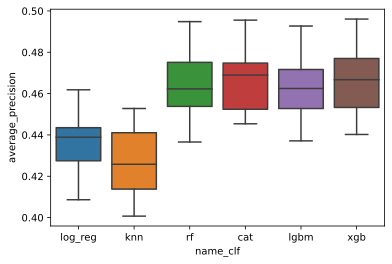

In [25]:
# в общем так как у нас небольшой датасет и только 15% данных
# выделено для теста мы не можем полагаться на тест Макнемара
# для сравнения между собой разных алгоритмов

# хорошо бы иметь дополнительный источник данных для принятия решения
# проводим повторную кросс-валидацию 5 раз с разными random seed
# для разбиения данных для получения более надежных оценок

n_splits = 5
n_repeats = 5
number_models = n_splits * n_repeats
clf_name_list = []
cv_ap_list = []
cv_std_ap = []
cv_mean_ap = []
cv_name_mean_std = []

for pipeline, clf_name in zip(pipelines, classifier_names):    
    
    kfold = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=SEED)
    cv_average_precision_array = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring='average_precision')    
    clf_name_list.extend([clf_name] * number_models)
    cv_ap_list.extend(cv_average_precision_array.tolist())
    
    cv_std_ap.append(np.std(cv_average_precision_array))
    cv_mean_ap.append(np.mean(cv_average_precision_array))
    cv_name_mean_std.append((clf_name, np.mean(cv_average_precision_array), np.std(cv_average_precision_array)))
    
df_clf_ap = pd.DataFrame({'name_clf': clf_name_list, 'average_precision': cv_ap_list})
df_name_mean_std = pd.DataFrame(cv_name_mean_std, columns=['name', 'mean', 'std'])

box_cv_ap = sns.boxplot(x='name_clf', y='average_precision', data=df_clf_ap) 

In [27]:
df_name_mean_std

name      mean       std
0  log_reg  0.435120  0.014038
1      knn  0.427750  0.015810
2       rf  0.464072  0.014424
3      cat  0.465590  0.014567
4     lgbm  0.463170  0.015388
5      xgb  0.466258  0.014847

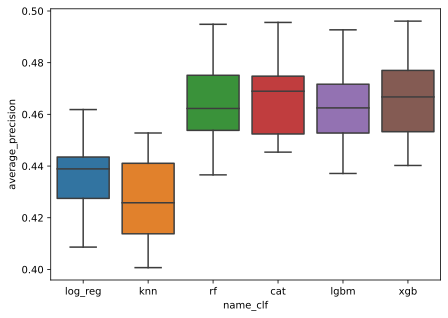

In [26]:
fig = plt.figure(figsize=(7,5)) 
box_cv_ap = sns.boxplot(x='name_clf', y='average_precision', data=df_clf_ap) 

In [50]:
# быстрая проверка 5x2cv f-тест

f, p = combined_ftest_5x2cv(estimator1=pipe_log_reg,
                            estimator2=pipe_knn,
                            X=X_train, y=y_train,
                            random_seed=1)

print('F statistic: %.3f' % f)
print('p value: %.3f' % p)

IndexError: positional indexers are out-of-bounds